# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x_10000.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/125, Loss: 0.8053
Epoch 1/200, Iteration 2/125, Loss: 0.8282
Epoch 1/200, Iteration 3/125, Loss: 1.4741
Epoch 1/200, Iteration 4/125, Loss: 0.9525
Epoch 1/200, Iteration 5/125, Loss: 0.5596
Epoch 1/200, Iteration 6/125, Loss: 0.3847
Epoch 1/200, Iteration 7/125, Loss: 0.2999
Epoch 1/200, Iteration 8/125, Loss: 0.4384
Epoch 1/200, Iteration 9/125, Loss: 0.4034
Epoch 1/200, Iteration 10/125, Loss: 0.4472
Epoch 1/200, Iteration 11/125, Loss: 0.3454
Epoch 1/200, Iteration 12/125, Loss: 0.3285
Epoch 1/200, Iteration 13/125, Loss: 0.4021
Epoch 1/200, Iteration 14/125, Loss: 0.2691
Epoch 1/200, Iteration 15/125, Loss: 0.2921
Epoch 1/200, Iteration 16/125, Loss: 0.2775
Epoch 1/200, Iteration 17/125, Loss: 0.2175
Epoch 1/200, Iteration 18/125, Loss: 0.2765
Epoch 1/200, Iteration 19/125, Loss: 0.1927
Epoch 1/200, Iteration 20/125, Loss: 0.2412
Epoch 1/200, Iteration 21/125, Loss: 0.2465
Epoch 1/200, Iteration 22/125, Loss: 0.3093
Epoch 1/200, Iteration 23/125, Loss: 0.27

Epoch 2/200, Iteration 107/125, Loss: 0.1163
Epoch 2/200, Iteration 108/125, Loss: 0.1317
Epoch 2/200, Iteration 109/125, Loss: 0.0877
Epoch 2/200, Iteration 110/125, Loss: 0.1482
Epoch 2/200, Iteration 111/125, Loss: 0.1340
Epoch 2/200, Iteration 112/125, Loss: 0.0946
Epoch 2/200, Iteration 113/125, Loss: 0.1039
Epoch 2/200, Iteration 114/125, Loss: 0.1212
Epoch 2/200, Iteration 115/125, Loss: 0.1173
Epoch 2/200, Iteration 116/125, Loss: 0.0971
Epoch 2/200, Iteration 117/125, Loss: 0.1438
Epoch 2/200, Iteration 118/125, Loss: 0.1077
Epoch 2/200, Iteration 119/125, Loss: 0.1099
Epoch 2/200, Iteration 120/125, Loss: 0.0910
Epoch 2/200, Iteration 121/125, Loss: 0.1361
Epoch 2/200, Iteration 122/125, Loss: 0.1391
Epoch 2/200, Iteration 123/125, Loss: 0.0957
Epoch 2/200, Iteration 124/125, Loss: 0.1215
Epoch 2/200, Iteration 125/125, Loss: 0.1243
Train Error: 
 Accuracy: 76.92%, Avg loss: 0.120178, MRE: 0.113213, MAE: 0.016492 

Test Error: 
 Accuracy: 75.1%, Avg loss: 0.120861, MRE: 0.104

Epoch 4/200, Iteration 56/125, Loss: 0.1340
Epoch 4/200, Iteration 57/125, Loss: 0.1476
Epoch 4/200, Iteration 58/125, Loss: 0.1695
Epoch 4/200, Iteration 59/125, Loss: 0.1224
Epoch 4/200, Iteration 60/125, Loss: 0.1326
Epoch 4/200, Iteration 61/125, Loss: 0.1117
Epoch 4/200, Iteration 62/125, Loss: 0.1201
Epoch 4/200, Iteration 63/125, Loss: 0.1131
Epoch 4/200, Iteration 64/125, Loss: 0.1417
Epoch 4/200, Iteration 65/125, Loss: 0.1123
Epoch 4/200, Iteration 66/125, Loss: 0.0957
Epoch 4/200, Iteration 67/125, Loss: 0.0928
Epoch 4/200, Iteration 68/125, Loss: 0.1126
Epoch 4/200, Iteration 69/125, Loss: 0.1150
Epoch 4/200, Iteration 70/125, Loss: 0.0747
Epoch 4/200, Iteration 71/125, Loss: 0.1427
Epoch 4/200, Iteration 72/125, Loss: 0.1289
Epoch 4/200, Iteration 73/125, Loss: 0.1136
Epoch 4/200, Iteration 74/125, Loss: 0.1091
Epoch 4/200, Iteration 75/125, Loss: 0.1103
Epoch 4/200, Iteration 76/125, Loss: 0.0903
Epoch 4/200, Iteration 77/125, Loss: 0.0934
Epoch 4/200, Iteration 78/125, L

Train Error: 
 Accuracy: 92.0%, Avg loss: 0.091448, MRE: 0.080227, MAE: 0.011936 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.090612, MRE: 0.070040, MAE: 0.011912 

Epoch 6/200, Iteration 1/125, Loss: 0.0879
Epoch 6/200, Iteration 2/125, Loss: 0.1420
Epoch 6/200, Iteration 3/125, Loss: 0.1597
Epoch 6/200, Iteration 4/125, Loss: 0.1438
Epoch 6/200, Iteration 5/125, Loss: 0.1159
Epoch 6/200, Iteration 6/125, Loss: 0.1326
Epoch 6/200, Iteration 7/125, Loss: 0.1510
Epoch 6/200, Iteration 8/125, Loss: 0.1078
Epoch 6/200, Iteration 9/125, Loss: 0.1449
Epoch 6/200, Iteration 10/125, Loss: 0.1468
Epoch 6/200, Iteration 11/125, Loss: 0.1134
Epoch 6/200, Iteration 12/125, Loss: 0.1666
Epoch 6/200, Iteration 13/125, Loss: 0.1069
Epoch 6/200, Iteration 14/125, Loss: 0.1354
Epoch 6/200, Iteration 15/125, Loss: 0.1434
Epoch 6/200, Iteration 16/125, Loss: 0.1034
Epoch 6/200, Iteration 17/125, Loss: 0.1172
Epoch 6/200, Iteration 18/125, Loss: 0.0980
Epoch 6/200, Iteration 19/125, Loss: 0.0838
Epoch 6/

Epoch 7/200, Iteration 97/125, Loss: 0.0874
Epoch 7/200, Iteration 98/125, Loss: 0.0926
Epoch 7/200, Iteration 99/125, Loss: 0.1239
Epoch 7/200, Iteration 100/125, Loss: 0.0935
Epoch 7/200, Iteration 101/125, Loss: 0.0920
Epoch 7/200, Iteration 102/125, Loss: 0.1017
Epoch 7/200, Iteration 103/125, Loss: 0.1180
Epoch 7/200, Iteration 104/125, Loss: 0.1016
Epoch 7/200, Iteration 105/125, Loss: 0.1142
Epoch 7/200, Iteration 106/125, Loss: 0.0994
Epoch 7/200, Iteration 107/125, Loss: 0.0890
Epoch 7/200, Iteration 108/125, Loss: 0.0824
Epoch 7/200, Iteration 109/125, Loss: 0.1142
Epoch 7/200, Iteration 110/125, Loss: 0.1144
Epoch 7/200, Iteration 111/125, Loss: 0.0763
Epoch 7/200, Iteration 112/125, Loss: 0.0966
Epoch 7/200, Iteration 113/125, Loss: 0.1091
Epoch 7/200, Iteration 114/125, Loss: 0.0915
Epoch 7/200, Iteration 115/125, Loss: 0.1107
Epoch 7/200, Iteration 116/125, Loss: 0.0800
Epoch 7/200, Iteration 117/125, Loss: 0.0908
Epoch 7/200, Iteration 118/125, Loss: 0.1173
Epoch 7/200, 

Epoch 9/200, Iteration 49/125, Loss: 0.1201
Epoch 9/200, Iteration 50/125, Loss: 0.0923
Epoch 9/200, Iteration 51/125, Loss: 0.1252
Epoch 9/200, Iteration 52/125, Loss: 0.1012
Epoch 9/200, Iteration 53/125, Loss: 0.1236
Epoch 9/200, Iteration 54/125, Loss: 0.1538
Epoch 9/200, Iteration 55/125, Loss: 0.0829
Epoch 9/200, Iteration 56/125, Loss: 0.1451
Epoch 9/200, Iteration 57/125, Loss: 0.1186
Epoch 9/200, Iteration 58/125, Loss: 0.1087
Epoch 9/200, Iteration 59/125, Loss: 0.0920
Epoch 9/200, Iteration 60/125, Loss: 0.0909
Epoch 9/200, Iteration 61/125, Loss: 0.1193
Epoch 9/200, Iteration 62/125, Loss: 0.1139
Epoch 9/200, Iteration 63/125, Loss: 0.1507
Epoch 9/200, Iteration 64/125, Loss: 0.1568
Epoch 9/200, Iteration 65/125, Loss: 0.1406
Epoch 9/200, Iteration 66/125, Loss: 0.1253
Epoch 9/200, Iteration 67/125, Loss: 0.1121
Epoch 9/200, Iteration 68/125, Loss: 0.1034
Epoch 9/200, Iteration 69/125, Loss: 0.0951
Epoch 9/200, Iteration 70/125, Loss: 0.0772
Epoch 9/200, Iteration 71/125, L

Epoch 10/200, Iteration 112/125, Loss: 0.1489
Epoch 10/200, Iteration 113/125, Loss: 0.1119
Epoch 10/200, Iteration 114/125, Loss: 0.1256
Epoch 10/200, Iteration 115/125, Loss: 0.1255
Epoch 10/200, Iteration 116/125, Loss: 0.1122
Epoch 10/200, Iteration 117/125, Loss: 0.1626
Epoch 10/200, Iteration 118/125, Loss: 0.1046
Epoch 10/200, Iteration 119/125, Loss: 0.1457
Epoch 10/200, Iteration 120/125, Loss: 0.1274
Epoch 10/200, Iteration 121/125, Loss: 0.1019
Epoch 10/200, Iteration 122/125, Loss: 0.1446
Epoch 10/200, Iteration 123/125, Loss: 0.0786
Epoch 10/200, Iteration 124/125, Loss: 0.1373
Epoch 10/200, Iteration 125/125, Loss: 0.1294
Train Error: 
 Accuracy: 60.05%, Avg loss: 0.117170, MRE: 0.096305, MAE: 0.015642 

Test Error: 
 Accuracy: 59.0%, Avg loss: 0.118227, MRE: 0.091813, MAE: 0.015876 

Epoch 11/200, Iteration 1/125, Loss: 0.1070
Epoch 11/200, Iteration 2/125, Loss: 0.1329
Epoch 11/200, Iteration 3/125, Loss: 0.1039
Epoch 11/200, Iteration 4/125, Loss: 0.1050
Epoch 11/200, 

Epoch 12/200, Iteration 45/125, Loss: 0.1379
Epoch 12/200, Iteration 46/125, Loss: 0.1233
Epoch 12/200, Iteration 47/125, Loss: 0.1238
Epoch 12/200, Iteration 48/125, Loss: 0.1606
Epoch 12/200, Iteration 49/125, Loss: 0.1229
Epoch 12/200, Iteration 50/125, Loss: 0.0971
Epoch 12/200, Iteration 51/125, Loss: 0.1221
Epoch 12/200, Iteration 52/125, Loss: 0.1164
Epoch 12/200, Iteration 53/125, Loss: 0.0897
Epoch 12/200, Iteration 54/125, Loss: 0.1213
Epoch 12/200, Iteration 55/125, Loss: 0.1190
Epoch 12/200, Iteration 56/125, Loss: 0.1122
Epoch 12/200, Iteration 57/125, Loss: 0.1275
Epoch 12/200, Iteration 58/125, Loss: 0.0967
Epoch 12/200, Iteration 59/125, Loss: 0.1150
Epoch 12/200, Iteration 60/125, Loss: 0.1267
Epoch 12/200, Iteration 61/125, Loss: 0.0896
Epoch 12/200, Iteration 62/125, Loss: 0.1038
Epoch 12/200, Iteration 63/125, Loss: 0.0801
Epoch 12/200, Iteration 64/125, Loss: 0.1256
Epoch 12/200, Iteration 65/125, Loss: 0.1003
Epoch 12/200, Iteration 66/125, Loss: 0.0820
Epoch 12/2

Train Error: 
 Accuracy: 74.04%, Avg loss: 0.135185, MRE: 0.103281, MAE: 0.019719 

Test Error: 
 Accuracy: 75.55%, Avg loss: 0.133699, MRE: 0.094457, MAE: 0.019471 

Epoch 14/200, Iteration 1/125, Loss: 0.1384
Epoch 14/200, Iteration 2/125, Loss: 0.1020
Epoch 14/200, Iteration 3/125, Loss: 0.1358
Epoch 14/200, Iteration 4/125, Loss: 0.1420
Epoch 14/200, Iteration 5/125, Loss: 0.1234
Epoch 14/200, Iteration 6/125, Loss: 0.1275
Epoch 14/200, Iteration 7/125, Loss: 0.1271
Epoch 14/200, Iteration 8/125, Loss: 0.1272
Epoch 14/200, Iteration 9/125, Loss: 0.1455
Epoch 14/200, Iteration 10/125, Loss: 0.0878
Epoch 14/200, Iteration 11/125, Loss: 0.1249
Epoch 14/200, Iteration 12/125, Loss: 0.1068
Epoch 14/200, Iteration 13/125, Loss: 0.1178
Epoch 14/200, Iteration 14/125, Loss: 0.0848
Epoch 14/200, Iteration 15/125, Loss: 0.1516
Epoch 14/200, Iteration 16/125, Loss: 0.1291
Epoch 14/200, Iteration 17/125, Loss: 0.1340
Epoch 14/200, Iteration 18/125, Loss: 0.1490
Epoch 14/200, Iteration 19/125, 

Epoch 15/200, Iteration 54/125, Loss: 0.1469
Epoch 15/200, Iteration 55/125, Loss: 0.1321
Epoch 15/200, Iteration 56/125, Loss: 0.1160
Epoch 15/200, Iteration 57/125, Loss: 0.1950
Epoch 15/200, Iteration 58/125, Loss: 0.1653
Epoch 15/200, Iteration 59/125, Loss: 0.1311
Epoch 15/200, Iteration 60/125, Loss: 0.1583
Epoch 15/200, Iteration 61/125, Loss: 0.1379
Epoch 15/200, Iteration 62/125, Loss: 0.1148
Epoch 15/200, Iteration 63/125, Loss: 0.0993
Epoch 15/200, Iteration 64/125, Loss: 0.1052
Epoch 15/200, Iteration 65/125, Loss: 0.1096
Epoch 15/200, Iteration 66/125, Loss: 0.0851
Epoch 15/200, Iteration 67/125, Loss: 0.1164
Epoch 15/200, Iteration 68/125, Loss: 0.0796
Epoch 15/200, Iteration 69/125, Loss: 0.0997
Epoch 15/200, Iteration 70/125, Loss: 0.0959
Epoch 15/200, Iteration 71/125, Loss: 0.1063
Epoch 15/200, Iteration 72/125, Loss: 0.1217
Epoch 15/200, Iteration 73/125, Loss: 0.1124
Epoch 15/200, Iteration 74/125, Loss: 0.1011
Epoch 15/200, Iteration 75/125, Loss: 0.1279
Epoch 15/2

Train Error: 
 Accuracy: 69.62%, Avg loss: 0.146717, MRE: 0.097511, MAE: 0.022195 

Test Error: 
 Accuracy: 68.25%, Avg loss: 0.148558, MRE: 0.091888, MAE: 0.022435 

Epoch 17/200, Iteration 1/125, Loss: 0.1445
Epoch 17/200, Iteration 2/125, Loss: 0.1054
Epoch 17/200, Iteration 3/125, Loss: 0.1394
Epoch 17/200, Iteration 4/125, Loss: 0.1638
Epoch 17/200, Iteration 5/125, Loss: 0.0861
Epoch 17/200, Iteration 6/125, Loss: 0.1069
Epoch 17/200, Iteration 7/125, Loss: 0.1110
Epoch 17/200, Iteration 8/125, Loss: 0.0880
Epoch 17/200, Iteration 9/125, Loss: 0.0979
Epoch 17/200, Iteration 10/125, Loss: 0.0980
Epoch 17/200, Iteration 11/125, Loss: 0.0865
Epoch 17/200, Iteration 12/125, Loss: 0.0879
Epoch 17/200, Iteration 13/125, Loss: 0.0660
Epoch 17/200, Iteration 14/125, Loss: 0.1099
Epoch 17/200, Iteration 15/125, Loss: 0.1096
Epoch 17/200, Iteration 16/125, Loss: 0.1256
Epoch 17/200, Iteration 17/125, Loss: 0.1036
Epoch 17/200, Iteration 18/125, Loss: 0.1304
Epoch 17/200, Iteration 19/125, 

Epoch 18/200, Iteration 54/125, Loss: 0.1900
Epoch 18/200, Iteration 55/125, Loss: 0.1314
Epoch 18/200, Iteration 56/125, Loss: 0.1527
Epoch 18/200, Iteration 57/125, Loss: 0.1764
Epoch 18/200, Iteration 58/125, Loss: 0.1287
Epoch 18/200, Iteration 59/125, Loss: 0.1487
Epoch 18/200, Iteration 60/125, Loss: 0.0865
Epoch 18/200, Iteration 61/125, Loss: 0.1289
Epoch 18/200, Iteration 62/125, Loss: 0.1306
Epoch 18/200, Iteration 63/125, Loss: 0.1082
Epoch 18/200, Iteration 64/125, Loss: 0.1470
Epoch 18/200, Iteration 65/125, Loss: 0.0833
Epoch 18/200, Iteration 66/125, Loss: 0.1211
Epoch 18/200, Iteration 67/125, Loss: 0.0959
Epoch 18/200, Iteration 68/125, Loss: 0.1081
Epoch 18/200, Iteration 69/125, Loss: 0.1117
Epoch 18/200, Iteration 70/125, Loss: 0.0987
Epoch 18/200, Iteration 71/125, Loss: 0.1168
Epoch 18/200, Iteration 72/125, Loss: 0.0714
Epoch 18/200, Iteration 73/125, Loss: 0.0998
Epoch 18/200, Iteration 74/125, Loss: 0.0900
Epoch 18/200, Iteration 75/125, Loss: 0.1042
Epoch 18/2

Epoch 19/200, Iteration 115/125, Loss: 0.0990
Epoch 19/200, Iteration 116/125, Loss: 0.1195
Epoch 19/200, Iteration 117/125, Loss: 0.0925
Epoch 19/200, Iteration 118/125, Loss: 0.1169
Epoch 19/200, Iteration 119/125, Loss: 0.1164
Epoch 19/200, Iteration 120/125, Loss: 0.0826
Epoch 19/200, Iteration 121/125, Loss: 0.0937
Epoch 19/200, Iteration 122/125, Loss: 0.0906
Epoch 19/200, Iteration 123/125, Loss: 0.0842
Epoch 19/200, Iteration 124/125, Loss: 0.0857
Epoch 19/200, Iteration 125/125, Loss: 0.0895
Train Error: 
 Accuracy: 77.06%, Avg loss: 0.091683, MRE: 0.076178, MAE: 0.012654 

Test Error: 
 Accuracy: 78.0%, Avg loss: 0.091332, MRE: 0.069011, MAE: 0.012692 

Epoch 20/200, Iteration 1/125, Loss: 0.0764
Epoch 20/200, Iteration 2/125, Loss: 0.0847
Epoch 20/200, Iteration 3/125, Loss: 0.0856
Epoch 20/200, Iteration 4/125, Loss: 0.0731
Epoch 20/200, Iteration 5/125, Loss: 0.0840
Epoch 20/200, Iteration 6/125, Loss: 0.1042
Epoch 20/200, Iteration 7/125, Loss: 0.0684
Epoch 20/200, Iterat

Epoch 21/200, Iteration 52/125, Loss: 0.0811
Epoch 21/200, Iteration 53/125, Loss: 0.0862
Epoch 21/200, Iteration 54/125, Loss: 0.0822
Epoch 21/200, Iteration 55/125, Loss: 0.0889
Epoch 21/200, Iteration 56/125, Loss: 0.0831
Epoch 21/200, Iteration 57/125, Loss: 0.1244
Epoch 21/200, Iteration 58/125, Loss: 0.1008
Epoch 21/200, Iteration 59/125, Loss: 0.1146
Epoch 21/200, Iteration 60/125, Loss: 0.1348
Epoch 21/200, Iteration 61/125, Loss: 0.1044
Epoch 21/200, Iteration 62/125, Loss: 0.1300
Epoch 21/200, Iteration 63/125, Loss: 0.1342
Epoch 21/200, Iteration 64/125, Loss: 0.1105
Epoch 21/200, Iteration 65/125, Loss: 0.1412
Epoch 21/200, Iteration 66/125, Loss: 0.1030
Epoch 21/200, Iteration 67/125, Loss: 0.1192
Epoch 21/200, Iteration 68/125, Loss: 0.1153
Epoch 21/200, Iteration 69/125, Loss: 0.1021
Epoch 21/200, Iteration 70/125, Loss: 0.1215
Epoch 21/200, Iteration 71/125, Loss: 0.1023
Epoch 21/200, Iteration 72/125, Loss: 0.0942
Epoch 21/200, Iteration 73/125, Loss: 0.1032
Epoch 21/2

Train Error: 
 Accuracy: 61.0%, Avg loss: 0.095859, MRE: 0.074716, MAE: 0.011655 

Test Error: 
 Accuracy: 62.85%, Avg loss: 0.094228, MRE: 0.065411, MAE: 0.011541 

Epoch 23/200, Iteration 1/125, Loss: 0.0823
Epoch 23/200, Iteration 2/125, Loss: 0.0828
Epoch 23/200, Iteration 3/125, Loss: 0.0958
Epoch 23/200, Iteration 4/125, Loss: 0.1156
Epoch 23/200, Iteration 5/125, Loss: 0.1059
Epoch 23/200, Iteration 6/125, Loss: 0.0753
Epoch 23/200, Iteration 7/125, Loss: 0.0826
Epoch 23/200, Iteration 8/125, Loss: 0.1069
Epoch 23/200, Iteration 9/125, Loss: 0.1148
Epoch 23/200, Iteration 10/125, Loss: 0.0617
Epoch 23/200, Iteration 11/125, Loss: 0.0970
Epoch 23/200, Iteration 12/125, Loss: 0.1159
Epoch 23/200, Iteration 13/125, Loss: 0.1134
Epoch 23/200, Iteration 14/125, Loss: 0.1068
Epoch 23/200, Iteration 15/125, Loss: 0.1252
Epoch 23/200, Iteration 16/125, Loss: 0.1340
Epoch 23/200, Iteration 17/125, Loss: 0.1024
Epoch 23/200, Iteration 18/125, Loss: 0.1292
Epoch 23/200, Iteration 19/125, L

Epoch 24/200, Iteration 100/125, Loss: 0.1811
Epoch 24/200, Iteration 101/125, Loss: 0.1738
Epoch 24/200, Iteration 102/125, Loss: 0.1459
Epoch 24/200, Iteration 103/125, Loss: 0.1951
Epoch 24/200, Iteration 104/125, Loss: 0.1806
Epoch 24/200, Iteration 105/125, Loss: 0.1113
Epoch 24/200, Iteration 106/125, Loss: 0.1603
Epoch 24/200, Iteration 107/125, Loss: 0.1708
Epoch 24/200, Iteration 108/125, Loss: 0.1382
Epoch 24/200, Iteration 109/125, Loss: 0.1932
Epoch 24/200, Iteration 110/125, Loss: 0.1641
Epoch 24/200, Iteration 111/125, Loss: 0.1417
Epoch 24/200, Iteration 112/125, Loss: 0.1921
Epoch 24/200, Iteration 113/125, Loss: 0.1134
Epoch 24/200, Iteration 114/125, Loss: 0.1540
Epoch 24/200, Iteration 115/125, Loss: 0.1262
Epoch 24/200, Iteration 116/125, Loss: 0.1406
Epoch 24/200, Iteration 117/125, Loss: 0.1679
Epoch 24/200, Iteration 118/125, Loss: 0.1155
Epoch 24/200, Iteration 119/125, Loss: 0.1172
Epoch 24/200, Iteration 120/125, Loss: 0.1419
Epoch 24/200, Iteration 121/125, L

Epoch 26/200, Iteration 50/125, Loss: 0.0866
Epoch 26/200, Iteration 51/125, Loss: 0.1141
Epoch 26/200, Iteration 52/125, Loss: 0.1134
Epoch 26/200, Iteration 53/125, Loss: 0.1026
Epoch 26/200, Iteration 54/125, Loss: 0.1015
Epoch 26/200, Iteration 55/125, Loss: 0.1020
Epoch 26/200, Iteration 56/125, Loss: 0.1430
Epoch 26/200, Iteration 57/125, Loss: 0.1082
Epoch 26/200, Iteration 58/125, Loss: 0.1455
Epoch 26/200, Iteration 59/125, Loss: 0.1398
Epoch 26/200, Iteration 60/125, Loss: 0.1132
Epoch 26/200, Iteration 61/125, Loss: 0.1266
Epoch 26/200, Iteration 62/125, Loss: 0.0811
Epoch 26/200, Iteration 63/125, Loss: 0.1416
Epoch 26/200, Iteration 64/125, Loss: 0.1013
Epoch 26/200, Iteration 65/125, Loss: 0.1545
Epoch 26/200, Iteration 66/125, Loss: 0.1142
Epoch 26/200, Iteration 67/125, Loss: 0.1309
Epoch 26/200, Iteration 68/125, Loss: 0.1203
Epoch 26/200, Iteration 69/125, Loss: 0.0949
Epoch 26/200, Iteration 70/125, Loss: 0.1234
Epoch 26/200, Iteration 71/125, Loss: 0.1210
Epoch 26/2

Epoch 27/200, Iteration 107/125, Loss: 0.0924
Epoch 27/200, Iteration 108/125, Loss: 0.1104
Epoch 27/200, Iteration 109/125, Loss: 0.0931
Epoch 27/200, Iteration 110/125, Loss: 0.0891
Epoch 27/200, Iteration 111/125, Loss: 0.0909
Epoch 27/200, Iteration 112/125, Loss: 0.0989
Epoch 27/200, Iteration 113/125, Loss: 0.0820
Epoch 27/200, Iteration 114/125, Loss: 0.0718
Epoch 27/200, Iteration 115/125, Loss: 0.0815
Epoch 27/200, Iteration 116/125, Loss: 0.0786
Epoch 27/200, Iteration 117/125, Loss: 0.0641
Epoch 27/200, Iteration 118/125, Loss: 0.0716
Epoch 27/200, Iteration 119/125, Loss: 0.0922
Epoch 27/200, Iteration 120/125, Loss: 0.0831
Epoch 27/200, Iteration 121/125, Loss: 0.0774
Epoch 27/200, Iteration 122/125, Loss: 0.0891
Epoch 27/200, Iteration 123/125, Loss: 0.0834
Epoch 27/200, Iteration 124/125, Loss: 0.1212
Epoch 27/200, Iteration 125/125, Loss: 0.0910
Train Error: 
 Accuracy: 34.09%, Avg loss: 0.113521, MRE: 0.116151, MAE: 0.013166 

Test Error: 
 Accuracy: 32.65%, Avg loss: 

Epoch 29/200, Iteration 50/125, Loss: 0.1056
Epoch 29/200, Iteration 51/125, Loss: 0.0883
Epoch 29/200, Iteration 52/125, Loss: 0.0936
Epoch 29/200, Iteration 53/125, Loss: 0.0943
Epoch 29/200, Iteration 54/125, Loss: 0.0940
Epoch 29/200, Iteration 55/125, Loss: 0.1107
Epoch 29/200, Iteration 56/125, Loss: 0.0862
Epoch 29/200, Iteration 57/125, Loss: 0.0851
Epoch 29/200, Iteration 58/125, Loss: 0.0917
Epoch 29/200, Iteration 59/125, Loss: 0.0884
Epoch 29/200, Iteration 60/125, Loss: 0.0691
Epoch 29/200, Iteration 61/125, Loss: 0.0881
Epoch 29/200, Iteration 62/125, Loss: 0.0905
Epoch 29/200, Iteration 63/125, Loss: 0.0954
Epoch 29/200, Iteration 64/125, Loss: 0.1270
Epoch 29/200, Iteration 65/125, Loss: 0.1068
Epoch 29/200, Iteration 66/125, Loss: 0.0901
Epoch 29/200, Iteration 67/125, Loss: 0.0889
Epoch 29/200, Iteration 68/125, Loss: 0.0988
Epoch 29/200, Iteration 69/125, Loss: 0.0949
Epoch 29/200, Iteration 70/125, Loss: 0.0775
Epoch 29/200, Iteration 71/125, Loss: 0.0920
Epoch 29/2

Epoch 30/200, Iteration 107/125, Loss: 0.0800
Epoch 30/200, Iteration 108/125, Loss: 0.0724
Epoch 30/200, Iteration 109/125, Loss: 0.0761
Epoch 30/200, Iteration 110/125, Loss: 0.0868
Epoch 30/200, Iteration 111/125, Loss: 0.0803
Epoch 30/200, Iteration 112/125, Loss: 0.1145
Epoch 30/200, Iteration 113/125, Loss: 0.0932
Epoch 30/200, Iteration 114/125, Loss: 0.0991
Epoch 30/200, Iteration 115/125, Loss: 0.0952
Epoch 30/200, Iteration 116/125, Loss: 0.1123
Epoch 30/200, Iteration 117/125, Loss: 0.0920
Epoch 30/200, Iteration 118/125, Loss: 0.1200
Epoch 30/200, Iteration 119/125, Loss: 0.0913
Epoch 30/200, Iteration 120/125, Loss: 0.1359
Epoch 30/200, Iteration 121/125, Loss: 0.1192
Epoch 30/200, Iteration 122/125, Loss: 0.1292
Epoch 30/200, Iteration 123/125, Loss: 0.1363
Epoch 30/200, Iteration 124/125, Loss: 0.1309
Epoch 30/200, Iteration 125/125, Loss: 0.1658
Train Error: 
 Accuracy: 30.54%, Avg loss: 0.179613, MRE: 0.124011, MAE: 0.024312 

Test Error: 
 Accuracy: 29.55%, Avg loss: 

Epoch 32/200, Iteration 53/125, Loss: 0.1139
Epoch 32/200, Iteration 54/125, Loss: 0.1270
Epoch 32/200, Iteration 55/125, Loss: 0.1270
Epoch 32/200, Iteration 56/125, Loss: 0.1237
Epoch 32/200, Iteration 57/125, Loss: 0.1653
Epoch 32/200, Iteration 58/125, Loss: 0.0830
Epoch 32/200, Iteration 59/125, Loss: 0.2223
Epoch 32/200, Iteration 60/125, Loss: 0.2504
Epoch 32/200, Iteration 61/125, Loss: 0.1070
Epoch 32/200, Iteration 62/125, Loss: 0.1832
Epoch 32/200, Iteration 63/125, Loss: 0.1627
Epoch 32/200, Iteration 64/125, Loss: 0.1019
Epoch 32/200, Iteration 65/125, Loss: 0.1684
Epoch 32/200, Iteration 66/125, Loss: 0.1368
Epoch 32/200, Iteration 67/125, Loss: 0.1591
Epoch 32/200, Iteration 68/125, Loss: 0.1719
Epoch 32/200, Iteration 69/125, Loss: 0.1003
Epoch 32/200, Iteration 70/125, Loss: 0.1528
Epoch 32/200, Iteration 71/125, Loss: 0.1432
Epoch 32/200, Iteration 72/125, Loss: 0.1415
Epoch 32/200, Iteration 73/125, Loss: 0.1524
Epoch 32/200, Iteration 74/125, Loss: 0.1012
Epoch 32/2

Epoch 33/200, Iteration 108/125, Loss: 0.0893
Epoch 33/200, Iteration 109/125, Loss: 0.0675
Epoch 33/200, Iteration 110/125, Loss: 0.0854
Epoch 33/200, Iteration 111/125, Loss: 0.0802
Epoch 33/200, Iteration 112/125, Loss: 0.0824
Epoch 33/200, Iteration 113/125, Loss: 0.0907
Epoch 33/200, Iteration 114/125, Loss: 0.0916
Epoch 33/200, Iteration 115/125, Loss: 0.0873
Epoch 33/200, Iteration 116/125, Loss: 0.0827
Epoch 33/200, Iteration 117/125, Loss: 0.1228
Epoch 33/200, Iteration 118/125, Loss: 0.0934
Epoch 33/200, Iteration 119/125, Loss: 0.1033
Epoch 33/200, Iteration 120/125, Loss: 0.0902
Epoch 33/200, Iteration 121/125, Loss: 0.0909
Epoch 33/200, Iteration 122/125, Loss: 0.0698
Epoch 33/200, Iteration 123/125, Loss: 0.0934
Epoch 33/200, Iteration 124/125, Loss: 0.1046
Epoch 33/200, Iteration 125/125, Loss: 0.0977
Train Error: 
 Accuracy: 76.04%, Avg loss: 0.090949, MRE: 0.076574, MAE: 0.012510 

Test Error: 
 Accuracy: 76.65%, Avg loss: 0.091121, MRE: 0.075372, MAE: 0.012603 

Epoch

Epoch 35/200, Iteration 43/125, Loss: 0.1151
Epoch 35/200, Iteration 44/125, Loss: 0.1034
Epoch 35/200, Iteration 45/125, Loss: 0.1130
Epoch 35/200, Iteration 46/125, Loss: 0.0860
Epoch 35/200, Iteration 47/125, Loss: 0.1237
Epoch 35/200, Iteration 48/125, Loss: 0.0775
Epoch 35/200, Iteration 49/125, Loss: 0.0747
Epoch 35/200, Iteration 50/125, Loss: 0.0996
Epoch 35/200, Iteration 51/125, Loss: 0.1230
Epoch 35/200, Iteration 52/125, Loss: 0.1052
Epoch 35/200, Iteration 53/125, Loss: 0.0775
Epoch 35/200, Iteration 54/125, Loss: 0.1201
Epoch 35/200, Iteration 55/125, Loss: 0.1103
Epoch 35/200, Iteration 56/125, Loss: 0.0975
Epoch 35/200, Iteration 57/125, Loss: 0.0991
Epoch 35/200, Iteration 58/125, Loss: 0.0997
Epoch 35/200, Iteration 59/125, Loss: 0.1212
Epoch 35/200, Iteration 60/125, Loss: 0.0880
Epoch 35/200, Iteration 61/125, Loss: 0.1312
Epoch 35/200, Iteration 62/125, Loss: 0.1083
Epoch 35/200, Iteration 63/125, Loss: 0.1346
Epoch 35/200, Iteration 64/125, Loss: 0.1327
Epoch 35/2

Epoch 36/200, Iteration 111/125, Loss: 0.0903
Epoch 36/200, Iteration 112/125, Loss: 0.1051
Epoch 36/200, Iteration 113/125, Loss: 0.1130
Epoch 36/200, Iteration 114/125, Loss: 0.0937
Epoch 36/200, Iteration 115/125, Loss: 0.1139
Epoch 36/200, Iteration 116/125, Loss: 0.1063
Epoch 36/200, Iteration 117/125, Loss: 0.1193
Epoch 36/200, Iteration 118/125, Loss: 0.0891
Epoch 36/200, Iteration 119/125, Loss: 0.1299
Epoch 36/200, Iteration 120/125, Loss: 0.1221
Epoch 36/200, Iteration 121/125, Loss: 0.0847
Epoch 36/200, Iteration 122/125, Loss: 0.1043
Epoch 36/200, Iteration 123/125, Loss: 0.1078
Epoch 36/200, Iteration 124/125, Loss: 0.1255
Epoch 36/200, Iteration 125/125, Loss: 0.0930
Train Error: 
 Accuracy: 99.06%, Avg loss: 0.131901, MRE: 0.090312, MAE: 0.015243 

Test Error: 
 Accuracy: 99.05%, Avg loss: 0.131273, MRE: 0.085990, MAE: 0.015137 

Epoch 37/200, Iteration 1/125, Loss: 0.1271
Epoch 37/200, Iteration 2/125, Loss: 0.1127
Epoch 37/200, Iteration 3/125, Loss: 0.1220
Epoch 37/20

Epoch 38/200, Iteration 48/125, Loss: 0.0497
Epoch 38/200, Iteration 49/125, Loss: 0.0435
Epoch 38/200, Iteration 50/125, Loss: 0.0397
Epoch 38/200, Iteration 51/125, Loss: 0.0410
Epoch 38/200, Iteration 52/125, Loss: 0.0477
Epoch 38/200, Iteration 53/125, Loss: 0.0433
Epoch 38/200, Iteration 54/125, Loss: 0.0425
Epoch 38/200, Iteration 55/125, Loss: 0.0327
Epoch 38/200, Iteration 56/125, Loss: 0.0385
Epoch 38/200, Iteration 57/125, Loss: 0.0410
Epoch 38/200, Iteration 58/125, Loss: 0.0470
Epoch 38/200, Iteration 59/125, Loss: 0.0445
Epoch 38/200, Iteration 60/125, Loss: 0.0441
Epoch 38/200, Iteration 61/125, Loss: 0.0454
Epoch 38/200, Iteration 62/125, Loss: 0.0396
Epoch 38/200, Iteration 63/125, Loss: 0.0495
Epoch 38/200, Iteration 64/125, Loss: 0.0414
Epoch 38/200, Iteration 65/125, Loss: 0.0392
Epoch 38/200, Iteration 66/125, Loss: 0.0483
Epoch 38/200, Iteration 67/125, Loss: 0.0414
Epoch 38/200, Iteration 68/125, Loss: 0.0438
Epoch 38/200, Iteration 69/125, Loss: 0.0460
Epoch 38/2

Epoch 39/200, Iteration 107/125, Loss: 0.0309
Epoch 39/200, Iteration 108/125, Loss: 0.0314
Epoch 39/200, Iteration 109/125, Loss: 0.0354
Epoch 39/200, Iteration 110/125, Loss: 0.0265
Epoch 39/200, Iteration 111/125, Loss: 0.0321
Epoch 39/200, Iteration 112/125, Loss: 0.0303
Epoch 39/200, Iteration 113/125, Loss: 0.0311
Epoch 39/200, Iteration 114/125, Loss: 0.0311
Epoch 39/200, Iteration 115/125, Loss: 0.0296
Epoch 39/200, Iteration 116/125, Loss: 0.0285
Epoch 39/200, Iteration 117/125, Loss: 0.0282
Epoch 39/200, Iteration 118/125, Loss: 0.0228
Epoch 39/200, Iteration 119/125, Loss: 0.0307
Epoch 39/200, Iteration 120/125, Loss: 0.0303
Epoch 39/200, Iteration 121/125, Loss: 0.0368
Epoch 39/200, Iteration 122/125, Loss: 0.0379
Epoch 39/200, Iteration 123/125, Loss: 0.0304
Epoch 39/200, Iteration 124/125, Loss: 0.0332
Epoch 39/200, Iteration 125/125, Loss: 0.0310
Train Error: 
 Accuracy: 99.31%, Avg loss: 0.029786, MRE: 0.027555, MAE: 0.003895 

Test Error: 
 Accuracy: 99.15%, Avg loss: 

Epoch 41/200, Iteration 51/125, Loss: 0.0237
Epoch 41/200, Iteration 52/125, Loss: 0.0360
Epoch 41/200, Iteration 53/125, Loss: 0.0270
Epoch 41/200, Iteration 54/125, Loss: 0.0307
Epoch 41/200, Iteration 55/125, Loss: 0.0279
Epoch 41/200, Iteration 56/125, Loss: 0.0270
Epoch 41/200, Iteration 57/125, Loss: 0.0272
Epoch 41/200, Iteration 58/125, Loss: 0.0238
Epoch 41/200, Iteration 59/125, Loss: 0.0273
Epoch 41/200, Iteration 60/125, Loss: 0.0297
Epoch 41/200, Iteration 61/125, Loss: 0.0269
Epoch 41/200, Iteration 62/125, Loss: 0.0228
Epoch 41/200, Iteration 63/125, Loss: 0.0271
Epoch 41/200, Iteration 64/125, Loss: 0.0290
Epoch 41/200, Iteration 65/125, Loss: 0.0263
Epoch 41/200, Iteration 66/125, Loss: 0.0298
Epoch 41/200, Iteration 67/125, Loss: 0.0285
Epoch 41/200, Iteration 68/125, Loss: 0.0263
Epoch 41/200, Iteration 69/125, Loss: 0.0246
Epoch 41/200, Iteration 70/125, Loss: 0.0247
Epoch 41/200, Iteration 71/125, Loss: 0.0295
Epoch 41/200, Iteration 72/125, Loss: 0.0320
Epoch 41/2

Train Error: 
 Accuracy: 99.22%, Avg loss: 0.022223, MRE: 0.020124, MAE: 0.002923 

Test Error: 
 Accuracy: 98.6%, Avg loss: 0.024534, MRE: 0.018219, MAE: 0.003226 

Epoch 43/200, Iteration 1/125, Loss: 0.0214
Epoch 43/200, Iteration 2/125, Loss: 0.0203
Epoch 43/200, Iteration 3/125, Loss: 0.0256
Epoch 43/200, Iteration 4/125, Loss: 0.0226
Epoch 43/200, Iteration 5/125, Loss: 0.0232
Epoch 43/200, Iteration 6/125, Loss: 0.0228
Epoch 43/200, Iteration 7/125, Loss: 0.0258
Epoch 43/200, Iteration 8/125, Loss: 0.0268
Epoch 43/200, Iteration 9/125, Loss: 0.0233
Epoch 43/200, Iteration 10/125, Loss: 0.0247
Epoch 43/200, Iteration 11/125, Loss: 0.0235
Epoch 43/200, Iteration 12/125, Loss: 0.0348
Epoch 43/200, Iteration 13/125, Loss: 0.0243
Epoch 43/200, Iteration 14/125, Loss: 0.0284
Epoch 43/200, Iteration 15/125, Loss: 0.0244
Epoch 43/200, Iteration 16/125, Loss: 0.0200
Epoch 43/200, Iteration 17/125, Loss: 0.0260
Epoch 43/200, Iteration 18/125, Loss: 0.0275
Epoch 43/200, Iteration 19/125, L

Epoch 44/200, Iteration 55/125, Loss: 0.0251
Epoch 44/200, Iteration 56/125, Loss: 0.0292
Epoch 44/200, Iteration 57/125, Loss: 0.0225
Epoch 44/200, Iteration 58/125, Loss: 0.0278
Epoch 44/200, Iteration 59/125, Loss: 0.0231
Epoch 44/200, Iteration 60/125, Loss: 0.0246
Epoch 44/200, Iteration 61/125, Loss: 0.0221
Epoch 44/200, Iteration 62/125, Loss: 0.0211
Epoch 44/200, Iteration 63/125, Loss: 0.0211
Epoch 44/200, Iteration 64/125, Loss: 0.0269
Epoch 44/200, Iteration 65/125, Loss: 0.0248
Epoch 44/200, Iteration 66/125, Loss: 0.0217
Epoch 44/200, Iteration 67/125, Loss: 0.0217
Epoch 44/200, Iteration 68/125, Loss: 0.0236
Epoch 44/200, Iteration 69/125, Loss: 0.0220
Epoch 44/200, Iteration 70/125, Loss: 0.0246
Epoch 44/200, Iteration 71/125, Loss: 0.0247
Epoch 44/200, Iteration 72/125, Loss: 0.0279
Epoch 44/200, Iteration 73/125, Loss: 0.0229
Epoch 44/200, Iteration 74/125, Loss: 0.0261
Epoch 44/200, Iteration 75/125, Loss: 0.0253
Epoch 44/200, Iteration 76/125, Loss: 0.0214
Epoch 44/2

Epoch 45/200, Iteration 109/125, Loss: 0.0238
Epoch 45/200, Iteration 110/125, Loss: 0.0262
Epoch 45/200, Iteration 111/125, Loss: 0.0244
Epoch 45/200, Iteration 112/125, Loss: 0.0273
Epoch 45/200, Iteration 113/125, Loss: 0.0282
Epoch 45/200, Iteration 114/125, Loss: 0.0202
Epoch 45/200, Iteration 115/125, Loss: 0.0223
Epoch 45/200, Iteration 116/125, Loss: 0.0267
Epoch 45/200, Iteration 117/125, Loss: 0.0237
Epoch 45/200, Iteration 118/125, Loss: 0.0278
Epoch 45/200, Iteration 119/125, Loss: 0.0251
Epoch 45/200, Iteration 120/125, Loss: 0.0212
Epoch 45/200, Iteration 121/125, Loss: 0.0245
Epoch 45/200, Iteration 122/125, Loss: 0.0264
Epoch 45/200, Iteration 123/125, Loss: 0.0304
Epoch 45/200, Iteration 124/125, Loss: 0.0264
Epoch 45/200, Iteration 125/125, Loss: 0.0271
Train Error: 
 Accuracy: 99.28%, Avg loss: 0.024862, MRE: 0.022775, MAE: 0.003279 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.026891, MRE: 0.021188, MAE: 0.003537 

Epoch 46/200, Iteration 1/125, Loss: 0.0272
Epoch 46

Epoch 47/200, Iteration 55/125, Loss: 0.0240
Epoch 47/200, Iteration 56/125, Loss: 0.0170
Epoch 47/200, Iteration 57/125, Loss: 0.0226
Epoch 47/200, Iteration 58/125, Loss: 0.0183
Epoch 47/200, Iteration 59/125, Loss: 0.0226
Epoch 47/200, Iteration 60/125, Loss: 0.0187
Epoch 47/200, Iteration 61/125, Loss: 0.0196
Epoch 47/200, Iteration 62/125, Loss: 0.0200
Epoch 47/200, Iteration 63/125, Loss: 0.0212
Epoch 47/200, Iteration 64/125, Loss: 0.0198
Epoch 47/200, Iteration 65/125, Loss: 0.0282
Epoch 47/200, Iteration 66/125, Loss: 0.0205
Epoch 47/200, Iteration 67/125, Loss: 0.0212
Epoch 47/200, Iteration 68/125, Loss: 0.0229
Epoch 47/200, Iteration 69/125, Loss: 0.0220
Epoch 47/200, Iteration 70/125, Loss: 0.0243
Epoch 47/200, Iteration 71/125, Loss: 0.0222
Epoch 47/200, Iteration 72/125, Loss: 0.0223
Epoch 47/200, Iteration 73/125, Loss: 0.0201
Epoch 47/200, Iteration 74/125, Loss: 0.0204
Epoch 47/200, Iteration 75/125, Loss: 0.0192
Epoch 47/200, Iteration 76/125, Loss: 0.0214
Epoch 47/2

Epoch 48/200, Iteration 120/125, Loss: 0.0211
Epoch 48/200, Iteration 121/125, Loss: 0.0224
Epoch 48/200, Iteration 122/125, Loss: 0.0226
Epoch 48/200, Iteration 123/125, Loss: 0.0237
Epoch 48/200, Iteration 124/125, Loss: 0.0200
Epoch 48/200, Iteration 125/125, Loss: 0.0211
Train Error: 
 Accuracy: 99.71%, Avg loss: 0.018948, MRE: 0.017505, MAE: 0.002523 

Test Error: 
 Accuracy: 99.6%, Avg loss: 0.021063, MRE: 0.015717, MAE: 0.002779 

Epoch 49/200, Iteration 1/125, Loss: 0.0203
Epoch 49/200, Iteration 2/125, Loss: 0.0261
Epoch 49/200, Iteration 3/125, Loss: 0.0193
Epoch 49/200, Iteration 4/125, Loss: 0.0201
Epoch 49/200, Iteration 5/125, Loss: 0.0249
Epoch 49/200, Iteration 6/125, Loss: 0.0191
Epoch 49/200, Iteration 7/125, Loss: 0.0230
Epoch 49/200, Iteration 8/125, Loss: 0.0240
Epoch 49/200, Iteration 9/125, Loss: 0.0216
Epoch 49/200, Iteration 10/125, Loss: 0.0195
Epoch 49/200, Iteration 11/125, Loss: 0.0193
Epoch 49/200, Iteration 12/125, Loss: 0.0242
Epoch 49/200, Iteration 13/

Epoch 50/200, Iteration 77/125, Loss: 0.0360
Epoch 50/200, Iteration 78/125, Loss: 0.0283
Epoch 50/200, Iteration 79/125, Loss: 0.0264
Epoch 50/200, Iteration 80/125, Loss: 0.0216
Epoch 50/200, Iteration 81/125, Loss: 0.0211
Epoch 50/200, Iteration 82/125, Loss: 0.0250
Epoch 50/200, Iteration 83/125, Loss: 0.0275
Epoch 50/200, Iteration 84/125, Loss: 0.0226
Epoch 50/200, Iteration 85/125, Loss: 0.0225
Epoch 50/200, Iteration 86/125, Loss: 0.0234
Epoch 50/200, Iteration 87/125, Loss: 0.0279
Epoch 50/200, Iteration 88/125, Loss: 0.0187
Epoch 50/200, Iteration 89/125, Loss: 0.0261
Epoch 50/200, Iteration 90/125, Loss: 0.0216
Epoch 50/200, Iteration 91/125, Loss: 0.0278
Epoch 50/200, Iteration 92/125, Loss: 0.0266
Epoch 50/200, Iteration 93/125, Loss: 0.0252
Epoch 50/200, Iteration 94/125, Loss: 0.0227
Epoch 50/200, Iteration 95/125, Loss: 0.0332
Epoch 50/200, Iteration 96/125, Loss: 0.0223
Epoch 50/200, Iteration 97/125, Loss: 0.0224
Epoch 50/200, Iteration 98/125, Loss: 0.0209
Epoch 50/2

Epoch 52/200, Iteration 45/125, Loss: 0.0209
Epoch 52/200, Iteration 46/125, Loss: 0.0248
Epoch 52/200, Iteration 47/125, Loss: 0.0186
Epoch 52/200, Iteration 48/125, Loss: 0.0222
Epoch 52/200, Iteration 49/125, Loss: 0.0225
Epoch 52/200, Iteration 50/125, Loss: 0.0229
Epoch 52/200, Iteration 51/125, Loss: 0.0242
Epoch 52/200, Iteration 52/125, Loss: 0.0171
Epoch 52/200, Iteration 53/125, Loss: 0.0259
Epoch 52/200, Iteration 54/125, Loss: 0.0259
Epoch 52/200, Iteration 55/125, Loss: 0.0206
Epoch 52/200, Iteration 56/125, Loss: 0.0246
Epoch 52/200, Iteration 57/125, Loss: 0.0243
Epoch 52/200, Iteration 58/125, Loss: 0.0228
Epoch 52/200, Iteration 59/125, Loss: 0.0247
Epoch 52/200, Iteration 60/125, Loss: 0.0214
Epoch 52/200, Iteration 61/125, Loss: 0.0216
Epoch 52/200, Iteration 62/125, Loss: 0.0226
Epoch 52/200, Iteration 63/125, Loss: 0.0153
Epoch 52/200, Iteration 64/125, Loss: 0.0237
Epoch 52/200, Iteration 65/125, Loss: 0.0257
Epoch 52/200, Iteration 66/125, Loss: 0.0220
Epoch 52/2

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.019124, MRE: 0.017872, MAE: 0.002492 

Test Error: 
 Accuracy: 99.8%, Avg loss: 0.021100, MRE: 0.015341, MAE: 0.002773 

Epoch 54/200, Iteration 1/125, Loss: 0.0176
Epoch 54/200, Iteration 2/125, Loss: 0.0192
Epoch 54/200, Iteration 3/125, Loss: 0.0198
Epoch 54/200, Iteration 4/125, Loss: 0.0165
Epoch 54/200, Iteration 5/125, Loss: 0.0197
Epoch 54/200, Iteration 6/125, Loss: 0.0178
Epoch 54/200, Iteration 7/125, Loss: 0.0166
Epoch 54/200, Iteration 8/125, Loss: 0.0176
Epoch 54/200, Iteration 9/125, Loss: 0.0202
Epoch 54/200, Iteration 10/125, Loss: 0.0192
Epoch 54/200, Iteration 11/125, Loss: 0.0189
Epoch 54/200, Iteration 12/125, Loss: 0.0235
Epoch 54/200, Iteration 13/125, Loss: 0.0198
Epoch 54/200, Iteration 14/125, Loss: 0.0173
Epoch 54/200, Iteration 15/125, Loss: 0.0182
Epoch 54/200, Iteration 16/125, Loss: 0.0168
Epoch 54/200, Iteration 17/125, Loss: 0.0218
Epoch 54/200, Iteration 18/125, Loss: 0.0251
Epoch 54/200, Iteration 19/125, L

Epoch 55/200, Iteration 52/125, Loss: 0.0191
Epoch 55/200, Iteration 53/125, Loss: 0.0203
Epoch 55/200, Iteration 54/125, Loss: 0.0214
Epoch 55/200, Iteration 55/125, Loss: 0.0181
Epoch 55/200, Iteration 56/125, Loss: 0.0174
Epoch 55/200, Iteration 57/125, Loss: 0.0173
Epoch 55/200, Iteration 58/125, Loss: 0.0178
Epoch 55/200, Iteration 59/125, Loss: 0.0204
Epoch 55/200, Iteration 60/125, Loss: 0.0181
Epoch 55/200, Iteration 61/125, Loss: 0.0186
Epoch 55/200, Iteration 62/125, Loss: 0.0166
Epoch 55/200, Iteration 63/125, Loss: 0.0185
Epoch 55/200, Iteration 64/125, Loss: 0.0179
Epoch 55/200, Iteration 65/125, Loss: 0.0177
Epoch 55/200, Iteration 66/125, Loss: 0.0182
Epoch 55/200, Iteration 67/125, Loss: 0.0192
Epoch 55/200, Iteration 68/125, Loss: 0.0181
Epoch 55/200, Iteration 69/125, Loss: 0.0182
Epoch 55/200, Iteration 70/125, Loss: 0.0204
Epoch 55/200, Iteration 71/125, Loss: 0.0171
Epoch 55/200, Iteration 72/125, Loss: 0.0227
Epoch 55/200, Iteration 73/125, Loss: 0.0203
Epoch 55/2

Epoch 56/200, Iteration 107/125, Loss: 0.0235
Epoch 56/200, Iteration 108/125, Loss: 0.0159
Epoch 56/200, Iteration 109/125, Loss: 0.0325
Epoch 56/200, Iteration 110/125, Loss: 0.0242
Epoch 56/200, Iteration 111/125, Loss: 0.0219
Epoch 56/200, Iteration 112/125, Loss: 0.0211
Epoch 56/200, Iteration 113/125, Loss: 0.0270
Epoch 56/200, Iteration 114/125, Loss: 0.0171
Epoch 56/200, Iteration 115/125, Loss: 0.0225
Epoch 56/200, Iteration 116/125, Loss: 0.0257
Epoch 56/200, Iteration 117/125, Loss: 0.0181
Epoch 56/200, Iteration 118/125, Loss: 0.0223
Epoch 56/200, Iteration 119/125, Loss: 0.0258
Epoch 56/200, Iteration 120/125, Loss: 0.0226
Epoch 56/200, Iteration 121/125, Loss: 0.0241
Epoch 56/200, Iteration 122/125, Loss: 0.0252
Epoch 56/200, Iteration 123/125, Loss: 0.0170
Epoch 56/200, Iteration 124/125, Loss: 0.0233
Epoch 56/200, Iteration 125/125, Loss: 0.0193
Train Error: 
 Accuracy: 99.89%, Avg loss: 0.017600, MRE: 0.015314, MAE: 0.002418 

Test Error: 
 Accuracy: 99.7%, Avg loss: 0

Epoch 58/200, Iteration 53/125, Loss: 0.0226
Epoch 58/200, Iteration 54/125, Loss: 0.0192
Epoch 58/200, Iteration 55/125, Loss: 0.0191
Epoch 58/200, Iteration 56/125, Loss: 0.0260
Epoch 58/200, Iteration 57/125, Loss: 0.0203
Epoch 58/200, Iteration 58/125, Loss: 0.0199
Epoch 58/200, Iteration 59/125, Loss: 0.0190
Epoch 58/200, Iteration 60/125, Loss: 0.0208
Epoch 58/200, Iteration 61/125, Loss: 0.0214
Epoch 58/200, Iteration 62/125, Loss: 0.0175
Epoch 58/200, Iteration 63/125, Loss: 0.0174
Epoch 58/200, Iteration 64/125, Loss: 0.0201
Epoch 58/200, Iteration 65/125, Loss: 0.0223
Epoch 58/200, Iteration 66/125, Loss: 0.0167
Epoch 58/200, Iteration 67/125, Loss: 0.0174
Epoch 58/200, Iteration 68/125, Loss: 0.0183
Epoch 58/200, Iteration 69/125, Loss: 0.0149
Epoch 58/200, Iteration 70/125, Loss: 0.0181
Epoch 58/200, Iteration 71/125, Loss: 0.0142
Epoch 58/200, Iteration 72/125, Loss: 0.0184
Epoch 58/200, Iteration 73/125, Loss: 0.0150
Epoch 58/200, Iteration 74/125, Loss: 0.0157
Epoch 58/2

Epoch 59/200, Iteration 110/125, Loss: 0.0152
Epoch 59/200, Iteration 111/125, Loss: 0.0149
Epoch 59/200, Iteration 112/125, Loss: 0.0157
Epoch 59/200, Iteration 113/125, Loss: 0.0147
Epoch 59/200, Iteration 114/125, Loss: 0.0158
Epoch 59/200, Iteration 115/125, Loss: 0.0182
Epoch 59/200, Iteration 116/125, Loss: 0.0173
Epoch 59/200, Iteration 117/125, Loss: 0.0186
Epoch 59/200, Iteration 118/125, Loss: 0.0170
Epoch 59/200, Iteration 119/125, Loss: 0.0210
Epoch 59/200, Iteration 120/125, Loss: 0.0169
Epoch 59/200, Iteration 121/125, Loss: 0.0154
Epoch 59/200, Iteration 122/125, Loss: 0.0162
Epoch 59/200, Iteration 123/125, Loss: 0.0188
Epoch 59/200, Iteration 124/125, Loss: 0.0165
Epoch 59/200, Iteration 125/125, Loss: 0.0192
Train Error: 
 Accuracy: 99.86%, Avg loss: 0.017156, MRE: 0.015652, MAE: 0.002257 

Test Error: 
 Accuracy: 99.75%, Avg loss: 0.018680, MRE: 0.014003, MAE: 0.002454 

Epoch 60/200, Iteration 1/125, Loss: 0.0173
Epoch 60/200, Iteration 2/125, Loss: 0.0166
Epoch 60/

Epoch 61/200, Iteration 54/125, Loss: 0.0210
Epoch 61/200, Iteration 55/125, Loss: 0.0194
Epoch 61/200, Iteration 56/125, Loss: 0.0170
Epoch 61/200, Iteration 57/125, Loss: 0.0226
Epoch 61/200, Iteration 58/125, Loss: 0.0205
Epoch 61/200, Iteration 59/125, Loss: 0.0193
Epoch 61/200, Iteration 60/125, Loss: 0.0189
Epoch 61/200, Iteration 61/125, Loss: 0.0176
Epoch 61/200, Iteration 62/125, Loss: 0.0225
Epoch 61/200, Iteration 63/125, Loss: 0.0172
Epoch 61/200, Iteration 64/125, Loss: 0.0187
Epoch 61/200, Iteration 65/125, Loss: 0.0173
Epoch 61/200, Iteration 66/125, Loss: 0.0192
Epoch 61/200, Iteration 67/125, Loss: 0.0177
Epoch 61/200, Iteration 68/125, Loss: 0.0207
Epoch 61/200, Iteration 69/125, Loss: 0.0155
Epoch 61/200, Iteration 70/125, Loss: 0.0174
Epoch 61/200, Iteration 71/125, Loss: 0.0210
Epoch 61/200, Iteration 72/125, Loss: 0.0193
Epoch 61/200, Iteration 73/125, Loss: 0.0189
Epoch 61/200, Iteration 74/125, Loss: 0.0173
Epoch 61/200, Iteration 75/125, Loss: 0.0184
Epoch 61/2

Train Error: 
 Accuracy: 99.74%, Avg loss: 0.020547, MRE: 0.017985, MAE: 0.002833 

Test Error: 
 Accuracy: 99.25%, Avg loss: 0.021776, MRE: 0.016226, MAE: 0.002981 

Epoch 63/200, Iteration 1/125, Loss: 0.0217
Epoch 63/200, Iteration 2/125, Loss: 0.0186
Epoch 63/200, Iteration 3/125, Loss: 0.0192
Epoch 63/200, Iteration 4/125, Loss: 0.0169
Epoch 63/200, Iteration 5/125, Loss: 0.0173
Epoch 63/200, Iteration 6/125, Loss: 0.0194
Epoch 63/200, Iteration 7/125, Loss: 0.0208
Epoch 63/200, Iteration 8/125, Loss: 0.0177
Epoch 63/200, Iteration 9/125, Loss: 0.0160
Epoch 63/200, Iteration 10/125, Loss: 0.0185
Epoch 63/200, Iteration 11/125, Loss: 0.0192
Epoch 63/200, Iteration 12/125, Loss: 0.0192
Epoch 63/200, Iteration 13/125, Loss: 0.0167
Epoch 63/200, Iteration 14/125, Loss: 0.0163
Epoch 63/200, Iteration 15/125, Loss: 0.0159
Epoch 63/200, Iteration 16/125, Loss: 0.0160
Epoch 63/200, Iteration 17/125, Loss: 0.0170
Epoch 63/200, Iteration 18/125, Loss: 0.0170
Epoch 63/200, Iteration 19/125, 

Epoch 64/200, Iteration 52/125, Loss: 0.0184
Epoch 64/200, Iteration 53/125, Loss: 0.0172
Epoch 64/200, Iteration 54/125, Loss: 0.0202
Epoch 64/200, Iteration 55/125, Loss: 0.0192
Epoch 64/200, Iteration 56/125, Loss: 0.0155
Epoch 64/200, Iteration 57/125, Loss: 0.0160
Epoch 64/200, Iteration 58/125, Loss: 0.0178
Epoch 64/200, Iteration 59/125, Loss: 0.0161
Epoch 64/200, Iteration 60/125, Loss: 0.0155
Epoch 64/200, Iteration 61/125, Loss: 0.0171
Epoch 64/200, Iteration 62/125, Loss: 0.0156
Epoch 64/200, Iteration 63/125, Loss: 0.0181
Epoch 64/200, Iteration 64/125, Loss: 0.0168
Epoch 64/200, Iteration 65/125, Loss: 0.0198
Epoch 64/200, Iteration 66/125, Loss: 0.0170
Epoch 64/200, Iteration 67/125, Loss: 0.0187
Epoch 64/200, Iteration 68/125, Loss: 0.0169
Epoch 64/200, Iteration 69/125, Loss: 0.0208
Epoch 64/200, Iteration 70/125, Loss: 0.0230
Epoch 64/200, Iteration 71/125, Loss: 0.0165
Epoch 64/200, Iteration 72/125, Loss: 0.0193
Epoch 64/200, Iteration 73/125, Loss: 0.0191
Epoch 64/2

Train Error: 
 Accuracy: 99.96%, Avg loss: 0.019877, MRE: 0.018268, MAE: 0.002585 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.021441, MRE: 0.016315, MAE: 0.002787 

Epoch 66/200, Iteration 1/125, Loss: 0.0188
Epoch 66/200, Iteration 2/125, Loss: 0.0180
Epoch 66/200, Iteration 3/125, Loss: 0.0157
Epoch 66/200, Iteration 4/125, Loss: 0.0182
Epoch 66/200, Iteration 5/125, Loss: 0.0192
Epoch 66/200, Iteration 6/125, Loss: 0.0184
Epoch 66/200, Iteration 7/125, Loss: 0.0183
Epoch 66/200, Iteration 8/125, Loss: 0.0176
Epoch 66/200, Iteration 9/125, Loss: 0.0175
Epoch 66/200, Iteration 10/125, Loss: 0.0204
Epoch 66/200, Iteration 11/125, Loss: 0.0191
Epoch 66/200, Iteration 12/125, Loss: 0.0179
Epoch 66/200, Iteration 13/125, Loss: 0.0128
Epoch 66/200, Iteration 14/125, Loss: 0.0188
Epoch 66/200, Iteration 15/125, Loss: 0.0206
Epoch 66/200, Iteration 16/125, Loss: 0.0171
Epoch 66/200, Iteration 17/125, Loss: 0.0245
Epoch 66/200, Iteration 18/125, Loss: 0.0165
Epoch 66/200, Iteration 19/125, 

Epoch 67/200, Iteration 93/125, Loss: 0.0213
Epoch 67/200, Iteration 94/125, Loss: 0.0193
Epoch 67/200, Iteration 95/125, Loss: 0.0181
Epoch 67/200, Iteration 96/125, Loss: 0.0213
Epoch 67/200, Iteration 97/125, Loss: 0.0161
Epoch 67/200, Iteration 98/125, Loss: 0.0220
Epoch 67/200, Iteration 99/125, Loss: 0.0183
Epoch 67/200, Iteration 100/125, Loss: 0.0182
Epoch 67/200, Iteration 101/125, Loss: 0.0192
Epoch 67/200, Iteration 102/125, Loss: 0.0166
Epoch 67/200, Iteration 103/125, Loss: 0.0203
Epoch 67/200, Iteration 104/125, Loss: 0.0194
Epoch 67/200, Iteration 105/125, Loss: 0.0181
Epoch 67/200, Iteration 106/125, Loss: 0.0189
Epoch 67/200, Iteration 107/125, Loss: 0.0175
Epoch 67/200, Iteration 108/125, Loss: 0.0187
Epoch 67/200, Iteration 109/125, Loss: 0.0166
Epoch 67/200, Iteration 110/125, Loss: 0.0171
Epoch 67/200, Iteration 111/125, Loss: 0.0187
Epoch 67/200, Iteration 112/125, Loss: 0.0165
Epoch 67/200, Iteration 113/125, Loss: 0.0153
Epoch 67/200, Iteration 114/125, Loss: 0.

Epoch 69/200, Iteration 47/125, Loss: 0.0144
Epoch 69/200, Iteration 48/125, Loss: 0.0181
Epoch 69/200, Iteration 49/125, Loss: 0.0155
Epoch 69/200, Iteration 50/125, Loss: 0.0143
Epoch 69/200, Iteration 51/125, Loss: 0.0151
Epoch 69/200, Iteration 52/125, Loss: 0.0147
Epoch 69/200, Iteration 53/125, Loss: 0.0151
Epoch 69/200, Iteration 54/125, Loss: 0.0155
Epoch 69/200, Iteration 55/125, Loss: 0.0182
Epoch 69/200, Iteration 56/125, Loss: 0.0165
Epoch 69/200, Iteration 57/125, Loss: 0.0148
Epoch 69/200, Iteration 58/125, Loss: 0.0267
Epoch 69/200, Iteration 59/125, Loss: 0.0177
Epoch 69/200, Iteration 60/125, Loss: 0.0172
Epoch 69/200, Iteration 61/125, Loss: 0.0213
Epoch 69/200, Iteration 62/125, Loss: 0.0179
Epoch 69/200, Iteration 63/125, Loss: 0.0257
Epoch 69/200, Iteration 64/125, Loss: 0.0149
Epoch 69/200, Iteration 65/125, Loss: 0.0165
Epoch 69/200, Iteration 66/125, Loss: 0.0176
Epoch 69/200, Iteration 67/125, Loss: 0.0167
Epoch 69/200, Iteration 68/125, Loss: 0.0196
Epoch 69/2

Train Error: 
 Accuracy: 99.96%, Avg loss: 0.018821, MRE: 0.015185, MAE: 0.002396 

Test Error: 
 Accuracy: 99.75%, Avg loss: 0.020353, MRE: 0.014564, MAE: 0.002596 

Epoch 71/200, Iteration 1/125, Loss: 0.0168
Epoch 71/200, Iteration 2/125, Loss: 0.0184
Epoch 71/200, Iteration 3/125, Loss: 0.0206
Epoch 71/200, Iteration 4/125, Loss: 0.0192
Epoch 71/200, Iteration 5/125, Loss: 0.0148
Epoch 71/200, Iteration 6/125, Loss: 0.0181
Epoch 71/200, Iteration 7/125, Loss: 0.0189
Epoch 71/200, Iteration 8/125, Loss: 0.0155
Epoch 71/200, Iteration 9/125, Loss: 0.0172
Epoch 71/200, Iteration 10/125, Loss: 0.0149
Epoch 71/200, Iteration 11/125, Loss: 0.0191
Epoch 71/200, Iteration 12/125, Loss: 0.0161
Epoch 71/200, Iteration 13/125, Loss: 0.0152
Epoch 71/200, Iteration 14/125, Loss: 0.0151
Epoch 71/200, Iteration 15/125, Loss: 0.0170
Epoch 71/200, Iteration 16/125, Loss: 0.0173
Epoch 71/200, Iteration 17/125, Loss: 0.0165
Epoch 71/200, Iteration 18/125, Loss: 0.0186
Epoch 71/200, Iteration 19/125, 

Epoch 72/200, Iteration 55/125, Loss: 0.0191
Epoch 72/200, Iteration 56/125, Loss: 0.0166
Epoch 72/200, Iteration 57/125, Loss: 0.0164
Epoch 72/200, Iteration 58/125, Loss: 0.0185
Epoch 72/200, Iteration 59/125, Loss: 0.0167
Epoch 72/200, Iteration 60/125, Loss: 0.0180
Epoch 72/200, Iteration 61/125, Loss: 0.0198
Epoch 72/200, Iteration 62/125, Loss: 0.0219
Epoch 72/200, Iteration 63/125, Loss: 0.0153
Epoch 72/200, Iteration 64/125, Loss: 0.0179
Epoch 72/200, Iteration 65/125, Loss: 0.0186
Epoch 72/200, Iteration 66/125, Loss: 0.0134
Epoch 72/200, Iteration 67/125, Loss: 0.0143
Epoch 72/200, Iteration 68/125, Loss: 0.0182
Epoch 72/200, Iteration 69/125, Loss: 0.0176
Epoch 72/200, Iteration 70/125, Loss: 0.0174
Epoch 72/200, Iteration 71/125, Loss: 0.0142
Epoch 72/200, Iteration 72/125, Loss: 0.0173
Epoch 72/200, Iteration 73/125, Loss: 0.0197
Epoch 72/200, Iteration 74/125, Loss: 0.0164
Epoch 72/200, Iteration 75/125, Loss: 0.0192
Epoch 72/200, Iteration 76/125, Loss: 0.0170
Epoch 72/2

Train Error: 
 Accuracy: 99.92%, Avg loss: 0.016377, MRE: 0.014304, MAE: 0.002201 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.018263, MRE: 0.014434, MAE: 0.002429 

Epoch 74/200, Iteration 1/125, Loss: 0.0154
Epoch 74/200, Iteration 2/125, Loss: 0.0172
Epoch 74/200, Iteration 3/125, Loss: 0.0162
Epoch 74/200, Iteration 4/125, Loss: 0.0186
Epoch 74/200, Iteration 5/125, Loss: 0.0127
Epoch 74/200, Iteration 6/125, Loss: 0.0163
Epoch 74/200, Iteration 7/125, Loss: 0.0174
Epoch 74/200, Iteration 8/125, Loss: 0.0138
Epoch 74/200, Iteration 9/125, Loss: 0.0178
Epoch 74/200, Iteration 10/125, Loss: 0.0166
Epoch 74/200, Iteration 11/125, Loss: 0.0176
Epoch 74/200, Iteration 12/125, Loss: 0.0171
Epoch 74/200, Iteration 13/125, Loss: 0.0186
Epoch 74/200, Iteration 14/125, Loss: 0.0194
Epoch 74/200, Iteration 15/125, Loss: 0.0176
Epoch 74/200, Iteration 16/125, Loss: 0.0239
Epoch 74/200, Iteration 17/125, Loss: 0.0193
Epoch 74/200, Iteration 18/125, Loss: 0.0193
Epoch 74/200, Iteration 19/125, 

Epoch 75/200, Iteration 55/125, Loss: 0.0135
Epoch 75/200, Iteration 56/125, Loss: 0.0204
Epoch 75/200, Iteration 57/125, Loss: 0.0161
Epoch 75/200, Iteration 58/125, Loss: 0.0244
Epoch 75/200, Iteration 59/125, Loss: 0.0218
Epoch 75/200, Iteration 60/125, Loss: 0.0150
Epoch 75/200, Iteration 61/125, Loss: 0.0221
Epoch 75/200, Iteration 62/125, Loss: 0.0170
Epoch 75/200, Iteration 63/125, Loss: 0.0181
Epoch 75/200, Iteration 64/125, Loss: 0.0211
Epoch 75/200, Iteration 65/125, Loss: 0.0159
Epoch 75/200, Iteration 66/125, Loss: 0.0174
Epoch 75/200, Iteration 67/125, Loss: 0.0144
Epoch 75/200, Iteration 68/125, Loss: 0.0187
Epoch 75/200, Iteration 69/125, Loss: 0.0176
Epoch 75/200, Iteration 70/125, Loss: 0.0171
Epoch 75/200, Iteration 71/125, Loss: 0.0173
Epoch 75/200, Iteration 72/125, Loss: 0.0155
Epoch 75/200, Iteration 73/125, Loss: 0.0162
Epoch 75/200, Iteration 74/125, Loss: 0.0174
Epoch 75/200, Iteration 75/125, Loss: 0.0157
Epoch 75/200, Iteration 76/125, Loss: 0.0184
Epoch 75/2

Train Error: 
 Accuracy: 99.9%, Avg loss: 0.013954, MRE: 0.011845, MAE: 0.001852 

Test Error: 
 Accuracy: 99.85%, Avg loss: 0.015673, MRE: 0.011444, MAE: 0.002065 

Epoch 77/200, Iteration 1/125, Loss: 0.0156
Epoch 77/200, Iteration 2/125, Loss: 0.0147
Epoch 77/200, Iteration 3/125, Loss: 0.0141
Epoch 77/200, Iteration 4/125, Loss: 0.0133
Epoch 77/200, Iteration 5/125, Loss: 0.0131
Epoch 77/200, Iteration 6/125, Loss: 0.0189
Epoch 77/200, Iteration 7/125, Loss: 0.0147
Epoch 77/200, Iteration 8/125, Loss: 0.0147
Epoch 77/200, Iteration 9/125, Loss: 0.0156
Epoch 77/200, Iteration 10/125, Loss: 0.0145
Epoch 77/200, Iteration 11/125, Loss: 0.0116
Epoch 77/200, Iteration 12/125, Loss: 0.0155
Epoch 77/200, Iteration 13/125, Loss: 0.0149
Epoch 77/200, Iteration 14/125, Loss: 0.0143
Epoch 77/200, Iteration 15/125, Loss: 0.0155
Epoch 77/200, Iteration 16/125, Loss: 0.0157
Epoch 77/200, Iteration 17/125, Loss: 0.0198
Epoch 77/200, Iteration 18/125, Loss: 0.0166
Epoch 77/200, Iteration 19/125, L

Epoch 78/200, Iteration 103/125, Loss: 0.0218
Epoch 78/200, Iteration 104/125, Loss: 0.0187
Epoch 78/200, Iteration 105/125, Loss: 0.0173
Epoch 78/200, Iteration 106/125, Loss: 0.0195
Epoch 78/200, Iteration 107/125, Loss: 0.0188
Epoch 78/200, Iteration 108/125, Loss: 0.0196
Epoch 78/200, Iteration 109/125, Loss: 0.0134
Epoch 78/200, Iteration 110/125, Loss: 0.0154
Epoch 78/200, Iteration 111/125, Loss: 0.0212
Epoch 78/200, Iteration 112/125, Loss: 0.0157
Epoch 78/200, Iteration 113/125, Loss: 0.0163
Epoch 78/200, Iteration 114/125, Loss: 0.0153
Epoch 78/200, Iteration 115/125, Loss: 0.0190
Epoch 78/200, Iteration 116/125, Loss: 0.0143
Epoch 78/200, Iteration 117/125, Loss: 0.0189
Epoch 78/200, Iteration 118/125, Loss: 0.0171
Epoch 78/200, Iteration 119/125, Loss: 0.0159
Epoch 78/200, Iteration 120/125, Loss: 0.0173
Epoch 78/200, Iteration 121/125, Loss: 0.0153
Epoch 78/200, Iteration 122/125, Loss: 0.0167
Epoch 78/200, Iteration 123/125, Loss: 0.0135
Epoch 78/200, Iteration 124/125, L

Epoch 80/200, Iteration 59/125, Loss: 0.0160
Epoch 80/200, Iteration 60/125, Loss: 0.0149
Epoch 80/200, Iteration 61/125, Loss: 0.0154
Epoch 80/200, Iteration 62/125, Loss: 0.0171
Epoch 80/200, Iteration 63/125, Loss: 0.0132
Epoch 80/200, Iteration 64/125, Loss: 0.0152
Epoch 80/200, Iteration 65/125, Loss: 0.0162
Epoch 80/200, Iteration 66/125, Loss: 0.0157
Epoch 80/200, Iteration 67/125, Loss: 0.0148
Epoch 80/200, Iteration 68/125, Loss: 0.0165
Epoch 80/200, Iteration 69/125, Loss: 0.0144
Epoch 80/200, Iteration 70/125, Loss: 0.0147
Epoch 80/200, Iteration 71/125, Loss: 0.0163
Epoch 80/200, Iteration 72/125, Loss: 0.0189
Epoch 80/200, Iteration 73/125, Loss: 0.0169
Epoch 80/200, Iteration 74/125, Loss: 0.0135
Epoch 80/200, Iteration 75/125, Loss: 0.0166
Epoch 80/200, Iteration 76/125, Loss: 0.0149
Epoch 80/200, Iteration 77/125, Loss: 0.0183
Epoch 80/200, Iteration 78/125, Loss: 0.0156
Epoch 80/200, Iteration 79/125, Loss: 0.0159
Epoch 80/200, Iteration 80/125, Loss: 0.0141
Epoch 80/2

Train Error: 
 Accuracy: 99.92%, Avg loss: 0.015816, MRE: 0.013214, MAE: 0.002096 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.017629, MRE: 0.012715, MAE: 0.002332 

Epoch 82/200, Iteration 1/125, Loss: 0.0154
Epoch 82/200, Iteration 2/125, Loss: 0.0168
Epoch 82/200, Iteration 3/125, Loss: 0.0184
Epoch 82/200, Iteration 4/125, Loss: 0.0157
Epoch 82/200, Iteration 5/125, Loss: 0.0146
Epoch 82/200, Iteration 6/125, Loss: 0.0122
Epoch 82/200, Iteration 7/125, Loss: 0.0153
Epoch 82/200, Iteration 8/125, Loss: 0.0149
Epoch 82/200, Iteration 9/125, Loss: 0.0171
Epoch 82/200, Iteration 10/125, Loss: 0.0126
Epoch 82/200, Iteration 11/125, Loss: 0.0200
Epoch 82/200, Iteration 12/125, Loss: 0.0154
Epoch 82/200, Iteration 13/125, Loss: 0.0178
Epoch 82/200, Iteration 14/125, Loss: 0.0170
Epoch 82/200, Iteration 15/125, Loss: 0.0137
Epoch 82/200, Iteration 16/125, Loss: 0.0159
Epoch 82/200, Iteration 17/125, Loss: 0.0146
Epoch 82/200, Iteration 18/125, Loss: 0.0142
Epoch 82/200, Iteration 19/125, 

Epoch 83/200, Iteration 51/125, Loss: 0.0135
Epoch 83/200, Iteration 52/125, Loss: 0.0218
Epoch 83/200, Iteration 53/125, Loss: 0.0127
Epoch 83/200, Iteration 54/125, Loss: 0.0129
Epoch 83/200, Iteration 55/125, Loss: 0.0158
Epoch 83/200, Iteration 56/125, Loss: 0.0150
Epoch 83/200, Iteration 57/125, Loss: 0.0172
Epoch 83/200, Iteration 58/125, Loss: 0.0141
Epoch 83/200, Iteration 59/125, Loss: 0.0180
Epoch 83/200, Iteration 60/125, Loss: 0.0161
Epoch 83/200, Iteration 61/125, Loss: 0.0181
Epoch 83/200, Iteration 62/125, Loss: 0.0174
Epoch 83/200, Iteration 63/125, Loss: 0.0155
Epoch 83/200, Iteration 64/125, Loss: 0.0147
Epoch 83/200, Iteration 65/125, Loss: 0.0160
Epoch 83/200, Iteration 66/125, Loss: 0.0145
Epoch 83/200, Iteration 67/125, Loss: 0.0129
Epoch 83/200, Iteration 68/125, Loss: 0.0158
Epoch 83/200, Iteration 69/125, Loss: 0.0154
Epoch 83/200, Iteration 70/125, Loss: 0.0151
Epoch 83/200, Iteration 71/125, Loss: 0.0161
Epoch 83/200, Iteration 72/125, Loss: 0.0142
Epoch 83/2

Epoch 84/200, Iteration 106/125, Loss: 0.0188
Epoch 84/200, Iteration 107/125, Loss: 0.0149
Epoch 84/200, Iteration 108/125, Loss: 0.0147
Epoch 84/200, Iteration 109/125, Loss: 0.0148
Epoch 84/200, Iteration 110/125, Loss: 0.0150
Epoch 84/200, Iteration 111/125, Loss: 0.0147
Epoch 84/200, Iteration 112/125, Loss: 0.0161
Epoch 84/200, Iteration 113/125, Loss: 0.0150
Epoch 84/200, Iteration 114/125, Loss: 0.0146
Epoch 84/200, Iteration 115/125, Loss: 0.0141
Epoch 84/200, Iteration 116/125, Loss: 0.0135
Epoch 84/200, Iteration 117/125, Loss: 0.0135
Epoch 84/200, Iteration 118/125, Loss: 0.0169
Epoch 84/200, Iteration 119/125, Loss: 0.0172
Epoch 84/200, Iteration 120/125, Loss: 0.0129
Epoch 84/200, Iteration 121/125, Loss: 0.0182
Epoch 84/200, Iteration 122/125, Loss: 0.0141
Epoch 84/200, Iteration 123/125, Loss: 0.0204
Epoch 84/200, Iteration 124/125, Loss: 0.0208
Epoch 84/200, Iteration 125/125, Loss: 0.0152
Train Error: 
 Accuracy: 99.96%, Avg loss: 0.021792, MRE: 0.015722, MAE: 0.00276

Epoch 86/200, Iteration 61/125, Loss: 0.0166
Epoch 86/200, Iteration 62/125, Loss: 0.0147
Epoch 86/200, Iteration 63/125, Loss: 0.0154
Epoch 86/200, Iteration 64/125, Loss: 0.0135
Epoch 86/200, Iteration 65/125, Loss: 0.0155
Epoch 86/200, Iteration 66/125, Loss: 0.0175
Epoch 86/200, Iteration 67/125, Loss: 0.0153
Epoch 86/200, Iteration 68/125, Loss: 0.0164
Epoch 86/200, Iteration 69/125, Loss: 0.0161
Epoch 86/200, Iteration 70/125, Loss: 0.0155
Epoch 86/200, Iteration 71/125, Loss: 0.0153
Epoch 86/200, Iteration 72/125, Loss: 0.0139
Epoch 86/200, Iteration 73/125, Loss: 0.0159
Epoch 86/200, Iteration 74/125, Loss: 0.0169
Epoch 86/200, Iteration 75/125, Loss: 0.0141
Epoch 86/200, Iteration 76/125, Loss: 0.0176
Epoch 86/200, Iteration 77/125, Loss: 0.0157
Epoch 86/200, Iteration 78/125, Loss: 0.0137
Epoch 86/200, Iteration 79/125, Loss: 0.0186
Epoch 86/200, Iteration 80/125, Loss: 0.0145
Epoch 86/200, Iteration 81/125, Loss: 0.0136
Epoch 86/200, Iteration 82/125, Loss: 0.0115
Epoch 86/2

Train Error: 
 Accuracy: 99.99%, Avg loss: 0.013771, MRE: 0.012060, MAE: 0.001775 

Test Error: 
 Accuracy: 99.85%, Avg loss: 0.015895, MRE: 0.012131, MAE: 0.002040 

Epoch 88/200, Iteration 1/125, Loss: 0.0138
Epoch 88/200, Iteration 2/125, Loss: 0.0130
Epoch 88/200, Iteration 3/125, Loss: 0.0174
Epoch 88/200, Iteration 4/125, Loss: 0.0168
Epoch 88/200, Iteration 5/125, Loss: 0.0129
Epoch 88/200, Iteration 6/125, Loss: 0.0155
Epoch 88/200, Iteration 7/125, Loss: 0.0124
Epoch 88/200, Iteration 8/125, Loss: 0.0172
Epoch 88/200, Iteration 9/125, Loss: 0.0133
Epoch 88/200, Iteration 10/125, Loss: 0.0160
Epoch 88/200, Iteration 11/125, Loss: 0.0151
Epoch 88/200, Iteration 12/125, Loss: 0.0135
Epoch 88/200, Iteration 13/125, Loss: 0.0124
Epoch 88/200, Iteration 14/125, Loss: 0.0142
Epoch 88/200, Iteration 15/125, Loss: 0.0149
Epoch 88/200, Iteration 16/125, Loss: 0.0131
Epoch 88/200, Iteration 17/125, Loss: 0.0170
Epoch 88/200, Iteration 18/125, Loss: 0.0130
Epoch 88/200, Iteration 19/125, 

Epoch 89/200, Iteration 52/125, Loss: 0.0178
Epoch 89/200, Iteration 53/125, Loss: 0.0186
Epoch 89/200, Iteration 54/125, Loss: 0.0169
Epoch 89/200, Iteration 55/125, Loss: 0.0187
Epoch 89/200, Iteration 56/125, Loss: 0.0228
Epoch 89/200, Iteration 57/125, Loss: 0.0170
Epoch 89/200, Iteration 58/125, Loss: 0.0187
Epoch 89/200, Iteration 59/125, Loss: 0.0160
Epoch 89/200, Iteration 60/125, Loss: 0.0152
Epoch 89/200, Iteration 61/125, Loss: 0.0143
Epoch 89/200, Iteration 62/125, Loss: 0.0152
Epoch 89/200, Iteration 63/125, Loss: 0.0214
Epoch 89/200, Iteration 64/125, Loss: 0.0164
Epoch 89/200, Iteration 65/125, Loss: 0.0182
Epoch 89/200, Iteration 66/125, Loss: 0.0186
Epoch 89/200, Iteration 67/125, Loss: 0.0153
Epoch 89/200, Iteration 68/125, Loss: 0.0186
Epoch 89/200, Iteration 69/125, Loss: 0.0173
Epoch 89/200, Iteration 70/125, Loss: 0.0159
Epoch 89/200, Iteration 71/125, Loss: 0.0169
Epoch 89/200, Iteration 72/125, Loss: 0.0154
Epoch 89/200, Iteration 73/125, Loss: 0.0161
Epoch 89/2

Epoch 90/200, Iteration 110/125, Loss: 0.0146
Epoch 90/200, Iteration 111/125, Loss: 0.0153
Epoch 90/200, Iteration 112/125, Loss: 0.0190
Epoch 90/200, Iteration 113/125, Loss: 0.0134
Epoch 90/200, Iteration 114/125, Loss: 0.0156
Epoch 90/200, Iteration 115/125, Loss: 0.0144
Epoch 90/200, Iteration 116/125, Loss: 0.0178
Epoch 90/200, Iteration 117/125, Loss: 0.0126
Epoch 90/200, Iteration 118/125, Loss: 0.0134
Epoch 90/200, Iteration 119/125, Loss: 0.0135
Epoch 90/200, Iteration 120/125, Loss: 0.0133
Epoch 90/200, Iteration 121/125, Loss: 0.0131
Epoch 90/200, Iteration 122/125, Loss: 0.0146
Epoch 90/200, Iteration 123/125, Loss: 0.0174
Epoch 90/200, Iteration 124/125, Loss: 0.0133
Epoch 90/200, Iteration 125/125, Loss: 0.0156
Train Error: 
 Accuracy: 99.99%, Avg loss: 0.014486, MRE: 0.011819, MAE: 0.001895 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.016269, MRE: 0.011652, MAE: 0.002118 

Epoch 91/200, Iteration 1/125, Loss: 0.0150
Epoch 91/200, Iteration 2/125, Loss: 0.0139
Epoch 91/

Epoch 92/200, Iteration 56/125, Loss: 0.0137
Epoch 92/200, Iteration 57/125, Loss: 0.0133
Epoch 92/200, Iteration 58/125, Loss: 0.0138
Epoch 92/200, Iteration 59/125, Loss: 0.0178
Epoch 92/200, Iteration 60/125, Loss: 0.0157
Epoch 92/200, Iteration 61/125, Loss: 0.0187
Epoch 92/200, Iteration 62/125, Loss: 0.0160
Epoch 92/200, Iteration 63/125, Loss: 0.0218
Epoch 92/200, Iteration 64/125, Loss: 0.0206
Epoch 92/200, Iteration 65/125, Loss: 0.0181
Epoch 92/200, Iteration 66/125, Loss: 0.0185
Epoch 92/200, Iteration 67/125, Loss: 0.0134
Epoch 92/200, Iteration 68/125, Loss: 0.0165
Epoch 92/200, Iteration 69/125, Loss: 0.0182
Epoch 92/200, Iteration 70/125, Loss: 0.0180
Epoch 92/200, Iteration 71/125, Loss: 0.0158
Epoch 92/200, Iteration 72/125, Loss: 0.0146
Epoch 92/200, Iteration 73/125, Loss: 0.0167
Epoch 92/200, Iteration 74/125, Loss: 0.0127
Epoch 92/200, Iteration 75/125, Loss: 0.0148
Epoch 92/200, Iteration 76/125, Loss: 0.0177
Epoch 92/200, Iteration 77/125, Loss: 0.0163
Epoch 92/2

Train Error: 
 Accuracy: 99.96%, Avg loss: 0.015154, MRE: 0.013156, MAE: 0.001947 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.016930, MRE: 0.013003, MAE: 0.002180 

Epoch 94/200, Iteration 1/125, Loss: 0.0181
Epoch 94/200, Iteration 2/125, Loss: 0.0141
Epoch 94/200, Iteration 3/125, Loss: 0.0174
Epoch 94/200, Iteration 4/125, Loss: 0.0204
Epoch 94/200, Iteration 5/125, Loss: 0.0167
Epoch 94/200, Iteration 6/125, Loss: 0.0172
Epoch 94/200, Iteration 7/125, Loss: 0.0135
Epoch 94/200, Iteration 8/125, Loss: 0.0166
Epoch 94/200, Iteration 9/125, Loss: 0.0177
Epoch 94/200, Iteration 10/125, Loss: 0.0147
Epoch 94/200, Iteration 11/125, Loss: 0.0145
Epoch 94/200, Iteration 12/125, Loss: 0.0131
Epoch 94/200, Iteration 13/125, Loss: 0.0157
Epoch 94/200, Iteration 14/125, Loss: 0.0164
Epoch 94/200, Iteration 15/125, Loss: 0.0152
Epoch 94/200, Iteration 16/125, Loss: 0.0157
Epoch 94/200, Iteration 17/125, Loss: 0.0168
Epoch 94/200, Iteration 18/125, Loss: 0.0137
Epoch 94/200, Iteration 19/125, 

Epoch 95/200, Iteration 107/125, Loss: 0.0179
Epoch 95/200, Iteration 108/125, Loss: 0.0167
Epoch 95/200, Iteration 109/125, Loss: 0.0185
Epoch 95/200, Iteration 110/125, Loss: 0.0148
Epoch 95/200, Iteration 111/125, Loss: 0.0219
Epoch 95/200, Iteration 112/125, Loss: 0.0245
Epoch 95/200, Iteration 113/125, Loss: 0.0176
Epoch 95/200, Iteration 114/125, Loss: 0.0208
Epoch 95/200, Iteration 115/125, Loss: 0.0194
Epoch 95/200, Iteration 116/125, Loss: 0.0238
Epoch 95/200, Iteration 117/125, Loss: 0.0188
Epoch 95/200, Iteration 118/125, Loss: 0.0176
Epoch 95/200, Iteration 119/125, Loss: 0.0203
Epoch 95/200, Iteration 120/125, Loss: 0.0151
Epoch 95/200, Iteration 121/125, Loss: 0.0188
Epoch 95/200, Iteration 122/125, Loss: 0.0160
Epoch 95/200, Iteration 123/125, Loss: 0.0164
Epoch 95/200, Iteration 124/125, Loss: 0.0138
Epoch 95/200, Iteration 125/125, Loss: 0.0158
Train Error: 
 Accuracy: 99.98%, Avg loss: 0.018206, MRE: 0.014110, MAE: 0.002533 

Test Error: 
 Accuracy: 99.9%, Avg loss: 0

Epoch 97/200, Iteration 49/125, Loss: 0.0148
Epoch 97/200, Iteration 50/125, Loss: 0.0165
Epoch 97/200, Iteration 51/125, Loss: 0.0138
Epoch 97/200, Iteration 52/125, Loss: 0.0154
Epoch 97/200, Iteration 53/125, Loss: 0.0145
Epoch 97/200, Iteration 54/125, Loss: 0.0165
Epoch 97/200, Iteration 55/125, Loss: 0.0170
Epoch 97/200, Iteration 56/125, Loss: 0.0143
Epoch 97/200, Iteration 57/125, Loss: 0.0150
Epoch 97/200, Iteration 58/125, Loss: 0.0150
Epoch 97/200, Iteration 59/125, Loss: 0.0172
Epoch 97/200, Iteration 60/125, Loss: 0.0124
Epoch 97/200, Iteration 61/125, Loss: 0.0136
Epoch 97/200, Iteration 62/125, Loss: 0.0123
Epoch 97/200, Iteration 63/125, Loss: 0.0116
Epoch 97/200, Iteration 64/125, Loss: 0.0110
Epoch 97/200, Iteration 65/125, Loss: 0.0135
Epoch 97/200, Iteration 66/125, Loss: 0.0187
Epoch 97/200, Iteration 67/125, Loss: 0.0136
Epoch 97/200, Iteration 68/125, Loss: 0.0142
Epoch 97/200, Iteration 69/125, Loss: 0.0161
Epoch 97/200, Iteration 70/125, Loss: 0.0142
Epoch 97/2

Epoch 98/200, Iteration 109/125, Loss: 0.0165
Epoch 98/200, Iteration 110/125, Loss: 0.0213
Epoch 98/200, Iteration 111/125, Loss: 0.0149
Epoch 98/200, Iteration 112/125, Loss: 0.0155
Epoch 98/200, Iteration 113/125, Loss: 0.0197
Epoch 98/200, Iteration 114/125, Loss: 0.0134
Epoch 98/200, Iteration 115/125, Loss: 0.0175
Epoch 98/200, Iteration 116/125, Loss: 0.0186
Epoch 98/200, Iteration 117/125, Loss: 0.0156
Epoch 98/200, Iteration 118/125, Loss: 0.0181
Epoch 98/200, Iteration 119/125, Loss: 0.0161
Epoch 98/200, Iteration 120/125, Loss: 0.0181
Epoch 98/200, Iteration 121/125, Loss: 0.0194
Epoch 98/200, Iteration 122/125, Loss: 0.0148
Epoch 98/200, Iteration 123/125, Loss: 0.0183
Epoch 98/200, Iteration 124/125, Loss: 0.0176
Epoch 98/200, Iteration 125/125, Loss: 0.0188
Train Error: 
 Accuracy: 99.99%, Avg loss: 0.017100, MRE: 0.014161, MAE: 0.002250 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018527, MRE: 0.013166, MAE: 0.002420 

Epoch 99/200, Iteration 1/125, Loss: 0.0167
Epoch 9

Epoch 100/200, Iteration 58/125, Loss: 0.0075
Epoch 100/200, Iteration 59/125, Loss: 0.0089
Epoch 100/200, Iteration 60/125, Loss: 0.0094
Epoch 100/200, Iteration 61/125, Loss: 0.0093
Epoch 100/200, Iteration 62/125, Loss: 0.0092
Epoch 100/200, Iteration 63/125, Loss: 0.0087
Epoch 100/200, Iteration 64/125, Loss: 0.0081
Epoch 100/200, Iteration 65/125, Loss: 0.0092
Epoch 100/200, Iteration 66/125, Loss: 0.0112
Epoch 100/200, Iteration 67/125, Loss: 0.0102
Epoch 100/200, Iteration 68/125, Loss: 0.0090
Epoch 100/200, Iteration 69/125, Loss: 0.0092
Epoch 100/200, Iteration 70/125, Loss: 0.0112
Epoch 100/200, Iteration 71/125, Loss: 0.0110
Epoch 100/200, Iteration 72/125, Loss: 0.0078
Epoch 100/200, Iteration 73/125, Loss: 0.0106
Epoch 100/200, Iteration 74/125, Loss: 0.0083
Epoch 100/200, Iteration 75/125, Loss: 0.0092
Epoch 100/200, Iteration 76/125, Loss: 0.0085
Epoch 100/200, Iteration 77/125, Loss: 0.0092
Epoch 100/200, Iteration 78/125, Loss: 0.0113
Epoch 100/200, Iteration 79/125, L

Train Error: 
 Accuracy: 99.96%, Avg loss: 0.008005, MRE: 0.007417, MAE: 0.001060 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.010863, MRE: 0.008714, MAE: 0.001427 

Epoch 102/200, Iteration 1/125, Loss: 0.0074
Epoch 102/200, Iteration 2/125, Loss: 0.0089
Epoch 102/200, Iteration 3/125, Loss: 0.0080
Epoch 102/200, Iteration 4/125, Loss: 0.0115
Epoch 102/200, Iteration 5/125, Loss: 0.0070
Epoch 102/200, Iteration 6/125, Loss: 0.0083
Epoch 102/200, Iteration 7/125, Loss: 0.0085
Epoch 102/200, Iteration 8/125, Loss: 0.0082
Epoch 102/200, Iteration 9/125, Loss: 0.0082
Epoch 102/200, Iteration 10/125, Loss: 0.0080
Epoch 102/200, Iteration 11/125, Loss: 0.0081
Epoch 102/200, Iteration 12/125, Loss: 0.0092
Epoch 102/200, Iteration 13/125, Loss: 0.0091
Epoch 102/200, Iteration 14/125, Loss: 0.0079
Epoch 102/200, Iteration 15/125, Loss: 0.0074
Epoch 102/200, Iteration 16/125, Loss: 0.0092
Epoch 102/200, Iteration 17/125, Loss: 0.0083
Epoch 102/200, Iteration 18/125, Loss: 0.0084
Epoch 102/200,

Epoch 103/200, Iteration 92/125, Loss: 0.0080
Epoch 103/200, Iteration 93/125, Loss: 0.0088
Epoch 103/200, Iteration 94/125, Loss: 0.0089
Epoch 103/200, Iteration 95/125, Loss: 0.0081
Epoch 103/200, Iteration 96/125, Loss: 0.0083
Epoch 103/200, Iteration 97/125, Loss: 0.0074
Epoch 103/200, Iteration 98/125, Loss: 0.0073
Epoch 103/200, Iteration 99/125, Loss: 0.0086
Epoch 103/200, Iteration 100/125, Loss: 0.0078
Epoch 103/200, Iteration 101/125, Loss: 0.0081
Epoch 103/200, Iteration 102/125, Loss: 0.0076
Epoch 103/200, Iteration 103/125, Loss: 0.0080
Epoch 103/200, Iteration 104/125, Loss: 0.0076
Epoch 103/200, Iteration 105/125, Loss: 0.0073
Epoch 103/200, Iteration 106/125, Loss: 0.0092
Epoch 103/200, Iteration 107/125, Loss: 0.0078
Epoch 103/200, Iteration 108/125, Loss: 0.0083
Epoch 103/200, Iteration 109/125, Loss: 0.0097
Epoch 103/200, Iteration 110/125, Loss: 0.0072
Epoch 103/200, Iteration 111/125, Loss: 0.0070
Epoch 103/200, Iteration 112/125, Loss: 0.0075
Epoch 103/200, Iterat

Epoch 105/200, Iteration 43/125, Loss: 0.0073
Epoch 105/200, Iteration 44/125, Loss: 0.0077
Epoch 105/200, Iteration 45/125, Loss: 0.0081
Epoch 105/200, Iteration 46/125, Loss: 0.0075
Epoch 105/200, Iteration 47/125, Loss: 0.0075
Epoch 105/200, Iteration 48/125, Loss: 0.0073
Epoch 105/200, Iteration 49/125, Loss: 0.0072
Epoch 105/200, Iteration 50/125, Loss: 0.0074
Epoch 105/200, Iteration 51/125, Loss: 0.0082
Epoch 105/200, Iteration 52/125, Loss: 0.0084
Epoch 105/200, Iteration 53/125, Loss: 0.0069
Epoch 105/200, Iteration 54/125, Loss: 0.0086
Epoch 105/200, Iteration 55/125, Loss: 0.0081
Epoch 105/200, Iteration 56/125, Loss: 0.0070
Epoch 105/200, Iteration 57/125, Loss: 0.0077
Epoch 105/200, Iteration 58/125, Loss: 0.0086
Epoch 105/200, Iteration 59/125, Loss: 0.0072
Epoch 105/200, Iteration 60/125, Loss: 0.0082
Epoch 105/200, Iteration 61/125, Loss: 0.0079
Epoch 105/200, Iteration 62/125, Loss: 0.0061
Epoch 105/200, Iteration 63/125, Loss: 0.0079
Epoch 105/200, Iteration 64/125, L

Epoch 106/200, Iteration 107/125, Loss: 0.0086
Epoch 106/200, Iteration 108/125, Loss: 0.0076
Epoch 106/200, Iteration 109/125, Loss: 0.0079
Epoch 106/200, Iteration 110/125, Loss: 0.0085
Epoch 106/200, Iteration 111/125, Loss: 0.0086
Epoch 106/200, Iteration 112/125, Loss: 0.0084
Epoch 106/200, Iteration 113/125, Loss: 0.0070
Epoch 106/200, Iteration 114/125, Loss: 0.0081
Epoch 106/200, Iteration 115/125, Loss: 0.0086
Epoch 106/200, Iteration 116/125, Loss: 0.0086
Epoch 106/200, Iteration 117/125, Loss: 0.0086
Epoch 106/200, Iteration 118/125, Loss: 0.0083
Epoch 106/200, Iteration 119/125, Loss: 0.0070
Epoch 106/200, Iteration 120/125, Loss: 0.0075
Epoch 106/200, Iteration 121/125, Loss: 0.0085
Epoch 106/200, Iteration 122/125, Loss: 0.0094
Epoch 106/200, Iteration 123/125, Loss: 0.0071
Epoch 106/200, Iteration 124/125, Loss: 0.0074
Epoch 106/200, Iteration 125/125, Loss: 0.0081
Train Error: 
 Accuracy: 99.99%, Avg loss: 0.007736, MRE: 0.007057, MAE: 0.001034 

Test Error: 
 Accuracy:

Epoch 108/200, Iteration 53/125, Loss: 0.0089
Epoch 108/200, Iteration 54/125, Loss: 0.0083
Epoch 108/200, Iteration 55/125, Loss: 0.0081
Epoch 108/200, Iteration 56/125, Loss: 0.0083
Epoch 108/200, Iteration 57/125, Loss: 0.0081
Epoch 108/200, Iteration 58/125, Loss: 0.0090
Epoch 108/200, Iteration 59/125, Loss: 0.0081
Epoch 108/200, Iteration 60/125, Loss: 0.0069
Epoch 108/200, Iteration 61/125, Loss: 0.0068
Epoch 108/200, Iteration 62/125, Loss: 0.0095
Epoch 108/200, Iteration 63/125, Loss: 0.0079
Epoch 108/200, Iteration 64/125, Loss: 0.0079
Epoch 108/200, Iteration 65/125, Loss: 0.0073
Epoch 108/200, Iteration 66/125, Loss: 0.0084
Epoch 108/200, Iteration 67/125, Loss: 0.0076
Epoch 108/200, Iteration 68/125, Loss: 0.0079
Epoch 108/200, Iteration 69/125, Loss: 0.0078
Epoch 108/200, Iteration 70/125, Loss: 0.0078
Epoch 108/200, Iteration 71/125, Loss: 0.0075
Epoch 108/200, Iteration 72/125, Loss: 0.0071
Epoch 108/200, Iteration 73/125, Loss: 0.0083
Epoch 108/200, Iteration 74/125, L

Train Error: 
 Accuracy: 99.99%, Avg loss: 0.007447, MRE: 0.006875, MAE: 0.000987 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010563, MRE: 0.008073, MAE: 0.001387 

Epoch 110/200, Iteration 1/125, Loss: 0.0077
Epoch 110/200, Iteration 2/125, Loss: 0.0071
Epoch 110/200, Iteration 3/125, Loss: 0.0073
Epoch 110/200, Iteration 4/125, Loss: 0.0082
Epoch 110/200, Iteration 5/125, Loss: 0.0081
Epoch 110/200, Iteration 6/125, Loss: 0.0076
Epoch 110/200, Iteration 7/125, Loss: 0.0073
Epoch 110/200, Iteration 8/125, Loss: 0.0093
Epoch 110/200, Iteration 9/125, Loss: 0.0079
Epoch 110/200, Iteration 10/125, Loss: 0.0076
Epoch 110/200, Iteration 11/125, Loss: 0.0078
Epoch 110/200, Iteration 12/125, Loss: 0.0072
Epoch 110/200, Iteration 13/125, Loss: 0.0077
Epoch 110/200, Iteration 14/125, Loss: 0.0072
Epoch 110/200, Iteration 15/125, Loss: 0.0081
Epoch 110/200, Iteration 16/125, Loss: 0.0078
Epoch 110/200, Iteration 17/125, Loss: 0.0080
Epoch 110/200, Iteration 18/125, Loss: 0.0081
Epoch 110/200,

Epoch 111/200, Iteration 50/125, Loss: 0.0090
Epoch 111/200, Iteration 51/125, Loss: 0.0088
Epoch 111/200, Iteration 52/125, Loss: 0.0072
Epoch 111/200, Iteration 53/125, Loss: 0.0084
Epoch 111/200, Iteration 54/125, Loss: 0.0083
Epoch 111/200, Iteration 55/125, Loss: 0.0080
Epoch 111/200, Iteration 56/125, Loss: 0.0070
Epoch 111/200, Iteration 57/125, Loss: 0.0109
Epoch 111/200, Iteration 58/125, Loss: 0.0085
Epoch 111/200, Iteration 59/125, Loss: 0.0076
Epoch 111/200, Iteration 60/125, Loss: 0.0074
Epoch 111/200, Iteration 61/125, Loss: 0.0076
Epoch 111/200, Iteration 62/125, Loss: 0.0075
Epoch 111/200, Iteration 63/125, Loss: 0.0084
Epoch 111/200, Iteration 64/125, Loss: 0.0070
Epoch 111/200, Iteration 65/125, Loss: 0.0067
Epoch 111/200, Iteration 66/125, Loss: 0.0076
Epoch 111/200, Iteration 67/125, Loss: 0.0085
Epoch 111/200, Iteration 68/125, Loss: 0.0076
Epoch 111/200, Iteration 69/125, Loss: 0.0073
Epoch 111/200, Iteration 70/125, Loss: 0.0082
Epoch 111/200, Iteration 71/125, L

Epoch 112/200, Iteration 100/125, Loss: 0.0080
Epoch 112/200, Iteration 101/125, Loss: 0.0071
Epoch 112/200, Iteration 102/125, Loss: 0.0092
Epoch 112/200, Iteration 103/125, Loss: 0.0083
Epoch 112/200, Iteration 104/125, Loss: 0.0076
Epoch 112/200, Iteration 105/125, Loss: 0.0079
Epoch 112/200, Iteration 106/125, Loss: 0.0090
Epoch 112/200, Iteration 107/125, Loss: 0.0079
Epoch 112/200, Iteration 108/125, Loss: 0.0085
Epoch 112/200, Iteration 109/125, Loss: 0.0077
Epoch 112/200, Iteration 110/125, Loss: 0.0087
Epoch 112/200, Iteration 111/125, Loss: 0.0086
Epoch 112/200, Iteration 112/125, Loss: 0.0083
Epoch 112/200, Iteration 113/125, Loss: 0.0091
Epoch 112/200, Iteration 114/125, Loss: 0.0072
Epoch 112/200, Iteration 115/125, Loss: 0.0087
Epoch 112/200, Iteration 116/125, Loss: 0.0067
Epoch 112/200, Iteration 117/125, Loss: 0.0085
Epoch 112/200, Iteration 118/125, Loss: 0.0081
Epoch 112/200, Iteration 119/125, Loss: 0.0068
Epoch 112/200, Iteration 120/125, Loss: 0.0074
Epoch 112/200

Epoch 114/200, Iteration 49/125, Loss: 0.0082
Epoch 114/200, Iteration 50/125, Loss: 0.0076
Epoch 114/200, Iteration 51/125, Loss: 0.0063
Epoch 114/200, Iteration 52/125, Loss: 0.0083
Epoch 114/200, Iteration 53/125, Loss: 0.0066
Epoch 114/200, Iteration 54/125, Loss: 0.0084
Epoch 114/200, Iteration 55/125, Loss: 0.0078
Epoch 114/200, Iteration 56/125, Loss: 0.0076
Epoch 114/200, Iteration 57/125, Loss: 0.0082
Epoch 114/200, Iteration 58/125, Loss: 0.0074
Epoch 114/200, Iteration 59/125, Loss: 0.0073
Epoch 114/200, Iteration 60/125, Loss: 0.0066
Epoch 114/200, Iteration 61/125, Loss: 0.0066
Epoch 114/200, Iteration 62/125, Loss: 0.0079
Epoch 114/200, Iteration 63/125, Loss: 0.0083
Epoch 114/200, Iteration 64/125, Loss: 0.0075
Epoch 114/200, Iteration 65/125, Loss: 0.0074
Epoch 114/200, Iteration 66/125, Loss: 0.0079
Epoch 114/200, Iteration 67/125, Loss: 0.0080
Epoch 114/200, Iteration 68/125, Loss: 0.0075
Epoch 114/200, Iteration 69/125, Loss: 0.0077
Epoch 114/200, Iteration 70/125, L

Epoch 115/200, Iteration 103/125, Loss: 0.0068
Epoch 115/200, Iteration 104/125, Loss: 0.0074
Epoch 115/200, Iteration 105/125, Loss: 0.0069
Epoch 115/200, Iteration 106/125, Loss: 0.0074
Epoch 115/200, Iteration 107/125, Loss: 0.0105
Epoch 115/200, Iteration 108/125, Loss: 0.0064
Epoch 115/200, Iteration 109/125, Loss: 0.0077
Epoch 115/200, Iteration 110/125, Loss: 0.0073
Epoch 115/200, Iteration 111/125, Loss: 0.0074
Epoch 115/200, Iteration 112/125, Loss: 0.0074
Epoch 115/200, Iteration 113/125, Loss: 0.0087
Epoch 115/200, Iteration 114/125, Loss: 0.0074
Epoch 115/200, Iteration 115/125, Loss: 0.0071
Epoch 115/200, Iteration 116/125, Loss: 0.0070
Epoch 115/200, Iteration 117/125, Loss: 0.0061
Epoch 115/200, Iteration 118/125, Loss: 0.0080
Epoch 115/200, Iteration 119/125, Loss: 0.0086
Epoch 115/200, Iteration 120/125, Loss: 0.0079
Epoch 115/200, Iteration 121/125, Loss: 0.0069
Epoch 115/200, Iteration 122/125, Loss: 0.0071
Epoch 115/200, Iteration 123/125, Loss: 0.0079
Epoch 115/200

Epoch 117/200, Iteration 51/125, Loss: 0.0086
Epoch 117/200, Iteration 52/125, Loss: 0.0076
Epoch 117/200, Iteration 53/125, Loss: 0.0067
Epoch 117/200, Iteration 54/125, Loss: 0.0072
Epoch 117/200, Iteration 55/125, Loss: 0.0069
Epoch 117/200, Iteration 56/125, Loss: 0.0083
Epoch 117/200, Iteration 57/125, Loss: 0.0083
Epoch 117/200, Iteration 58/125, Loss: 0.0070
Epoch 117/200, Iteration 59/125, Loss: 0.0073
Epoch 117/200, Iteration 60/125, Loss: 0.0082
Epoch 117/200, Iteration 61/125, Loss: 0.0081
Epoch 117/200, Iteration 62/125, Loss: 0.0075
Epoch 117/200, Iteration 63/125, Loss: 0.0066
Epoch 117/200, Iteration 64/125, Loss: 0.0069
Epoch 117/200, Iteration 65/125, Loss: 0.0059
Epoch 117/200, Iteration 66/125, Loss: 0.0081
Epoch 117/200, Iteration 67/125, Loss: 0.0069
Epoch 117/200, Iteration 68/125, Loss: 0.0076
Epoch 117/200, Iteration 69/125, Loss: 0.0068
Epoch 117/200, Iteration 70/125, Loss: 0.0087
Epoch 117/200, Iteration 71/125, Loss: 0.0076
Epoch 117/200, Iteration 72/125, L

Epoch 118/200, Iteration 103/125, Loss: 0.0081
Epoch 118/200, Iteration 104/125, Loss: 0.0074
Epoch 118/200, Iteration 105/125, Loss: 0.0079
Epoch 118/200, Iteration 106/125, Loss: 0.0089
Epoch 118/200, Iteration 107/125, Loss: 0.0080
Epoch 118/200, Iteration 108/125, Loss: 0.0070
Epoch 118/200, Iteration 109/125, Loss: 0.0068
Epoch 118/200, Iteration 110/125, Loss: 0.0081
Epoch 118/200, Iteration 111/125, Loss: 0.0090
Epoch 118/200, Iteration 112/125, Loss: 0.0084
Epoch 118/200, Iteration 113/125, Loss: 0.0075
Epoch 118/200, Iteration 114/125, Loss: 0.0083
Epoch 118/200, Iteration 115/125, Loss: 0.0084
Epoch 118/200, Iteration 116/125, Loss: 0.0072
Epoch 118/200, Iteration 117/125, Loss: 0.0099
Epoch 118/200, Iteration 118/125, Loss: 0.0090
Epoch 118/200, Iteration 119/125, Loss: 0.0089
Epoch 118/200, Iteration 120/125, Loss: 0.0073
Epoch 118/200, Iteration 121/125, Loss: 0.0075
Epoch 118/200, Iteration 122/125, Loss: 0.0086
Epoch 118/200, Iteration 123/125, Loss: 0.0077
Epoch 118/200

Epoch 120/200, Iteration 48/125, Loss: 0.0073
Epoch 120/200, Iteration 49/125, Loss: 0.0069
Epoch 120/200, Iteration 50/125, Loss: 0.0068
Epoch 120/200, Iteration 51/125, Loss: 0.0068
Epoch 120/200, Iteration 52/125, Loss: 0.0063
Epoch 120/200, Iteration 53/125, Loss: 0.0076
Epoch 120/200, Iteration 54/125, Loss: 0.0067
Epoch 120/200, Iteration 55/125, Loss: 0.0075
Epoch 120/200, Iteration 56/125, Loss: 0.0075
Epoch 120/200, Iteration 57/125, Loss: 0.0069
Epoch 120/200, Iteration 58/125, Loss: 0.0084
Epoch 120/200, Iteration 59/125, Loss: 0.0073
Epoch 120/200, Iteration 60/125, Loss: 0.0064
Epoch 120/200, Iteration 61/125, Loss: 0.0083
Epoch 120/200, Iteration 62/125, Loss: 0.0083
Epoch 120/200, Iteration 63/125, Loss: 0.0076
Epoch 120/200, Iteration 64/125, Loss: 0.0077
Epoch 120/200, Iteration 65/125, Loss: 0.0074
Epoch 120/200, Iteration 66/125, Loss: 0.0079
Epoch 120/200, Iteration 67/125, Loss: 0.0073
Epoch 120/200, Iteration 68/125, Loss: 0.0069
Epoch 120/200, Iteration 69/125, L

Epoch 121/200, Iteration 109/125, Loss: 0.0077
Epoch 121/200, Iteration 110/125, Loss: 0.0069
Epoch 121/200, Iteration 111/125, Loss: 0.0080
Epoch 121/200, Iteration 112/125, Loss: 0.0077
Epoch 121/200, Iteration 113/125, Loss: 0.0087
Epoch 121/200, Iteration 114/125, Loss: 0.0071
Epoch 121/200, Iteration 115/125, Loss: 0.0085
Epoch 121/200, Iteration 116/125, Loss: 0.0075
Epoch 121/200, Iteration 117/125, Loss: 0.0071
Epoch 121/200, Iteration 118/125, Loss: 0.0083
Epoch 121/200, Iteration 119/125, Loss: 0.0076
Epoch 121/200, Iteration 120/125, Loss: 0.0082
Epoch 121/200, Iteration 121/125, Loss: 0.0082
Epoch 121/200, Iteration 122/125, Loss: 0.0079
Epoch 121/200, Iteration 123/125, Loss: 0.0059
Epoch 121/200, Iteration 124/125, Loss: 0.0072
Epoch 121/200, Iteration 125/125, Loss: 0.0090
Train Error: 
 Accuracy: 99.99%, Avg loss: 0.007332, MRE: 0.006802, MAE: 0.000966 

Test Error: 
 Accuracy: 99.9%, Avg loss: 0.010495, MRE: 0.008234, MAE: 0.001366 

Epoch 122/200, Iteration 1/125, Los

Epoch 123/200, Iteration 51/125, Loss: 0.0084
Epoch 123/200, Iteration 52/125, Loss: 0.0075
Epoch 123/200, Iteration 53/125, Loss: 0.0073
Epoch 123/200, Iteration 54/125, Loss: 0.0077
Epoch 123/200, Iteration 55/125, Loss: 0.0071
Epoch 123/200, Iteration 56/125, Loss: 0.0074
Epoch 123/200, Iteration 57/125, Loss: 0.0067
Epoch 123/200, Iteration 58/125, Loss: 0.0076
Epoch 123/200, Iteration 59/125, Loss: 0.0078
Epoch 123/200, Iteration 60/125, Loss: 0.0076
Epoch 123/200, Iteration 61/125, Loss: 0.0072
Epoch 123/200, Iteration 62/125, Loss: 0.0076
Epoch 123/200, Iteration 63/125, Loss: 0.0065
Epoch 123/200, Iteration 64/125, Loss: 0.0072
Epoch 123/200, Iteration 65/125, Loss: 0.0078
Epoch 123/200, Iteration 66/125, Loss: 0.0066
Epoch 123/200, Iteration 67/125, Loss: 0.0082
Epoch 123/200, Iteration 68/125, Loss: 0.0078
Epoch 123/200, Iteration 69/125, Loss: 0.0078
Epoch 123/200, Iteration 70/125, Loss: 0.0069
Epoch 123/200, Iteration 71/125, Loss: 0.0080
Epoch 123/200, Iteration 72/125, L

Epoch 124/200, Iteration 104/125, Loss: 0.0073
Epoch 124/200, Iteration 105/125, Loss: 0.0079
Epoch 124/200, Iteration 106/125, Loss: 0.0075
Epoch 124/200, Iteration 107/125, Loss: 0.0088
Epoch 124/200, Iteration 108/125, Loss: 0.0076
Epoch 124/200, Iteration 109/125, Loss: 0.0079
Epoch 124/200, Iteration 110/125, Loss: 0.0070
Epoch 124/200, Iteration 111/125, Loss: 0.0084
Epoch 124/200, Iteration 112/125, Loss: 0.0071
Epoch 124/200, Iteration 113/125, Loss: 0.0080
Epoch 124/200, Iteration 114/125, Loss: 0.0071
Epoch 124/200, Iteration 115/125, Loss: 0.0079
Epoch 124/200, Iteration 116/125, Loss: 0.0093
Epoch 124/200, Iteration 117/125, Loss: 0.0094
Epoch 124/200, Iteration 118/125, Loss: 0.0065
Epoch 124/200, Iteration 119/125, Loss: 0.0074
Epoch 124/200, Iteration 120/125, Loss: 0.0076
Epoch 124/200, Iteration 121/125, Loss: 0.0070
Epoch 124/200, Iteration 122/125, Loss: 0.0065
Epoch 124/200, Iteration 123/125, Loss: 0.0070
Epoch 124/200, Iteration 124/125, Loss: 0.0074
Epoch 124/200

Epoch 126/200, Iteration 50/125, Loss: 0.0070
Epoch 126/200, Iteration 51/125, Loss: 0.0076
Epoch 126/200, Iteration 52/125, Loss: 0.0069
Epoch 126/200, Iteration 53/125, Loss: 0.0072
Epoch 126/200, Iteration 54/125, Loss: 0.0073
Epoch 126/200, Iteration 55/125, Loss: 0.0086
Epoch 126/200, Iteration 56/125, Loss: 0.0078
Epoch 126/200, Iteration 57/125, Loss: 0.0083
Epoch 126/200, Iteration 58/125, Loss: 0.0069
Epoch 126/200, Iteration 59/125, Loss: 0.0078
Epoch 126/200, Iteration 60/125, Loss: 0.0063
Epoch 126/200, Iteration 61/125, Loss: 0.0071
Epoch 126/200, Iteration 62/125, Loss: 0.0086
Epoch 126/200, Iteration 63/125, Loss: 0.0076
Epoch 126/200, Iteration 64/125, Loss: 0.0083
Epoch 126/200, Iteration 65/125, Loss: 0.0068
Epoch 126/200, Iteration 66/125, Loss: 0.0072
Epoch 126/200, Iteration 67/125, Loss: 0.0081
Epoch 126/200, Iteration 68/125, Loss: 0.0078
Epoch 126/200, Iteration 69/125, Loss: 0.0081
Epoch 126/200, Iteration 70/125, Loss: 0.0073
Epoch 126/200, Iteration 71/125, L

Epoch 127/200, Iteration 104/125, Loss: 0.0080
Epoch 127/200, Iteration 105/125, Loss: 0.0079
Epoch 127/200, Iteration 106/125, Loss: 0.0073
Epoch 127/200, Iteration 107/125, Loss: 0.0076
Epoch 127/200, Iteration 108/125, Loss: 0.0071
Epoch 127/200, Iteration 109/125, Loss: 0.0075
Epoch 127/200, Iteration 110/125, Loss: 0.0079
Epoch 127/200, Iteration 111/125, Loss: 0.0068
Epoch 127/200, Iteration 112/125, Loss: 0.0066
Epoch 127/200, Iteration 113/125, Loss: 0.0074
Epoch 127/200, Iteration 114/125, Loss: 0.0079
Epoch 127/200, Iteration 115/125, Loss: 0.0088
Epoch 127/200, Iteration 116/125, Loss: 0.0078
Epoch 127/200, Iteration 117/125, Loss: 0.0078
Epoch 127/200, Iteration 118/125, Loss: 0.0078
Epoch 127/200, Iteration 119/125, Loss: 0.0075
Epoch 127/200, Iteration 120/125, Loss: 0.0078
Epoch 127/200, Iteration 121/125, Loss: 0.0066
Epoch 127/200, Iteration 122/125, Loss: 0.0075
Epoch 127/200, Iteration 123/125, Loss: 0.0076
Epoch 127/200, Iteration 124/125, Loss: 0.0078
Epoch 127/200

Epoch 129/200, Iteration 37/125, Loss: 0.0074
Epoch 129/200, Iteration 38/125, Loss: 0.0072
Epoch 129/200, Iteration 39/125, Loss: 0.0066
Epoch 129/200, Iteration 40/125, Loss: 0.0069
Epoch 129/200, Iteration 41/125, Loss: 0.0060
Epoch 129/200, Iteration 42/125, Loss: 0.0079
Epoch 129/200, Iteration 43/125, Loss: 0.0078
Epoch 129/200, Iteration 44/125, Loss: 0.0077
Epoch 129/200, Iteration 45/125, Loss: 0.0068
Epoch 129/200, Iteration 46/125, Loss: 0.0055
Epoch 129/200, Iteration 47/125, Loss: 0.0071
Epoch 129/200, Iteration 48/125, Loss: 0.0075
Epoch 129/200, Iteration 49/125, Loss: 0.0082
Epoch 129/200, Iteration 50/125, Loss: 0.0074
Epoch 129/200, Iteration 51/125, Loss: 0.0076
Epoch 129/200, Iteration 52/125, Loss: 0.0068
Epoch 129/200, Iteration 53/125, Loss: 0.0075
Epoch 129/200, Iteration 54/125, Loss: 0.0073
Epoch 129/200, Iteration 55/125, Loss: 0.0062
Epoch 129/200, Iteration 56/125, Loss: 0.0066
Epoch 129/200, Iteration 57/125, Loss: 0.0066
Epoch 129/200, Iteration 58/125, L

Epoch 130/200, Iteration 98/125, Loss: 0.0064
Epoch 130/200, Iteration 99/125, Loss: 0.0077
Epoch 130/200, Iteration 100/125, Loss: 0.0083
Epoch 130/200, Iteration 101/125, Loss: 0.0078
Epoch 130/200, Iteration 102/125, Loss: 0.0064
Epoch 130/200, Iteration 103/125, Loss: 0.0072
Epoch 130/200, Iteration 104/125, Loss: 0.0070
Epoch 130/200, Iteration 105/125, Loss: 0.0084
Epoch 130/200, Iteration 106/125, Loss: 0.0073
Epoch 130/200, Iteration 107/125, Loss: 0.0074
Epoch 130/200, Iteration 108/125, Loss: 0.0071
Epoch 130/200, Iteration 109/125, Loss: 0.0083
Epoch 130/200, Iteration 110/125, Loss: 0.0076
Epoch 130/200, Iteration 111/125, Loss: 0.0077
Epoch 130/200, Iteration 112/125, Loss: 0.0092
Epoch 130/200, Iteration 113/125, Loss: 0.0083
Epoch 130/200, Iteration 114/125, Loss: 0.0081
Epoch 130/200, Iteration 115/125, Loss: 0.0075
Epoch 130/200, Iteration 116/125, Loss: 0.0076
Epoch 130/200, Iteration 117/125, Loss: 0.0077
Epoch 130/200, Iteration 118/125, Loss: 0.0073
Epoch 130/200, 

Epoch 132/200, Iteration 45/125, Loss: 0.0080
Epoch 132/200, Iteration 46/125, Loss: 0.0071
Epoch 132/200, Iteration 47/125, Loss: 0.0071
Epoch 132/200, Iteration 48/125, Loss: 0.0072
Epoch 132/200, Iteration 49/125, Loss: 0.0075
Epoch 132/200, Iteration 50/125, Loss: 0.0077
Epoch 132/200, Iteration 51/125, Loss: 0.0070
Epoch 132/200, Iteration 52/125, Loss: 0.0081
Epoch 132/200, Iteration 53/125, Loss: 0.0073
Epoch 132/200, Iteration 54/125, Loss: 0.0081
Epoch 132/200, Iteration 55/125, Loss: 0.0067
Epoch 132/200, Iteration 56/125, Loss: 0.0076
Epoch 132/200, Iteration 57/125, Loss: 0.0075
Epoch 132/200, Iteration 58/125, Loss: 0.0069
Epoch 132/200, Iteration 59/125, Loss: 0.0074
Epoch 132/200, Iteration 60/125, Loss: 0.0073
Epoch 132/200, Iteration 61/125, Loss: 0.0074
Epoch 132/200, Iteration 62/125, Loss: 0.0076
Epoch 132/200, Iteration 63/125, Loss: 0.0089
Epoch 132/200, Iteration 64/125, Loss: 0.0058
Epoch 132/200, Iteration 65/125, Loss: 0.0062
Epoch 132/200, Iteration 66/125, L

Epoch 133/200, Iteration 101/125, Loss: 0.0079
Epoch 133/200, Iteration 102/125, Loss: 0.0063
Epoch 133/200, Iteration 103/125, Loss: 0.0071
Epoch 133/200, Iteration 104/125, Loss: 0.0073
Epoch 133/200, Iteration 105/125, Loss: 0.0072
Epoch 133/200, Iteration 106/125, Loss: 0.0069
Epoch 133/200, Iteration 107/125, Loss: 0.0073
Epoch 133/200, Iteration 108/125, Loss: 0.0073
Epoch 133/200, Iteration 109/125, Loss: 0.0070
Epoch 133/200, Iteration 110/125, Loss: 0.0063
Epoch 133/200, Iteration 111/125, Loss: 0.0077
Epoch 133/200, Iteration 112/125, Loss: 0.0081
Epoch 133/200, Iteration 113/125, Loss: 0.0069
Epoch 133/200, Iteration 114/125, Loss: 0.0067
Epoch 133/200, Iteration 115/125, Loss: 0.0069
Epoch 133/200, Iteration 116/125, Loss: 0.0081
Epoch 133/200, Iteration 117/125, Loss: 0.0083
Epoch 133/200, Iteration 118/125, Loss: 0.0068
Epoch 133/200, Iteration 119/125, Loss: 0.0087
Epoch 133/200, Iteration 120/125, Loss: 0.0075
Epoch 133/200, Iteration 121/125, Loss: 0.0079
Epoch 133/200

Epoch 135/200, Iteration 29/125, Loss: 0.0081
Epoch 135/200, Iteration 30/125, Loss: 0.0074
Epoch 135/200, Iteration 31/125, Loss: 0.0070
Epoch 135/200, Iteration 32/125, Loss: 0.0076
Epoch 135/200, Iteration 33/125, Loss: 0.0071
Epoch 135/200, Iteration 34/125, Loss: 0.0072
Epoch 135/200, Iteration 35/125, Loss: 0.0068
Epoch 135/200, Iteration 36/125, Loss: 0.0081
Epoch 135/200, Iteration 37/125, Loss: 0.0074
Epoch 135/200, Iteration 38/125, Loss: 0.0064
Epoch 135/200, Iteration 39/125, Loss: 0.0070
Epoch 135/200, Iteration 40/125, Loss: 0.0083
Epoch 135/200, Iteration 41/125, Loss: 0.0076
Epoch 135/200, Iteration 42/125, Loss: 0.0070
Epoch 135/200, Iteration 43/125, Loss: 0.0072
Epoch 135/200, Iteration 44/125, Loss: 0.0074
Epoch 135/200, Iteration 45/125, Loss: 0.0081
Epoch 135/200, Iteration 46/125, Loss: 0.0069
Epoch 135/200, Iteration 47/125, Loss: 0.0073
Epoch 135/200, Iteration 48/125, Loss: 0.0073
Epoch 135/200, Iteration 49/125, Loss: 0.0085
Epoch 135/200, Iteration 50/125, L

Epoch 136/200, Iteration 102/125, Loss: 0.0077
Epoch 136/200, Iteration 103/125, Loss: 0.0078
Epoch 136/200, Iteration 104/125, Loss: 0.0069
Epoch 136/200, Iteration 105/125, Loss: 0.0058
Epoch 136/200, Iteration 106/125, Loss: 0.0082
Epoch 136/200, Iteration 107/125, Loss: 0.0080
Epoch 136/200, Iteration 108/125, Loss: 0.0073
Epoch 136/200, Iteration 109/125, Loss: 0.0080
Epoch 136/200, Iteration 110/125, Loss: 0.0072
Epoch 136/200, Iteration 111/125, Loss: 0.0077
Epoch 136/200, Iteration 112/125, Loss: 0.0070
Epoch 136/200, Iteration 113/125, Loss: 0.0087
Epoch 136/200, Iteration 114/125, Loss: 0.0067
Epoch 136/200, Iteration 115/125, Loss: 0.0092
Epoch 136/200, Iteration 116/125, Loss: 0.0066
Epoch 136/200, Iteration 117/125, Loss: 0.0064
Epoch 136/200, Iteration 118/125, Loss: 0.0075
Epoch 136/200, Iteration 119/125, Loss: 0.0068
Epoch 136/200, Iteration 120/125, Loss: 0.0063
Epoch 136/200, Iteration 121/125, Loss: 0.0067
Epoch 136/200, Iteration 122/125, Loss: 0.0068
Epoch 136/200

Epoch 138/200, Iteration 58/125, Loss: 0.0061
Epoch 138/200, Iteration 59/125, Loss: 0.0071
Epoch 138/200, Iteration 60/125, Loss: 0.0062
Epoch 138/200, Iteration 61/125, Loss: 0.0085
Epoch 138/200, Iteration 62/125, Loss: 0.0067
Epoch 138/200, Iteration 63/125, Loss: 0.0074
Epoch 138/200, Iteration 64/125, Loss: 0.0070
Epoch 138/200, Iteration 65/125, Loss: 0.0074
Epoch 138/200, Iteration 66/125, Loss: 0.0067
Epoch 138/200, Iteration 67/125, Loss: 0.0076
Epoch 138/200, Iteration 68/125, Loss: 0.0080
Epoch 138/200, Iteration 69/125, Loss: 0.0062
Epoch 138/200, Iteration 70/125, Loss: 0.0073
Epoch 138/200, Iteration 71/125, Loss: 0.0080
Epoch 138/200, Iteration 72/125, Loss: 0.0068
Epoch 138/200, Iteration 73/125, Loss: 0.0077
Epoch 138/200, Iteration 74/125, Loss: 0.0074
Epoch 138/200, Iteration 75/125, Loss: 0.0070
Epoch 138/200, Iteration 76/125, Loss: 0.0066
Epoch 138/200, Iteration 77/125, Loss: 0.0085
Epoch 138/200, Iteration 78/125, Loss: 0.0068
Epoch 138/200, Iteration 79/125, L

Epoch 139/200, Iteration 112/125, Loss: 0.0069
Epoch 139/200, Iteration 113/125, Loss: 0.0078
Epoch 139/200, Iteration 114/125, Loss: 0.0075
Epoch 139/200, Iteration 115/125, Loss: 0.0086
Epoch 139/200, Iteration 116/125, Loss: 0.0073
Epoch 139/200, Iteration 117/125, Loss: 0.0078
Epoch 139/200, Iteration 118/125, Loss: 0.0068
Epoch 139/200, Iteration 119/125, Loss: 0.0077
Epoch 139/200, Iteration 120/125, Loss: 0.0070
Epoch 139/200, Iteration 121/125, Loss: 0.0070
Epoch 139/200, Iteration 122/125, Loss: 0.0067
Epoch 139/200, Iteration 123/125, Loss: 0.0065
Epoch 139/200, Iteration 124/125, Loss: 0.0069
Epoch 139/200, Iteration 125/125, Loss: 0.0066
Train Error: 
 Accuracy: 99.99%, Avg loss: 0.007254, MRE: 0.006635, MAE: 0.000947 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.010441, MRE: 0.008307, MAE: 0.001362 

Epoch 140/200, Iteration 1/125, Loss: 0.0076
Epoch 140/200, Iteration 2/125, Loss: 0.0073
Epoch 140/200, Iteration 3/125, Loss: 0.0060
Epoch 140/200, Iteration 4/125, Loss: 0.

Epoch 141/200, Iteration 45/125, Loss: 0.0081
Epoch 141/200, Iteration 46/125, Loss: 0.0074
Epoch 141/200, Iteration 47/125, Loss: 0.0065
Epoch 141/200, Iteration 48/125, Loss: 0.0073
Epoch 141/200, Iteration 49/125, Loss: 0.0077
Epoch 141/200, Iteration 50/125, Loss: 0.0076
Epoch 141/200, Iteration 51/125, Loss: 0.0073
Epoch 141/200, Iteration 52/125, Loss: 0.0074
Epoch 141/200, Iteration 53/125, Loss: 0.0082
Epoch 141/200, Iteration 54/125, Loss: 0.0083
Epoch 141/200, Iteration 55/125, Loss: 0.0075
Epoch 141/200, Iteration 56/125, Loss: 0.0076
Epoch 141/200, Iteration 57/125, Loss: 0.0078
Epoch 141/200, Iteration 58/125, Loss: 0.0067
Epoch 141/200, Iteration 59/125, Loss: 0.0084
Epoch 141/200, Iteration 60/125, Loss: 0.0069
Epoch 141/200, Iteration 61/125, Loss: 0.0079
Epoch 141/200, Iteration 62/125, Loss: 0.0069
Epoch 141/200, Iteration 63/125, Loss: 0.0079
Epoch 141/200, Iteration 64/125, Loss: 0.0080
Epoch 141/200, Iteration 65/125, Loss: 0.0064
Epoch 141/200, Iteration 66/125, L

Epoch 142/200, Iteration 109/125, Loss: 0.0076
Epoch 142/200, Iteration 110/125, Loss: 0.0080
Epoch 142/200, Iteration 111/125, Loss: 0.0072
Epoch 142/200, Iteration 112/125, Loss: 0.0070
Epoch 142/200, Iteration 113/125, Loss: 0.0065
Epoch 142/200, Iteration 114/125, Loss: 0.0079
Epoch 142/200, Iteration 115/125, Loss: 0.0078
Epoch 142/200, Iteration 116/125, Loss: 0.0078
Epoch 142/200, Iteration 117/125, Loss: 0.0058
Epoch 142/200, Iteration 118/125, Loss: 0.0065
Epoch 142/200, Iteration 119/125, Loss: 0.0079
Epoch 142/200, Iteration 120/125, Loss: 0.0070
Epoch 142/200, Iteration 121/125, Loss: 0.0061
Epoch 142/200, Iteration 122/125, Loss: 0.0065
Epoch 142/200, Iteration 123/125, Loss: 0.0075
Epoch 142/200, Iteration 124/125, Loss: 0.0081
Epoch 142/200, Iteration 125/125, Loss: 0.0073
Train Error: 
 Accuracy: 99.99%, Avg loss: 0.007265, MRE: 0.006622, MAE: 0.000971 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.010502, MRE: 0.007962, MAE: 0.001387 

Epoch 143/200, Iteration 1/125, Lo

Epoch 144/200, Iteration 53/125, Loss: 0.0050
Epoch 144/200, Iteration 54/125, Loss: 0.0059
Epoch 144/200, Iteration 55/125, Loss: 0.0056
Epoch 144/200, Iteration 56/125, Loss: 0.0060
Epoch 144/200, Iteration 57/125, Loss: 0.0063
Epoch 144/200, Iteration 58/125, Loss: 0.0064
Epoch 144/200, Iteration 59/125, Loss: 0.0073
Epoch 144/200, Iteration 60/125, Loss: 0.0072
Epoch 144/200, Iteration 61/125, Loss: 0.0061
Epoch 144/200, Iteration 62/125, Loss: 0.0064
Epoch 144/200, Iteration 63/125, Loss: 0.0065
Epoch 144/200, Iteration 64/125, Loss: 0.0060
Epoch 144/200, Iteration 65/125, Loss: 0.0060
Epoch 144/200, Iteration 66/125, Loss: 0.0061
Epoch 144/200, Iteration 67/125, Loss: 0.0059
Epoch 144/200, Iteration 68/125, Loss: 0.0060
Epoch 144/200, Iteration 69/125, Loss: 0.0063
Epoch 144/200, Iteration 70/125, Loss: 0.0071
Epoch 144/200, Iteration 71/125, Loss: 0.0061
Epoch 144/200, Iteration 72/125, Loss: 0.0066
Epoch 144/200, Iteration 73/125, Loss: 0.0057
Epoch 144/200, Iteration 74/125, L

Epoch 145/200, Iteration 124/125, Loss: 0.0060
Epoch 145/200, Iteration 125/125, Loss: 0.0069
Train Error: 
 Accuracy: 99.99%, Avg loss: 0.006367, MRE: 0.006094, MAE: 0.000843 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.009841, MRE: 0.007761, MAE: 0.001285 

Epoch 146/200, Iteration 1/125, Loss: 0.0068
Epoch 146/200, Iteration 2/125, Loss: 0.0064
Epoch 146/200, Iteration 3/125, Loss: 0.0063
Epoch 146/200, Iteration 4/125, Loss: 0.0054
Epoch 146/200, Iteration 5/125, Loss: 0.0067
Epoch 146/200, Iteration 6/125, Loss: 0.0062
Epoch 146/200, Iteration 7/125, Loss: 0.0064
Epoch 146/200, Iteration 8/125, Loss: 0.0077
Epoch 146/200, Iteration 9/125, Loss: 0.0063
Epoch 146/200, Iteration 10/125, Loss: 0.0067
Epoch 146/200, Iteration 11/125, Loss: 0.0067
Epoch 146/200, Iteration 12/125, Loss: 0.0069
Epoch 146/200, Iteration 13/125, Loss: 0.0067
Epoch 146/200, Iteration 14/125, Loss: 0.0064
Epoch 146/200, Iteration 15/125, Loss: 0.0055
Epoch 146/200, Iteration 16/125, Loss: 0.0060
Epoch 146/20

Epoch 147/200, Iteration 54/125, Loss: 0.0067
Epoch 147/200, Iteration 55/125, Loss: 0.0057
Epoch 147/200, Iteration 56/125, Loss: 0.0073
Epoch 147/200, Iteration 57/125, Loss: 0.0054
Epoch 147/200, Iteration 58/125, Loss: 0.0060
Epoch 147/200, Iteration 59/125, Loss: 0.0069
Epoch 147/200, Iteration 60/125, Loss: 0.0064
Epoch 147/200, Iteration 61/125, Loss: 0.0055
Epoch 147/200, Iteration 62/125, Loss: 0.0064
Epoch 147/200, Iteration 63/125, Loss: 0.0068
Epoch 147/200, Iteration 64/125, Loss: 0.0066
Epoch 147/200, Iteration 65/125, Loss: 0.0063
Epoch 147/200, Iteration 66/125, Loss: 0.0065
Epoch 147/200, Iteration 67/125, Loss: 0.0069
Epoch 147/200, Iteration 68/125, Loss: 0.0062
Epoch 147/200, Iteration 69/125, Loss: 0.0073
Epoch 147/200, Iteration 70/125, Loss: 0.0060
Epoch 147/200, Iteration 71/125, Loss: 0.0065
Epoch 147/200, Iteration 72/125, Loss: 0.0070
Epoch 147/200, Iteration 73/125, Loss: 0.0062
Epoch 147/200, Iteration 74/125, Loss: 0.0058
Epoch 147/200, Iteration 75/125, L

Epoch 148/200, Iteration 111/125, Loss: 0.0068
Epoch 148/200, Iteration 112/125, Loss: 0.0058
Epoch 148/200, Iteration 113/125, Loss: 0.0079
Epoch 148/200, Iteration 114/125, Loss: 0.0065
Epoch 148/200, Iteration 115/125, Loss: 0.0060
Epoch 148/200, Iteration 116/125, Loss: 0.0065
Epoch 148/200, Iteration 117/125, Loss: 0.0063
Epoch 148/200, Iteration 118/125, Loss: 0.0066
Epoch 148/200, Iteration 119/125, Loss: 0.0072
Epoch 148/200, Iteration 120/125, Loss: 0.0065
Epoch 148/200, Iteration 121/125, Loss: 0.0052
Epoch 148/200, Iteration 122/125, Loss: 0.0066
Epoch 148/200, Iteration 123/125, Loss: 0.0060
Epoch 148/200, Iteration 124/125, Loss: 0.0065
Epoch 148/200, Iteration 125/125, Loss: 0.0058
Train Error: 
 Accuracy: 99.99%, Avg loss: 0.006339, MRE: 0.006071, MAE: 0.000838 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.009836, MRE: 0.007807, MAE: 0.001284 

Epoch 149/200, Iteration 1/125, Loss: 0.0065
Epoch 149/200, Iteration 2/125, Loss: 0.0066
Epoch 149/200, Iteration 3/125, Loss: 

Epoch 150/200, Iteration 53/125, Loss: 0.0058
Epoch 150/200, Iteration 54/125, Loss: 0.0060
Epoch 150/200, Iteration 55/125, Loss: 0.0067
Epoch 150/200, Iteration 56/125, Loss: 0.0057
Epoch 150/200, Iteration 57/125, Loss: 0.0066
Epoch 150/200, Iteration 58/125, Loss: 0.0068
Epoch 150/200, Iteration 59/125, Loss: 0.0065
Epoch 150/200, Iteration 60/125, Loss: 0.0063
Epoch 150/200, Iteration 61/125, Loss: 0.0062
Epoch 150/200, Iteration 62/125, Loss: 0.0058
Epoch 150/200, Iteration 63/125, Loss: 0.0062
Epoch 150/200, Iteration 64/125, Loss: 0.0065
Epoch 150/200, Iteration 65/125, Loss: 0.0070
Epoch 150/200, Iteration 66/125, Loss: 0.0061
Epoch 150/200, Iteration 67/125, Loss: 0.0061
Epoch 150/200, Iteration 68/125, Loss: 0.0077
Epoch 150/200, Iteration 69/125, Loss: 0.0072
Epoch 150/200, Iteration 70/125, Loss: 0.0065
Epoch 150/200, Iteration 71/125, Loss: 0.0066
Epoch 150/200, Iteration 72/125, Loss: 0.0062
Epoch 150/200, Iteration 73/125, Loss: 0.0049
Epoch 150/200, Iteration 74/125, L

Epoch 151/200, Iteration 104/125, Loss: 0.0064
Epoch 151/200, Iteration 105/125, Loss: 0.0085
Epoch 151/200, Iteration 106/125, Loss: 0.0058
Epoch 151/200, Iteration 107/125, Loss: 0.0058
Epoch 151/200, Iteration 108/125, Loss: 0.0066
Epoch 151/200, Iteration 109/125, Loss: 0.0064
Epoch 151/200, Iteration 110/125, Loss: 0.0063
Epoch 151/200, Iteration 111/125, Loss: 0.0062
Epoch 151/200, Iteration 112/125, Loss: 0.0065
Epoch 151/200, Iteration 113/125, Loss: 0.0073
Epoch 151/200, Iteration 114/125, Loss: 0.0069
Epoch 151/200, Iteration 115/125, Loss: 0.0067
Epoch 151/200, Iteration 116/125, Loss: 0.0059
Epoch 151/200, Iteration 117/125, Loss: 0.0062
Epoch 151/200, Iteration 118/125, Loss: 0.0055
Epoch 151/200, Iteration 119/125, Loss: 0.0078
Epoch 151/200, Iteration 120/125, Loss: 0.0060
Epoch 151/200, Iteration 121/125, Loss: 0.0061
Epoch 151/200, Iteration 122/125, Loss: 0.0061
Epoch 151/200, Iteration 123/125, Loss: 0.0069
Epoch 151/200, Iteration 124/125, Loss: 0.0075
Epoch 151/200

Epoch 153/200, Iteration 53/125, Loss: 0.0067
Epoch 153/200, Iteration 54/125, Loss: 0.0056
Epoch 153/200, Iteration 55/125, Loss: 0.0064
Epoch 153/200, Iteration 56/125, Loss: 0.0063
Epoch 153/200, Iteration 57/125, Loss: 0.0068
Epoch 153/200, Iteration 58/125, Loss: 0.0063
Epoch 153/200, Iteration 59/125, Loss: 0.0072
Epoch 153/200, Iteration 60/125, Loss: 0.0051
Epoch 153/200, Iteration 61/125, Loss: 0.0059
Epoch 153/200, Iteration 62/125, Loss: 0.0069
Epoch 153/200, Iteration 63/125, Loss: 0.0072
Epoch 153/200, Iteration 64/125, Loss: 0.0058
Epoch 153/200, Iteration 65/125, Loss: 0.0057
Epoch 153/200, Iteration 66/125, Loss: 0.0074
Epoch 153/200, Iteration 67/125, Loss: 0.0070
Epoch 153/200, Iteration 68/125, Loss: 0.0056
Epoch 153/200, Iteration 69/125, Loss: 0.0068
Epoch 153/200, Iteration 70/125, Loss: 0.0069
Epoch 153/200, Iteration 71/125, Loss: 0.0064
Epoch 153/200, Iteration 72/125, Loss: 0.0068
Epoch 153/200, Iteration 73/125, Loss: 0.0065
Epoch 153/200, Iteration 74/125, L

Epoch 154/200, Iteration 116/125, Loss: 0.0069
Epoch 154/200, Iteration 117/125, Loss: 0.0063
Epoch 154/200, Iteration 118/125, Loss: 0.0063
Epoch 154/200, Iteration 119/125, Loss: 0.0068
Epoch 154/200, Iteration 120/125, Loss: 0.0063
Epoch 154/200, Iteration 121/125, Loss: 0.0067
Epoch 154/200, Iteration 122/125, Loss: 0.0063
Epoch 154/200, Iteration 123/125, Loss: 0.0055
Epoch 154/200, Iteration 124/125, Loss: 0.0059
Epoch 154/200, Iteration 125/125, Loss: 0.0068
Train Error: 
 Accuracy: 99.99%, Avg loss: 0.006352, MRE: 0.006071, MAE: 0.000841 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.009842, MRE: 0.007859, MAE: 0.001284 

Epoch 155/200, Iteration 1/125, Loss: 0.0063
Epoch 155/200, Iteration 2/125, Loss: 0.0067
Epoch 155/200, Iteration 3/125, Loss: 0.0068
Epoch 155/200, Iteration 4/125, Loss: 0.0081
Epoch 155/200, Iteration 5/125, Loss: 0.0065
Epoch 155/200, Iteration 6/125, Loss: 0.0056
Epoch 155/200, Iteration 7/125, Loss: 0.0056
Epoch 155/200, Iteration 8/125, Loss: 0.0060
Epo

Epoch 156/200, Iteration 46/125, Loss: 0.0068
Epoch 156/200, Iteration 47/125, Loss: 0.0065
Epoch 156/200, Iteration 48/125, Loss: 0.0067
Epoch 156/200, Iteration 49/125, Loss: 0.0063
Epoch 156/200, Iteration 50/125, Loss: 0.0060
Epoch 156/200, Iteration 51/125, Loss: 0.0064
Epoch 156/200, Iteration 52/125, Loss: 0.0078
Epoch 156/200, Iteration 53/125, Loss: 0.0068
Epoch 156/200, Iteration 54/125, Loss: 0.0057
Epoch 156/200, Iteration 55/125, Loss: 0.0064
Epoch 156/200, Iteration 56/125, Loss: 0.0055
Epoch 156/200, Iteration 57/125, Loss: 0.0062
Epoch 156/200, Iteration 58/125, Loss: 0.0065
Epoch 156/200, Iteration 59/125, Loss: 0.0059
Epoch 156/200, Iteration 60/125, Loss: 0.0068
Epoch 156/200, Iteration 61/125, Loss: 0.0063
Epoch 156/200, Iteration 62/125, Loss: 0.0065
Epoch 156/200, Iteration 63/125, Loss: 0.0066
Epoch 156/200, Iteration 64/125, Loss: 0.0063
Epoch 156/200, Iteration 65/125, Loss: 0.0071
Epoch 156/200, Iteration 66/125, Loss: 0.0070
Epoch 156/200, Iteration 67/125, L

Epoch 157/200, Iteration 106/125, Loss: 0.0063
Epoch 157/200, Iteration 107/125, Loss: 0.0060
Epoch 157/200, Iteration 108/125, Loss: 0.0067
Epoch 157/200, Iteration 109/125, Loss: 0.0061
Epoch 157/200, Iteration 110/125, Loss: 0.0060
Epoch 157/200, Iteration 111/125, Loss: 0.0056
Epoch 157/200, Iteration 112/125, Loss: 0.0057
Epoch 157/200, Iteration 113/125, Loss: 0.0058
Epoch 157/200, Iteration 114/125, Loss: 0.0072
Epoch 157/200, Iteration 115/125, Loss: 0.0070
Epoch 157/200, Iteration 116/125, Loss: 0.0060
Epoch 157/200, Iteration 117/125, Loss: 0.0062
Epoch 157/200, Iteration 118/125, Loss: 0.0058
Epoch 157/200, Iteration 119/125, Loss: 0.0056
Epoch 157/200, Iteration 120/125, Loss: 0.0056
Epoch 157/200, Iteration 121/125, Loss: 0.0068
Epoch 157/200, Iteration 122/125, Loss: 0.0058
Epoch 157/200, Iteration 123/125, Loss: 0.0060
Epoch 157/200, Iteration 124/125, Loss: 0.0061
Epoch 157/200, Iteration 125/125, Loss: 0.0055
Train Error: 
 Accuracy: 99.99%, Avg loss: 0.006316, MRE: 0.

Epoch 159/200, Iteration 49/125, Loss: 0.0064
Epoch 159/200, Iteration 50/125, Loss: 0.0070
Epoch 159/200, Iteration 51/125, Loss: 0.0061
Epoch 159/200, Iteration 52/125, Loss: 0.0072
Epoch 159/200, Iteration 53/125, Loss: 0.0058
Epoch 159/200, Iteration 54/125, Loss: 0.0060
Epoch 159/200, Iteration 55/125, Loss: 0.0069
Epoch 159/200, Iteration 56/125, Loss: 0.0076
Epoch 159/200, Iteration 57/125, Loss: 0.0068
Epoch 159/200, Iteration 58/125, Loss: 0.0064
Epoch 159/200, Iteration 59/125, Loss: 0.0071
Epoch 159/200, Iteration 60/125, Loss: 0.0068
Epoch 159/200, Iteration 61/125, Loss: 0.0073
Epoch 159/200, Iteration 62/125, Loss: 0.0062
Epoch 159/200, Iteration 63/125, Loss: 0.0052
Epoch 159/200, Iteration 64/125, Loss: 0.0059
Epoch 159/200, Iteration 65/125, Loss: 0.0073
Epoch 159/200, Iteration 66/125, Loss: 0.0072
Epoch 159/200, Iteration 67/125, Loss: 0.0065
Epoch 159/200, Iteration 68/125, Loss: 0.0066
Epoch 159/200, Iteration 69/125, Loss: 0.0056
Epoch 159/200, Iteration 70/125, L

Epoch 160/200, Iteration 110/125, Loss: 0.0067
Epoch 160/200, Iteration 111/125, Loss: 0.0060
Epoch 160/200, Iteration 112/125, Loss: 0.0052
Epoch 160/200, Iteration 113/125, Loss: 0.0066
Epoch 160/200, Iteration 114/125, Loss: 0.0070
Epoch 160/200, Iteration 115/125, Loss: 0.0055
Epoch 160/200, Iteration 116/125, Loss: 0.0071
Epoch 160/200, Iteration 117/125, Loss: 0.0083
Epoch 160/200, Iteration 118/125, Loss: 0.0062
Epoch 160/200, Iteration 119/125, Loss: 0.0069
Epoch 160/200, Iteration 120/125, Loss: 0.0059
Epoch 160/200, Iteration 121/125, Loss: 0.0064
Epoch 160/200, Iteration 122/125, Loss: 0.0061
Epoch 160/200, Iteration 123/125, Loss: 0.0067
Epoch 160/200, Iteration 124/125, Loss: 0.0063
Epoch 160/200, Iteration 125/125, Loss: 0.0065
Train Error: 
 Accuracy: 99.99%, Avg loss: 0.006315, MRE: 0.006045, MAE: 0.000836 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.009844, MRE: 0.007841, MAE: 0.001285 

Epoch 161/200, Iteration 1/125, Loss: 0.0051
Epoch 161/200, Iteration 2/125, Loss

Epoch 162/200, Iteration 37/125, Loss: 0.0053
Epoch 162/200, Iteration 38/125, Loss: 0.0062
Epoch 162/200, Iteration 39/125, Loss: 0.0062
Epoch 162/200, Iteration 40/125, Loss: 0.0092
Epoch 162/200, Iteration 41/125, Loss: 0.0055
Epoch 162/200, Iteration 42/125, Loss: 0.0061
Epoch 162/200, Iteration 43/125, Loss: 0.0071
Epoch 162/200, Iteration 44/125, Loss: 0.0063
Epoch 162/200, Iteration 45/125, Loss: 0.0063
Epoch 162/200, Iteration 46/125, Loss: 0.0065
Epoch 162/200, Iteration 47/125, Loss: 0.0062
Epoch 162/200, Iteration 48/125, Loss: 0.0061
Epoch 162/200, Iteration 49/125, Loss: 0.0056
Epoch 162/200, Iteration 50/125, Loss: 0.0063
Epoch 162/200, Iteration 51/125, Loss: 0.0070
Epoch 162/200, Iteration 52/125, Loss: 0.0071
Epoch 162/200, Iteration 53/125, Loss: 0.0060
Epoch 162/200, Iteration 54/125, Loss: 0.0057
Epoch 162/200, Iteration 55/125, Loss: 0.0064
Epoch 162/200, Iteration 56/125, Loss: 0.0058
Epoch 162/200, Iteration 57/125, Loss: 0.0065
Epoch 162/200, Iteration 58/125, L

Epoch 163/200, Iteration 96/125, Loss: 0.0068
Epoch 163/200, Iteration 97/125, Loss: 0.0055
Epoch 163/200, Iteration 98/125, Loss: 0.0069
Epoch 163/200, Iteration 99/125, Loss: 0.0051
Epoch 163/200, Iteration 100/125, Loss: 0.0055
Epoch 163/200, Iteration 101/125, Loss: 0.0069
Epoch 163/200, Iteration 102/125, Loss: 0.0057
Epoch 163/200, Iteration 103/125, Loss: 0.0088
Epoch 163/200, Iteration 104/125, Loss: 0.0072
Epoch 163/200, Iteration 105/125, Loss: 0.0069
Epoch 163/200, Iteration 106/125, Loss: 0.0057
Epoch 163/200, Iteration 107/125, Loss: 0.0057
Epoch 163/200, Iteration 108/125, Loss: 0.0060
Epoch 163/200, Iteration 109/125, Loss: 0.0071
Epoch 163/200, Iteration 110/125, Loss: 0.0061
Epoch 163/200, Iteration 111/125, Loss: 0.0066
Epoch 163/200, Iteration 112/125, Loss: 0.0054
Epoch 163/200, Iteration 113/125, Loss: 0.0077
Epoch 163/200, Iteration 114/125, Loss: 0.0065
Epoch 163/200, Iteration 115/125, Loss: 0.0060
Epoch 163/200, Iteration 116/125, Loss: 0.0057
Epoch 163/200, It

Epoch 165/200, Iteration 49/125, Loss: 0.0069
Epoch 165/200, Iteration 50/125, Loss: 0.0064
Epoch 165/200, Iteration 51/125, Loss: 0.0066
Epoch 165/200, Iteration 52/125, Loss: 0.0060
Epoch 165/200, Iteration 53/125, Loss: 0.0074
Epoch 165/200, Iteration 54/125, Loss: 0.0059
Epoch 165/200, Iteration 55/125, Loss: 0.0057
Epoch 165/200, Iteration 56/125, Loss: 0.0061
Epoch 165/200, Iteration 57/125, Loss: 0.0063
Epoch 165/200, Iteration 58/125, Loss: 0.0044
Epoch 165/200, Iteration 59/125, Loss: 0.0060
Epoch 165/200, Iteration 60/125, Loss: 0.0071
Epoch 165/200, Iteration 61/125, Loss: 0.0061
Epoch 165/200, Iteration 62/125, Loss: 0.0056
Epoch 165/200, Iteration 63/125, Loss: 0.0066
Epoch 165/200, Iteration 64/125, Loss: 0.0057
Epoch 165/200, Iteration 65/125, Loss: 0.0068
Epoch 165/200, Iteration 66/125, Loss: 0.0062
Epoch 165/200, Iteration 67/125, Loss: 0.0073
Epoch 165/200, Iteration 68/125, Loss: 0.0067
Epoch 165/200, Iteration 69/125, Loss: 0.0052
Epoch 165/200, Iteration 70/125, L

Epoch 166/200, Iteration 112/125, Loss: 0.0068
Epoch 166/200, Iteration 113/125, Loss: 0.0061
Epoch 166/200, Iteration 114/125, Loss: 0.0059
Epoch 166/200, Iteration 115/125, Loss: 0.0055
Epoch 166/200, Iteration 116/125, Loss: 0.0051
Epoch 166/200, Iteration 117/125, Loss: 0.0072
Epoch 166/200, Iteration 118/125, Loss: 0.0051
Epoch 166/200, Iteration 119/125, Loss: 0.0063
Epoch 166/200, Iteration 120/125, Loss: 0.0057
Epoch 166/200, Iteration 121/125, Loss: 0.0059
Epoch 166/200, Iteration 122/125, Loss: 0.0063
Epoch 166/200, Iteration 123/125, Loss: 0.0067
Epoch 166/200, Iteration 124/125, Loss: 0.0078
Epoch 166/200, Iteration 125/125, Loss: 0.0062
Train Error: 
 Accuracy: 99.99%, Avg loss: 0.006292, MRE: 0.006010, MAE: 0.000834 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.009853, MRE: 0.007920, MAE: 0.001286 

Epoch 167/200, Iteration 1/125, Loss: 0.0055
Epoch 167/200, Iteration 2/125, Loss: 0.0057
Epoch 167/200, Iteration 3/125, Loss: 0.0060
Epoch 167/200, Iteration 4/125, Loss: 0.

Epoch 168/200, Iteration 68/125, Loss: 0.0062
Epoch 168/200, Iteration 69/125, Loss: 0.0058
Epoch 168/200, Iteration 70/125, Loss: 0.0061
Epoch 168/200, Iteration 71/125, Loss: 0.0062
Epoch 168/200, Iteration 72/125, Loss: 0.0054
Epoch 168/200, Iteration 73/125, Loss: 0.0068
Epoch 168/200, Iteration 74/125, Loss: 0.0059
Epoch 168/200, Iteration 75/125, Loss: 0.0065
Epoch 168/200, Iteration 76/125, Loss: 0.0063
Epoch 168/200, Iteration 77/125, Loss: 0.0067
Epoch 168/200, Iteration 78/125, Loss: 0.0057
Epoch 168/200, Iteration 79/125, Loss: 0.0059
Epoch 168/200, Iteration 80/125, Loss: 0.0059
Epoch 168/200, Iteration 81/125, Loss: 0.0068
Epoch 168/200, Iteration 82/125, Loss: 0.0059
Epoch 168/200, Iteration 83/125, Loss: 0.0059
Epoch 168/200, Iteration 84/125, Loss: 0.0061
Epoch 168/200, Iteration 85/125, Loss: 0.0058
Epoch 168/200, Iteration 86/125, Loss: 0.0056
Epoch 168/200, Iteration 87/125, Loss: 0.0070
Epoch 168/200, Iteration 88/125, Loss: 0.0069
Epoch 168/200, Iteration 89/125, L

Train Error: 
 Accuracy: 99.99%, Avg loss: 0.006257, MRE: 0.005990, MAE: 0.000829 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.009853, MRE: 0.007938, MAE: 0.001288 

Epoch 170/200, Iteration 1/125, Loss: 0.0064
Epoch 170/200, Iteration 2/125, Loss: 0.0063
Epoch 170/200, Iteration 3/125, Loss: 0.0063
Epoch 170/200, Iteration 4/125, Loss: 0.0058
Epoch 170/200, Iteration 5/125, Loss: 0.0067
Epoch 170/200, Iteration 6/125, Loss: 0.0072
Epoch 170/200, Iteration 7/125, Loss: 0.0063
Epoch 170/200, Iteration 8/125, Loss: 0.0080
Epoch 170/200, Iteration 9/125, Loss: 0.0066
Epoch 170/200, Iteration 10/125, Loss: 0.0064
Epoch 170/200, Iteration 11/125, Loss: 0.0066
Epoch 170/200, Iteration 12/125, Loss: 0.0053
Epoch 170/200, Iteration 13/125, Loss: 0.0065
Epoch 170/200, Iteration 14/125, Loss: 0.0067
Epoch 170/200, Iteration 15/125, Loss: 0.0064
Epoch 170/200, Iteration 16/125, Loss: 0.0069
Epoch 170/200, Iteration 17/125, Loss: 0.0067
Epoch 170/200, Iteration 18/125, Loss: 0.0060
Epoch 170/200,

Epoch 171/200, Iteration 47/125, Loss: 0.0061
Epoch 171/200, Iteration 48/125, Loss: 0.0060
Epoch 171/200, Iteration 49/125, Loss: 0.0064
Epoch 171/200, Iteration 50/125, Loss: 0.0062
Epoch 171/200, Iteration 51/125, Loss: 0.0061
Epoch 171/200, Iteration 52/125, Loss: 0.0055
Epoch 171/200, Iteration 53/125, Loss: 0.0055
Epoch 171/200, Iteration 54/125, Loss: 0.0060
Epoch 171/200, Iteration 55/125, Loss: 0.0058
Epoch 171/200, Iteration 56/125, Loss: 0.0060
Epoch 171/200, Iteration 57/125, Loss: 0.0068
Epoch 171/200, Iteration 58/125, Loss: 0.0070
Epoch 171/200, Iteration 59/125, Loss: 0.0069
Epoch 171/200, Iteration 60/125, Loss: 0.0064
Epoch 171/200, Iteration 61/125, Loss: 0.0064
Epoch 171/200, Iteration 62/125, Loss: 0.0065
Epoch 171/200, Iteration 63/125, Loss: 0.0066
Epoch 171/200, Iteration 64/125, Loss: 0.0072
Epoch 171/200, Iteration 65/125, Loss: 0.0062
Epoch 171/200, Iteration 66/125, Loss: 0.0058
Epoch 171/200, Iteration 67/125, Loss: 0.0059
Epoch 171/200, Iteration 68/125, L

Train Error: 
 Accuracy: 99.99%, Avg loss: 0.006272, MRE: 0.006003, MAE: 0.000830 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.009851, MRE: 0.007935, MAE: 0.001286 

Epoch 173/200, Iteration 1/125, Loss: 0.0063
Epoch 173/200, Iteration 2/125, Loss: 0.0065
Epoch 173/200, Iteration 3/125, Loss: 0.0051
Epoch 173/200, Iteration 4/125, Loss: 0.0061
Epoch 173/200, Iteration 5/125, Loss: 0.0054
Epoch 173/200, Iteration 6/125, Loss: 0.0059
Epoch 173/200, Iteration 7/125, Loss: 0.0056
Epoch 173/200, Iteration 8/125, Loss: 0.0065
Epoch 173/200, Iteration 9/125, Loss: 0.0065
Epoch 173/200, Iteration 10/125, Loss: 0.0068
Epoch 173/200, Iteration 11/125, Loss: 0.0048
Epoch 173/200, Iteration 12/125, Loss: 0.0074
Epoch 173/200, Iteration 13/125, Loss: 0.0064
Epoch 173/200, Iteration 14/125, Loss: 0.0067
Epoch 173/200, Iteration 15/125, Loss: 0.0073
Epoch 173/200, Iteration 16/125, Loss: 0.0059
Epoch 173/200, Iteration 17/125, Loss: 0.0064
Epoch 173/200, Iteration 18/125, Loss: 0.0065
Epoch 173/200,

Epoch 174/200, Iteration 99/125, Loss: 0.0057
Epoch 174/200, Iteration 100/125, Loss: 0.0065
Epoch 174/200, Iteration 101/125, Loss: 0.0068
Epoch 174/200, Iteration 102/125, Loss: 0.0063
Epoch 174/200, Iteration 103/125, Loss: 0.0053
Epoch 174/200, Iteration 104/125, Loss: 0.0056
Epoch 174/200, Iteration 105/125, Loss: 0.0058
Epoch 174/200, Iteration 106/125, Loss: 0.0065
Epoch 174/200, Iteration 107/125, Loss: 0.0074
Epoch 174/200, Iteration 108/125, Loss: 0.0071
Epoch 174/200, Iteration 109/125, Loss: 0.0066
Epoch 174/200, Iteration 110/125, Loss: 0.0062
Epoch 174/200, Iteration 111/125, Loss: 0.0063
Epoch 174/200, Iteration 112/125, Loss: 0.0069
Epoch 174/200, Iteration 113/125, Loss: 0.0067
Epoch 174/200, Iteration 114/125, Loss: 0.0062
Epoch 174/200, Iteration 115/125, Loss: 0.0064
Epoch 174/200, Iteration 116/125, Loss: 0.0052
Epoch 174/200, Iteration 117/125, Loss: 0.0063
Epoch 174/200, Iteration 118/125, Loss: 0.0059
Epoch 174/200, Iteration 119/125, Loss: 0.0071
Epoch 174/200,

Epoch 176/200, Iteration 58/125, Loss: 0.0064
Epoch 176/200, Iteration 59/125, Loss: 0.0063
Epoch 176/200, Iteration 60/125, Loss: 0.0056
Epoch 176/200, Iteration 61/125, Loss: 0.0052
Epoch 176/200, Iteration 62/125, Loss: 0.0054
Epoch 176/200, Iteration 63/125, Loss: 0.0054
Epoch 176/200, Iteration 64/125, Loss: 0.0057
Epoch 176/200, Iteration 65/125, Loss: 0.0057
Epoch 176/200, Iteration 66/125, Loss: 0.0065
Epoch 176/200, Iteration 67/125, Loss: 0.0078
Epoch 176/200, Iteration 68/125, Loss: 0.0057
Epoch 176/200, Iteration 69/125, Loss: 0.0072
Epoch 176/200, Iteration 70/125, Loss: 0.0065
Epoch 176/200, Iteration 71/125, Loss: 0.0065
Epoch 176/200, Iteration 72/125, Loss: 0.0055
Epoch 176/200, Iteration 73/125, Loss: 0.0067
Epoch 176/200, Iteration 74/125, Loss: 0.0062
Epoch 176/200, Iteration 75/125, Loss: 0.0056
Epoch 176/200, Iteration 76/125, Loss: 0.0064
Epoch 176/200, Iteration 77/125, Loss: 0.0059
Epoch 176/200, Iteration 78/125, Loss: 0.0064
Epoch 176/200, Iteration 79/125, L

Epoch 177/200, Iteration 113/125, Loss: 0.0071
Epoch 177/200, Iteration 114/125, Loss: 0.0057
Epoch 177/200, Iteration 115/125, Loss: 0.0057
Epoch 177/200, Iteration 116/125, Loss: 0.0075
Epoch 177/200, Iteration 117/125, Loss: 0.0056
Epoch 177/200, Iteration 118/125, Loss: 0.0064
Epoch 177/200, Iteration 119/125, Loss: 0.0058
Epoch 177/200, Iteration 120/125, Loss: 0.0059
Epoch 177/200, Iteration 121/125, Loss: 0.0061
Epoch 177/200, Iteration 122/125, Loss: 0.0054
Epoch 177/200, Iteration 123/125, Loss: 0.0078
Epoch 177/200, Iteration 124/125, Loss: 0.0060
Epoch 177/200, Iteration 125/125, Loss: 0.0068
Train Error: 
 Accuracy: 99.99%, Avg loss: 0.006296, MRE: 0.006021, MAE: 0.000835 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.009841, MRE: 0.007906, MAE: 0.001285 

Epoch 178/200, Iteration 1/125, Loss: 0.0069
Epoch 178/200, Iteration 2/125, Loss: 0.0067
Epoch 178/200, Iteration 3/125, Loss: 0.0062
Epoch 178/200, Iteration 4/125, Loss: 0.0070
Epoch 178/200, Iteration 5/125, Loss: 0.00

Epoch 179/200, Iteration 48/125, Loss: 0.0072
Epoch 179/200, Iteration 49/125, Loss: 0.0060
Epoch 179/200, Iteration 50/125, Loss: 0.0067
Epoch 179/200, Iteration 51/125, Loss: 0.0056
Epoch 179/200, Iteration 52/125, Loss: 0.0066
Epoch 179/200, Iteration 53/125, Loss: 0.0057
Epoch 179/200, Iteration 54/125, Loss: 0.0063
Epoch 179/200, Iteration 55/125, Loss: 0.0059
Epoch 179/200, Iteration 56/125, Loss: 0.0066
Epoch 179/200, Iteration 57/125, Loss: 0.0060
Epoch 179/200, Iteration 58/125, Loss: 0.0067
Epoch 179/200, Iteration 59/125, Loss: 0.0075
Epoch 179/200, Iteration 60/125, Loss: 0.0054
Epoch 179/200, Iteration 61/125, Loss: 0.0062
Epoch 179/200, Iteration 62/125, Loss: 0.0070
Epoch 179/200, Iteration 63/125, Loss: 0.0065
Epoch 179/200, Iteration 64/125, Loss: 0.0066
Epoch 179/200, Iteration 65/125, Loss: 0.0056
Epoch 179/200, Iteration 66/125, Loss: 0.0062
Epoch 179/200, Iteration 67/125, Loss: 0.0062
Epoch 179/200, Iteration 68/125, Loss: 0.0059
Epoch 179/200, Iteration 69/125, L

Epoch 180/200, Iteration 106/125, Loss: 0.0071
Epoch 180/200, Iteration 107/125, Loss: 0.0061
Epoch 180/200, Iteration 108/125, Loss: 0.0073
Epoch 180/200, Iteration 109/125, Loss: 0.0058
Epoch 180/200, Iteration 110/125, Loss: 0.0061
Epoch 180/200, Iteration 111/125, Loss: 0.0058
Epoch 180/200, Iteration 112/125, Loss: 0.0065
Epoch 180/200, Iteration 113/125, Loss: 0.0074
Epoch 180/200, Iteration 114/125, Loss: 0.0062
Epoch 180/200, Iteration 115/125, Loss: 0.0062
Epoch 180/200, Iteration 116/125, Loss: 0.0065
Epoch 180/200, Iteration 117/125, Loss: 0.0074
Epoch 180/200, Iteration 118/125, Loss: 0.0060
Epoch 180/200, Iteration 119/125, Loss: 0.0064
Epoch 180/200, Iteration 120/125, Loss: 0.0065
Epoch 180/200, Iteration 121/125, Loss: 0.0059
Epoch 180/200, Iteration 122/125, Loss: 0.0055
Epoch 180/200, Iteration 123/125, Loss: 0.0055
Epoch 180/200, Iteration 124/125, Loss: 0.0061
Epoch 180/200, Iteration 125/125, Loss: 0.0067
Train Error: 
 Accuracy: 99.99%, Avg loss: 0.006245, MRE: 0.

Epoch 182/200, Iteration 49/125, Loss: 0.0070
Epoch 182/200, Iteration 50/125, Loss: 0.0063
Epoch 182/200, Iteration 51/125, Loss: 0.0060
Epoch 182/200, Iteration 52/125, Loss: 0.0055
Epoch 182/200, Iteration 53/125, Loss: 0.0061
Epoch 182/200, Iteration 54/125, Loss: 0.0070
Epoch 182/200, Iteration 55/125, Loss: 0.0055
Epoch 182/200, Iteration 56/125, Loss: 0.0063
Epoch 182/200, Iteration 57/125, Loss: 0.0055
Epoch 182/200, Iteration 58/125, Loss: 0.0060
Epoch 182/200, Iteration 59/125, Loss: 0.0058
Epoch 182/200, Iteration 60/125, Loss: 0.0059
Epoch 182/200, Iteration 61/125, Loss: 0.0061
Epoch 182/200, Iteration 62/125, Loss: 0.0070
Epoch 182/200, Iteration 63/125, Loss: 0.0067
Epoch 182/200, Iteration 64/125, Loss: 0.0065
Epoch 182/200, Iteration 65/125, Loss: 0.0055
Epoch 182/200, Iteration 66/125, Loss: 0.0065
Epoch 182/200, Iteration 67/125, Loss: 0.0055
Epoch 182/200, Iteration 68/125, Loss: 0.0062
Epoch 182/200, Iteration 69/125, Loss: 0.0060
Epoch 182/200, Iteration 70/125, L

Epoch 183/200, Iteration 100/125, Loss: 0.0061
Epoch 183/200, Iteration 101/125, Loss: 0.0060
Epoch 183/200, Iteration 102/125, Loss: 0.0067
Epoch 183/200, Iteration 103/125, Loss: 0.0053
Epoch 183/200, Iteration 104/125, Loss: 0.0060
Epoch 183/200, Iteration 105/125, Loss: 0.0058
Epoch 183/200, Iteration 106/125, Loss: 0.0068
Epoch 183/200, Iteration 107/125, Loss: 0.0059
Epoch 183/200, Iteration 108/125, Loss: 0.0069
Epoch 183/200, Iteration 109/125, Loss: 0.0056
Epoch 183/200, Iteration 110/125, Loss: 0.0052
Epoch 183/200, Iteration 111/125, Loss: 0.0070
Epoch 183/200, Iteration 112/125, Loss: 0.0055
Epoch 183/200, Iteration 113/125, Loss: 0.0060
Epoch 183/200, Iteration 114/125, Loss: 0.0055
Epoch 183/200, Iteration 115/125, Loss: 0.0056
Epoch 183/200, Iteration 116/125, Loss: 0.0053
Epoch 183/200, Iteration 117/125, Loss: 0.0073
Epoch 183/200, Iteration 118/125, Loss: 0.0067
Epoch 183/200, Iteration 119/125, Loss: 0.0060
Epoch 183/200, Iteration 120/125, Loss: 0.0056
Epoch 183/200

Epoch 185/200, Iteration 38/125, Loss: 0.0073
Epoch 185/200, Iteration 39/125, Loss: 0.0071
Epoch 185/200, Iteration 40/125, Loss: 0.0060
Epoch 185/200, Iteration 41/125, Loss: 0.0066
Epoch 185/200, Iteration 42/125, Loss: 0.0063
Epoch 185/200, Iteration 43/125, Loss: 0.0067
Epoch 185/200, Iteration 44/125, Loss: 0.0057
Epoch 185/200, Iteration 45/125, Loss: 0.0062
Epoch 185/200, Iteration 46/125, Loss: 0.0065
Epoch 185/200, Iteration 47/125, Loss: 0.0060
Epoch 185/200, Iteration 48/125, Loss: 0.0055
Epoch 185/200, Iteration 49/125, Loss: 0.0057
Epoch 185/200, Iteration 50/125, Loss: 0.0055
Epoch 185/200, Iteration 51/125, Loss: 0.0064
Epoch 185/200, Iteration 52/125, Loss: 0.0054
Epoch 185/200, Iteration 53/125, Loss: 0.0061
Epoch 185/200, Iteration 54/125, Loss: 0.0056
Epoch 185/200, Iteration 55/125, Loss: 0.0071
Epoch 185/200, Iteration 56/125, Loss: 0.0064
Epoch 185/200, Iteration 57/125, Loss: 0.0057
Epoch 185/200, Iteration 58/125, Loss: 0.0074
Epoch 185/200, Iteration 59/125, L

Epoch 186/200, Iteration 95/125, Loss: 0.0052
Epoch 186/200, Iteration 96/125, Loss: 0.0065
Epoch 186/200, Iteration 97/125, Loss: 0.0067
Epoch 186/200, Iteration 98/125, Loss: 0.0068
Epoch 186/200, Iteration 99/125, Loss: 0.0059
Epoch 186/200, Iteration 100/125, Loss: 0.0058
Epoch 186/200, Iteration 101/125, Loss: 0.0065
Epoch 186/200, Iteration 102/125, Loss: 0.0064
Epoch 186/200, Iteration 103/125, Loss: 0.0063
Epoch 186/200, Iteration 104/125, Loss: 0.0061
Epoch 186/200, Iteration 105/125, Loss: 0.0062
Epoch 186/200, Iteration 106/125, Loss: 0.0057
Epoch 186/200, Iteration 107/125, Loss: 0.0070
Epoch 186/200, Iteration 108/125, Loss: 0.0064
Epoch 186/200, Iteration 109/125, Loss: 0.0072
Epoch 186/200, Iteration 110/125, Loss: 0.0054
Epoch 186/200, Iteration 111/125, Loss: 0.0068
Epoch 186/200, Iteration 112/125, Loss: 0.0064
Epoch 186/200, Iteration 113/125, Loss: 0.0065
Epoch 186/200, Iteration 114/125, Loss: 0.0066
Epoch 186/200, Iteration 115/125, Loss: 0.0061
Epoch 186/200, Ite

Epoch 188/200, Iteration 54/125, Loss: 0.0063
Epoch 188/200, Iteration 55/125, Loss: 0.0058
Epoch 188/200, Iteration 56/125, Loss: 0.0062
Epoch 188/200, Iteration 57/125, Loss: 0.0061
Epoch 188/200, Iteration 58/125, Loss: 0.0069
Epoch 188/200, Iteration 59/125, Loss: 0.0064
Epoch 188/200, Iteration 60/125, Loss: 0.0060
Epoch 188/200, Iteration 61/125, Loss: 0.0072
Epoch 188/200, Iteration 62/125, Loss: 0.0051
Epoch 188/200, Iteration 63/125, Loss: 0.0064
Epoch 188/200, Iteration 64/125, Loss: 0.0065
Epoch 188/200, Iteration 65/125, Loss: 0.0059
Epoch 188/200, Iteration 66/125, Loss: 0.0062
Epoch 188/200, Iteration 67/125, Loss: 0.0070
Epoch 188/200, Iteration 68/125, Loss: 0.0071
Epoch 188/200, Iteration 69/125, Loss: 0.0069
Epoch 188/200, Iteration 70/125, Loss: 0.0067
Epoch 188/200, Iteration 71/125, Loss: 0.0059
Epoch 188/200, Iteration 72/125, Loss: 0.0095
Epoch 188/200, Iteration 73/125, Loss: 0.0053
Epoch 188/200, Iteration 74/125, Loss: 0.0060
Epoch 188/200, Iteration 75/125, L

Train Error: 
 Accuracy: 99.99%, Avg loss: 0.006256, MRE: 0.006017, MAE: 0.000827 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.009844, MRE: 0.007999, MAE: 0.001284 

Epoch 190/200, Iteration 1/125, Loss: 0.0061
Epoch 190/200, Iteration 2/125, Loss: 0.0061
Epoch 190/200, Iteration 3/125, Loss: 0.0057
Epoch 190/200, Iteration 4/125, Loss: 0.0075
Epoch 190/200, Iteration 5/125, Loss: 0.0067
Epoch 190/200, Iteration 6/125, Loss: 0.0066
Epoch 190/200, Iteration 7/125, Loss: 0.0061
Epoch 190/200, Iteration 8/125, Loss: 0.0049
Epoch 190/200, Iteration 9/125, Loss: 0.0067
Epoch 190/200, Iteration 10/125, Loss: 0.0051
Epoch 190/200, Iteration 11/125, Loss: 0.0055
Epoch 190/200, Iteration 12/125, Loss: 0.0057
Epoch 190/200, Iteration 13/125, Loss: 0.0062
Epoch 190/200, Iteration 14/125, Loss: 0.0071
Epoch 190/200, Iteration 15/125, Loss: 0.0058
Epoch 190/200, Iteration 16/125, Loss: 0.0058
Epoch 190/200, Iteration 17/125, Loss: 0.0059
Epoch 190/200, Iteration 18/125, Loss: 0.0060
Epoch 190/200,

Epoch 191/200, Iteration 58/125, Loss: 0.0064
Epoch 191/200, Iteration 59/125, Loss: 0.0066
Epoch 191/200, Iteration 60/125, Loss: 0.0061
Epoch 191/200, Iteration 61/125, Loss: 0.0064
Epoch 191/200, Iteration 62/125, Loss: 0.0059
Epoch 191/200, Iteration 63/125, Loss: 0.0062
Epoch 191/200, Iteration 64/125, Loss: 0.0059
Epoch 191/200, Iteration 65/125, Loss: 0.0068
Epoch 191/200, Iteration 66/125, Loss: 0.0058
Epoch 191/200, Iteration 67/125, Loss: 0.0069
Epoch 191/200, Iteration 68/125, Loss: 0.0079
Epoch 191/200, Iteration 69/125, Loss: 0.0065
Epoch 191/200, Iteration 70/125, Loss: 0.0055
Epoch 191/200, Iteration 71/125, Loss: 0.0075
Epoch 191/200, Iteration 72/125, Loss: 0.0057
Epoch 191/200, Iteration 73/125, Loss: 0.0056
Epoch 191/200, Iteration 74/125, Loss: 0.0057
Epoch 191/200, Iteration 75/125, Loss: 0.0069
Epoch 191/200, Iteration 76/125, Loss: 0.0060
Epoch 191/200, Iteration 77/125, Loss: 0.0075
Epoch 191/200, Iteration 78/125, Loss: 0.0063
Epoch 191/200, Iteration 79/125, L

Train Error: 
 Accuracy: 99.99%, Avg loss: 0.006217, MRE: 0.005976, MAE: 0.000822 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.009819, MRE: 0.007945, MAE: 0.001282 

Epoch 193/200, Iteration 1/125, Loss: 0.0062
Epoch 193/200, Iteration 2/125, Loss: 0.0053
Epoch 193/200, Iteration 3/125, Loss: 0.0067
Epoch 193/200, Iteration 4/125, Loss: 0.0072
Epoch 193/200, Iteration 5/125, Loss: 0.0069
Epoch 193/200, Iteration 6/125, Loss: 0.0069
Epoch 193/200, Iteration 7/125, Loss: 0.0067
Epoch 193/200, Iteration 8/125, Loss: 0.0059
Epoch 193/200, Iteration 9/125, Loss: 0.0066
Epoch 193/200, Iteration 10/125, Loss: 0.0071
Epoch 193/200, Iteration 11/125, Loss: 0.0057
Epoch 193/200, Iteration 12/125, Loss: 0.0061
Epoch 193/200, Iteration 13/125, Loss: 0.0067
Epoch 193/200, Iteration 14/125, Loss: 0.0067
Epoch 193/200, Iteration 15/125, Loss: 0.0064
Epoch 193/200, Iteration 16/125, Loss: 0.0065
Epoch 193/200, Iteration 17/125, Loss: 0.0064
Epoch 193/200, Iteration 18/125, Loss: 0.0070
Epoch 193/200,

Epoch 194/200, Iteration 51/125, Loss: 0.0076
Epoch 194/200, Iteration 52/125, Loss: 0.0061
Epoch 194/200, Iteration 53/125, Loss: 0.0072
Epoch 194/200, Iteration 54/125, Loss: 0.0056
Epoch 194/200, Iteration 55/125, Loss: 0.0064
Epoch 194/200, Iteration 56/125, Loss: 0.0066
Epoch 194/200, Iteration 57/125, Loss: 0.0052
Epoch 194/200, Iteration 58/125, Loss: 0.0062
Epoch 194/200, Iteration 59/125, Loss: 0.0076
Epoch 194/200, Iteration 60/125, Loss: 0.0062
Epoch 194/200, Iteration 61/125, Loss: 0.0057
Epoch 194/200, Iteration 62/125, Loss: 0.0070
Epoch 194/200, Iteration 63/125, Loss: 0.0057
Epoch 194/200, Iteration 64/125, Loss: 0.0052
Epoch 194/200, Iteration 65/125, Loss: 0.0060
Epoch 194/200, Iteration 66/125, Loss: 0.0072
Epoch 194/200, Iteration 67/125, Loss: 0.0063
Epoch 194/200, Iteration 68/125, Loss: 0.0068
Epoch 194/200, Iteration 69/125, Loss: 0.0063
Epoch 194/200, Iteration 70/125, Loss: 0.0054
Epoch 194/200, Iteration 71/125, Loss: 0.0075
Epoch 194/200, Iteration 72/125, L

Epoch 195/200, Iteration 104/125, Loss: 0.0077
Epoch 195/200, Iteration 105/125, Loss: 0.0058
Epoch 195/200, Iteration 106/125, Loss: 0.0052
Epoch 195/200, Iteration 107/125, Loss: 0.0063
Epoch 195/200, Iteration 108/125, Loss: 0.0050
Epoch 195/200, Iteration 109/125, Loss: 0.0066
Epoch 195/200, Iteration 110/125, Loss: 0.0060
Epoch 195/200, Iteration 111/125, Loss: 0.0059
Epoch 195/200, Iteration 112/125, Loss: 0.0057
Epoch 195/200, Iteration 113/125, Loss: 0.0078
Epoch 195/200, Iteration 114/125, Loss: 0.0060
Epoch 195/200, Iteration 115/125, Loss: 0.0066
Epoch 195/200, Iteration 116/125, Loss: 0.0055
Epoch 195/200, Iteration 117/125, Loss: 0.0066
Epoch 195/200, Iteration 118/125, Loss: 0.0066
Epoch 195/200, Iteration 119/125, Loss: 0.0062
Epoch 195/200, Iteration 120/125, Loss: 0.0067
Epoch 195/200, Iteration 121/125, Loss: 0.0059
Epoch 195/200, Iteration 122/125, Loss: 0.0057
Epoch 195/200, Iteration 123/125, Loss: 0.0067
Epoch 195/200, Iteration 124/125, Loss: 0.0074
Epoch 195/200

Epoch 197/200, Iteration 57/125, Loss: 0.0059
Epoch 197/200, Iteration 58/125, Loss: 0.0051
Epoch 197/200, Iteration 59/125, Loss: 0.0064
Epoch 197/200, Iteration 60/125, Loss: 0.0059
Epoch 197/200, Iteration 61/125, Loss: 0.0065
Epoch 197/200, Iteration 62/125, Loss: 0.0065
Epoch 197/200, Iteration 63/125, Loss: 0.0063
Epoch 197/200, Iteration 64/125, Loss: 0.0058
Epoch 197/200, Iteration 65/125, Loss: 0.0068
Epoch 197/200, Iteration 66/125, Loss: 0.0066
Epoch 197/200, Iteration 67/125, Loss: 0.0060
Epoch 197/200, Iteration 68/125, Loss: 0.0064
Epoch 197/200, Iteration 69/125, Loss: 0.0059
Epoch 197/200, Iteration 70/125, Loss: 0.0060
Epoch 197/200, Iteration 71/125, Loss: 0.0058
Epoch 197/200, Iteration 72/125, Loss: 0.0070
Epoch 197/200, Iteration 73/125, Loss: 0.0068
Epoch 197/200, Iteration 74/125, Loss: 0.0060
Epoch 197/200, Iteration 75/125, Loss: 0.0059
Epoch 197/200, Iteration 76/125, Loss: 0.0075
Epoch 197/200, Iteration 77/125, Loss: 0.0061
Epoch 197/200, Iteration 78/125, L

Train Error: 
 Accuracy: 99.99%, Avg loss: 0.006293, MRE: 0.006053, MAE: 0.000832 

Test Error: 
 Accuracy: 99.95%, Avg loss: 0.009898, MRE: 0.008046, MAE: 0.001294 

Epoch 199/200, Iteration 1/125, Loss: 0.0072
Epoch 199/200, Iteration 2/125, Loss: 0.0065
Epoch 199/200, Iteration 3/125, Loss: 0.0062
Epoch 199/200, Iteration 4/125, Loss: 0.0061
Epoch 199/200, Iteration 5/125, Loss: 0.0071
Epoch 199/200, Iteration 6/125, Loss: 0.0062
Epoch 199/200, Iteration 7/125, Loss: 0.0065
Epoch 199/200, Iteration 8/125, Loss: 0.0070
Epoch 199/200, Iteration 9/125, Loss: 0.0076
Epoch 199/200, Iteration 10/125, Loss: 0.0068
Epoch 199/200, Iteration 11/125, Loss: 0.0060
Epoch 199/200, Iteration 12/125, Loss: 0.0060
Epoch 199/200, Iteration 13/125, Loss: 0.0074
Epoch 199/200, Iteration 14/125, Loss: 0.0072
Epoch 199/200, Iteration 15/125, Loss: 0.0062
Epoch 199/200, Iteration 16/125, Loss: 0.0053
Epoch 199/200, Iteration 17/125, Loss: 0.0060
Epoch 199/200, Iteration 18/125, Loss: 0.0060
Epoch 199/200,

Epoch 200/200, Iteration 52/125, Loss: 0.0055
Epoch 200/200, Iteration 53/125, Loss: 0.0067
Epoch 200/200, Iteration 54/125, Loss: 0.0054
Epoch 200/200, Iteration 55/125, Loss: 0.0061
Epoch 200/200, Iteration 56/125, Loss: 0.0063
Epoch 200/200, Iteration 57/125, Loss: 0.0057
Epoch 200/200, Iteration 58/125, Loss: 0.0063
Epoch 200/200, Iteration 59/125, Loss: 0.0082
Epoch 200/200, Iteration 60/125, Loss: 0.0055
Epoch 200/200, Iteration 61/125, Loss: 0.0059
Epoch 200/200, Iteration 62/125, Loss: 0.0063
Epoch 200/200, Iteration 63/125, Loss: 0.0067
Epoch 200/200, Iteration 64/125, Loss: 0.0066
Epoch 200/200, Iteration 65/125, Loss: 0.0059
Epoch 200/200, Iteration 66/125, Loss: 0.0072
Epoch 200/200, Iteration 67/125, Loss: 0.0057
Epoch 200/200, Iteration 68/125, Loss: 0.0058
Epoch 200/200, Iteration 69/125, Loss: 0.0057
Epoch 200/200, Iteration 70/125, Loss: 0.0064
Epoch 200/200, Iteration 71/125, Loss: 0.0070
Epoch 200/200, Iteration 72/125, Loss: 0.0068
Epoch 200/200, Iteration 73/125, L

#### Plots loss vs Epoch

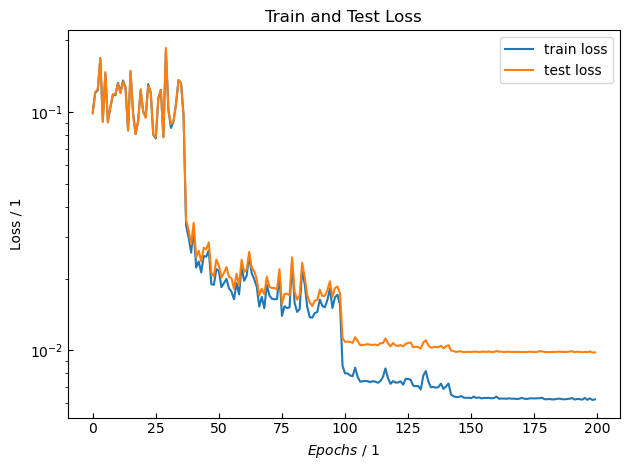

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#np.savez('data/models/hyperparams/loss_005_014.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999395362419322 , R^2(NH3) = 0.9998876210853553
Test Dataset: R^2(H2) = 0.9998575596635902 , R^2(NH3) = 0.9997320862181849
Max Error Training: |x_H2 - x_H2,pred| = 0.011053959899845256 , |x_NH3 - x_NH3,pred| = 0.027881204876066545
Max Error Test: |x_H2 - x_H2,pred| = 0.016477127301110894 , |x_NH3 - x_NH3,pred| = 0.010609145077046911


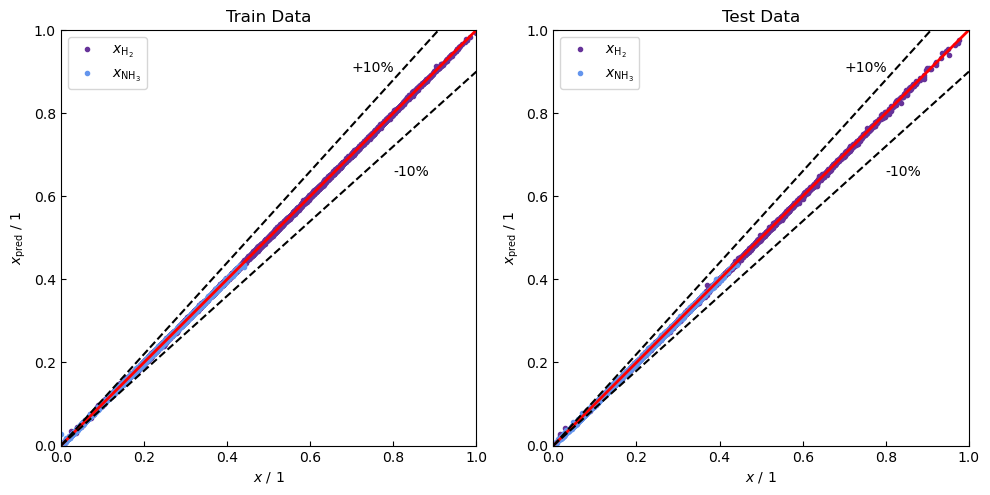

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

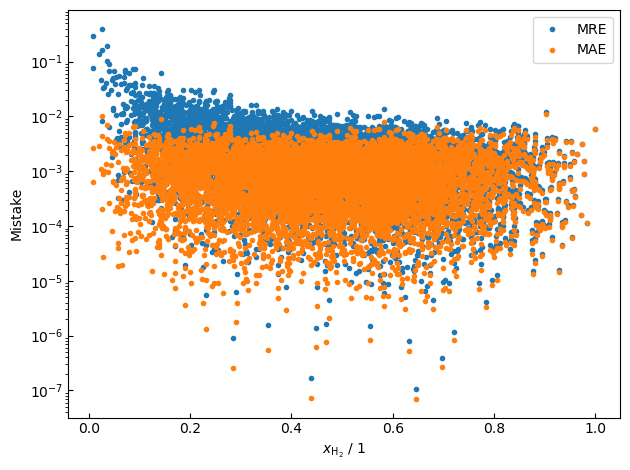

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

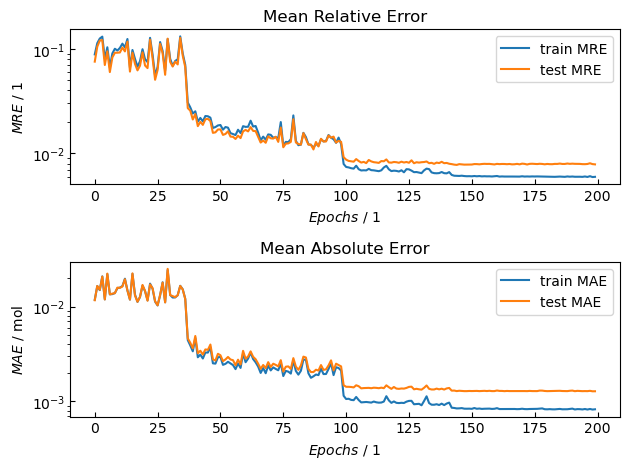

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

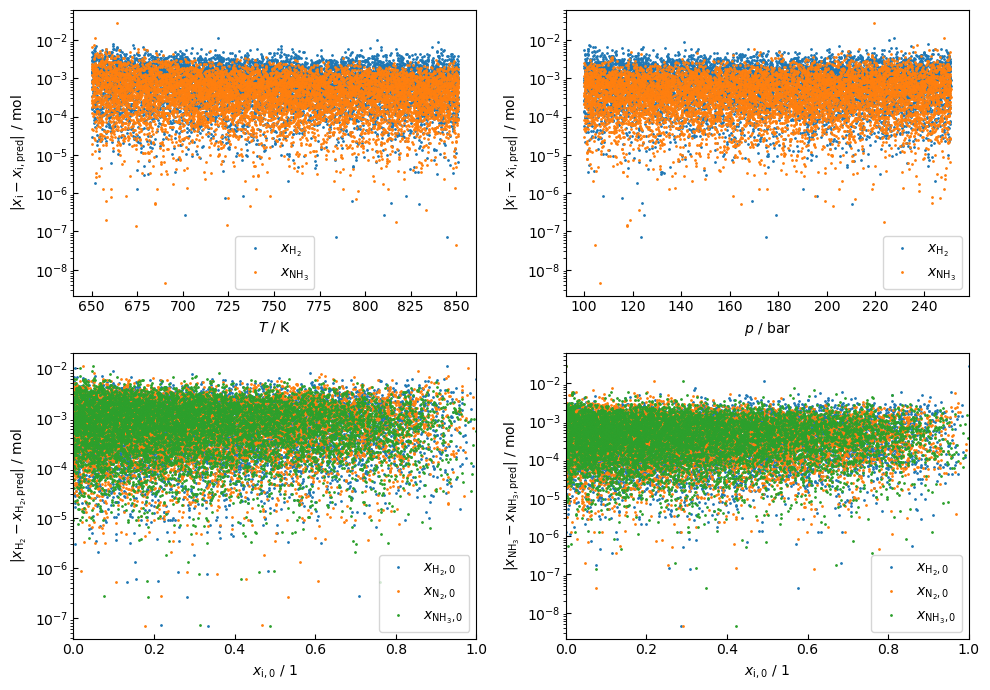

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

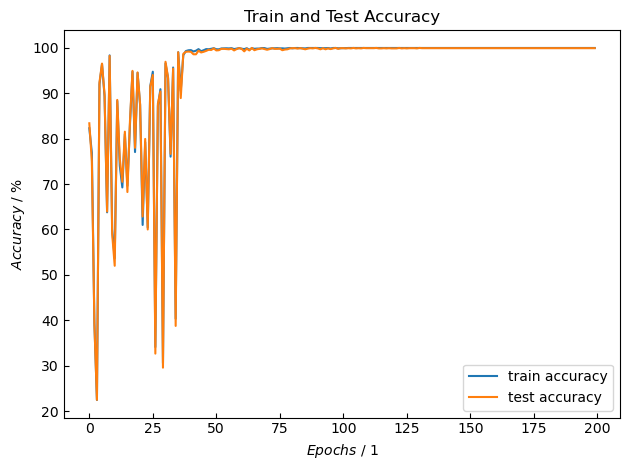

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 0.1981,  0.9445,  1.0857, -1.1493,  0.0651],
        [-1.2732, -0.5229, -0.7792,  1.2270, -0.4541],
        [ 0.4107,  1.1720,  2.7648, -1.3902, -1.3903],
        [-1.5314,  1.4290, -0.7690,  0.4626,  0.3098],
        [-0.6657,  1.6401,  1.2255, -0.8069, -0.4230],
        [ 0.7430,  1.4157,  0.1324,  0.5711, -0.7124],
        [-1.2769,  0.5889,  1.1762, -0.9174, -0.2613],
        [ 0.1784,  0.7023,  0.0460, -0.3278,  0.2854],
        [ 1.4237, -0.6330, -1.1765, -0.3506,  1.5458],
        [-0.1954, -1.1169, -0.8535, -0.0711,  0.9359],
        [-1.1328,  1.1084, -0.6683, -0.5020,  1.1848],
        [-0.7763,  0.2070,  1.1142, -0.7205, -0.3980],
        [ 1.3357, -1.0385, -0.5029,  0.5724, -0.0707],
        [-1.6270, -1.5044, -0.5446, -1.2096,  1.7762],
        [ 1.3105,  0.7372, -0.5651, -0.5279,  1.1066],
        [-1.6302,  0.8047, -0.4688, -1.3807,  1.8728],
        [ 0.5533, -1.2396, -0.2401,  1.2293, -1.0020],
        [-0.1744,  0.1401, -0.5902,  0.3563,  0.2364],
        [-

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 6.0030e-01, -1.2106e-01,  1.2547e-01, -1.4230e-01, -1.1573e-01],
         [-1.1396e-01,  4.8282e-02,  3.2947e-01, -3.2842e-01,  4.4285e-01],
         [-3.5939e-02, -1.3675e-02, -2.1973e-01, -2.5277e-01, -1.7161e-01],
         [-9.6173e-01,  2.3538e-01, -1.0949e-01,  2.3858e-01, -9.9022e-02],
         [ 6.0115e-01, -3.7028e-01, -7.1062e-01,  2.4693e-01, -2.3563e-01],
         [-1.0224e-02, -4.0019e-03, -5.4230e-02,  5.5554e-01,  1.8492e-01],
         [-2.4722e-01,  1.1428e-01,  4.5783e-02,  7.8916e-01,  2.7557e-01],
         [ 5.1164e-01, -1.8876e-01,  4.5991e-01, -7.6853e-04,  3.6640e-01],
         [ 2.6486e-03, -1.4547e-02, -1.8884e-02,  5.6716e-04,  8.5689e-03],
         [ 6.3026e-02,  2.1982e-01,  1.3861e-01,  9.4748e-02, -1.9090e-02],
         [ 4.1856e-03,  2.8422e-03, -2.4381e-01, -2.4531e-01, -2.4447e-01],
         [ 5.7622e-01, -1.9962e-01,  4.0963e-01,  2.4061e-01,  4.9246e-01],
         [-5.5833e-02,  3.9819e-02,  2.5994e-02, -1.8745e-01,  2.

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.0693, 0.5783, 0.8243, 0.1988, 0.0829],
        [0.6378, 0.9742, 0.4625, 0.8616, 0.5577]])
tensor([[ 0.1502,  0.3458],
        [-0.0894, -0.1476]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 0.0970, -1.4466, -0.1998,  0.6795, -0.4859],
        [-0.4026, -1.2262, -1.2249,  0.8665,  0.3622],
        [-0.8253,  0.7921,  0.6837, -0.6611, -0.0224],
        [ 1.1642,  0.4168,  1.0427,  0.2532, -1.3118],
        [-1.2611,  1.5550,  1.1003, -0.0271, -1.0862],
        [-0.7464,  1.2004, -0.1111,  0.3135, -0.2051],
        [ 0.0927, -1.2709, -1.2881,  1.1471,  0.1420],
        [ 1.0018,  0.5678,  0.6492,  0.0358, -0.6933],
        [ 0.7453, -0.9640,  0.1869,  0.2018, -0.3935],
        [ 1.1654, -0.2896, -0.1607,  0.8355, -0.6835],
        [ 0.5105, -1.4594, -0.8370,  1.0596, -0.2260],
        [ 0.4858,  0.4188, -0.9157,  1.8735, -0.9707],
        [ 1.6217,  1.4862, -1.0669,  1.5398, -0.4798],
        [ 1.5028,  1.0041, -0.3205,  0.8956, -0.5827],
        [ 0.1649,  0.6366,  1.9338, -1.1477, -0.7948],
        [-0.9069, -0.3099, -0.5808, -0.0323,  0.6205],
        [-1.1425, -1.1699, -0.8585,  0.3734,  0.4906],
        [-0.3574,  0.5185, -0.8548, -1.1879,  2.0682],
        [ 

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()